# Installing Packages

In [ ]:
!pip install requests
!pip install xgboost
!pip install scikit-learn

!python -m spacy download fr_core_news_sm
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import xgboost as xgb
import requests
import matplotlib.colors as mcolors
import xml.etree.ElementTree as ET
import zipfile
import os
import re
import calendar

from matplotlib.colors import ListedColormap
from tqdm import tqdm
from io import BytesIO, StringIO
from zipfile import ZipFile, BadZipFile
from urllib.request import urlretrieve
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from bs4 import BeautifulSoup
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Defining colour palette for graphs

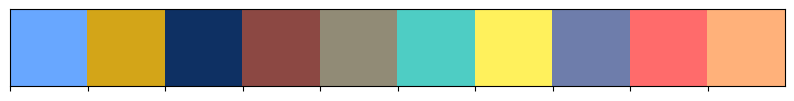

In [2]:
colour_codes = ["#68A7FF","#d3A518","#0e3063","#8c4843","#918b76",
                "#4ECDC4","#FFF15C","#6E7DAB", "#FF6B6B","#FFB17A"]

sns.palplot(sns.color_palette(colour_codes))

colour_palette = ListedColormap(sns.color_palette(colour_codes))

# IUROPA Database

The IUROPA Database consists of 12 separate datasets. For now, the 'judgments' dataset will be used

## Judgments

In [397]:
iuropa_judgments = pd.read_csv("Databases/CJEU_data/IUROPA-CJEU-Database-Platform/IUROPA-CJEU-Database-Platform-judgments.csv")
iuropa_judgments = iuropa_judgments.sort_values('case_year') # sorting by case year
iuropa_judgments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22680 entries, 0 to 21960
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   key_id                         22680 non-null  int64  
 1   court_id                       22680 non-null  int64  
 2   court                          22680 non-null  object 
 3   iuropa_case_id                 22680 non-null  object 
 4   cjeu_case_id                   22680 non-null  object 
 5   case_year                      22680 non-null  int64  
 6   case_number                    22680 non-null  int64  
 7   iuropa_proceeding_id           22680 non-null  object 
 8   cjeu_proceeding_id             22680 non-null  object 
 9   proceeding_suffix              22680 non-null  object 
 10  proceeding_name                22679 non-null  object 
 11  iuropa_decision_id             22680 non-null  object 
 12  cjeu_decision_id               22680 non-null  obje

In [156]:
iuropa_judgments

key_id  court_id             court    iuropa_case_id cjeu_case_id  \
0           1         1  Court of Justice  CJEU:C:1954:0001       C-1/54   
1           2         1  Court of Justice  CJEU:C:1954:0002       C-2/54   
2           3         1  Court of Justice  CJEU:C:1954:0003       C-3/54   
3           4         1  Court of Justice  CJEU:C:1954:0004       C-4/54   
4           5         1  Court of Justice  CJEU:C:1954:0006       C-6/54   
...       ...       ...               ...               ...          ...   
21956   21957         2     General Court  CJEU:T:2022:0004       T-4/22   
21938   21939         2     General Court  CJEU:T:2022:0046      T-46/22   
21754   21755         2     General Court  CJEU:T:2022:0125     T-125/22   
21905   21906         2     General Court  CJEU:T:2022:0012      T-12/22   
21960   21961         2     General Court  CJEU:T:2022:0129     T-129/22   

       case_year  case_number iuropa_proceeding_id cjeu_proceeding_id  \
0           1954            1     CJEU:C:1954:0001             C-1/54   
1           1954            2     CJEU:C:1954:0002             C-2/54   
2           1954            3     CJEU:C:1954:0003             C-3/54   
3           1954            4     CJEU:C:1954:0004             C-4/54   
4           1954            6     CJEU:C:1954:0006             C-6/54   
...          ...          ...                  ...                ...   
21956       2022            4     CJEU:T:2022:0004             T-4/22   
21938       2022           46     CJEU:T:2022:0046            T-46/22   
21754       2022          125     CJEU:T:2022:0125           T-125/22   
21905       2022           12     CJEU:T:2022:0012            T-12/22   
21960       2022          129     CJEU:T:2022:0129           T-129/22   

      proceeding_suffix  ... count_advocates_general list_advocates_general  \
0                  none  ...                       1               Lagrange   
1                  none  ...                       1               Lagrange   
2                  none  ...                       1               Lagrange   
3                  none  ...                       1               Lagrange   
4                  none  ...                       1                 Roemer   
...                 ...  ...                     ...                    ...   
21956              none  ...                       0         not applicable   
21938              none  ...                       0         not applicable   
21754              none  ...                       0         not applicable   
21905              none  ...                       0         not applicable   
21960              none  ...                       0         not applicable   

      count_opinions                list_opinions count_cited_documents  \
0                  1  CJEU:C:1954:0001:C:19541110                    22   
1                  1  CJEU:C:1954:0002:C:19541111                    25   
2                  1  CJEU:C:1954:0003:C:19541111                    10   
3                  0                         none                     9   
4                  1  CJEU:C:1954:0006:C:19550204                     9   
...              ...                          ...                   ...   
21956              0               not applicable                     0   
21938              0               not applicable                     0   
21754              0               not applicable                     0   
21905              0               not applicable                     0   
21960              0               not applicable                     0   

                                    list_cited_documents  \
0      11951K/CDT/P30, 11951K002, 11951K003, 11951K00...   
1      11951K/CDT/P30, 11951K/PRO/CJ/23, 11951K002, 1...   
2      11951K/CDT/P30, 11951K004, 11951K033, 11951K04...   
3      11951K/CDT/P30, 11951K005, 11951K015, 11951K03...   
4      11951K/CDT/P12, 11951K003, 11951K005, 11951K01...   
...    

Some columns contain list data. See e.g. the example below.

In [ ]:
iuropa_judgments[["ecli", "cjeu_case_id", "case_year"]]

While the combination of certain features can be important, we also split this data in separate columns to be able to train on each individual feature too.

In [398]:
for col in iuropa_judgments.columns:
    
    # Checking if the column contains lists
    if 'list_' in col:
        
        # Define separators based on column name
        if col in ['list_procedures', 'list_judges', 'list_advocates_general']:
            sep = ';'
        else:
            sep = ','
        
        # Splitting
        split_data = iuropa_judgments[col].str.split(f'[{sep}] ', expand=True)
        
        # Dropping 'list_' for naming purposes
        col_name = col.replace('list_', '')
        
        # Renaming the new columns according to their master column
        split_data.columns = [f'{col_name}_{i+1}' for i in range(split_data.shape[1])]
        
        # Updating iuropa_judgments
        iuropa_judgments = pd.concat([iuropa_judgments, split_data], axis=1)

## Judges

The judges dataset containts background information on the CJEU judges.

In [10]:
iuropa_judges = pd.read_csv("Databases/CJEU_data/IUROPA-CJEU-Database-Platform/IUROPA-CJEU-Database-Platform-judges.csv")
iuropa_judges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   key_id                  272 non-null    object 
 1   iuropa_judge_id         268 non-null    object 
 2   full_name               268 non-null    object 
 3   first_name              268 non-null    object 
 4   last_name               268 non-null    object 
 5   last_name_latin         268 non-null    object 
 6   last_name_label         268 non-null    object 
 7   last_name_latin_label   268 non-null    object 
 8   iuropa_member_state_id  268 non-null    object 
 9   member_state            268 non-null    object 
 10  birth_year              268 non-null    float64
 11  is_female               268 non-null    float64
 12  is_current              268 non-null    float64
 13  start_date              268 non-null    object 
 14  end_date                268 non-null    ob

Dropping unnecessary columns to avoid to large dimensions

In [11]:
iuropa_judges = iuropa_judges.drop(columns= ['key_id', 'iuropa_judge_id', 'full_name', 'first_name', 'last_name_latin', 'last_name', 'last_name_latin_label', 'iuropa_member_state_id'])
iuropa_judges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   last_name_label    268 non-null    object 
 1   member_state       268 non-null    object 
 2   birth_year         268 non-null    float64
 3   is_female          268 non-null    float64
 4   is_current         268 non-null    float64
 5   start_date         268 non-null    object 
 6   end_date           268 non-null    object 
 7   was_judge          268 non-null    float64
 8   was_academic       268 non-null    float64
 9   was_civil_servant  268 non-null    float64
 10  was_lawyer         268 non-null    float64
 11  was_politician     268 non-null    float64
dtypes: float64(8), object(4)
memory usage: 25.6+ KB


There are missing values because of wrong parsing.  We'll impute them manually

In [12]:
judge_data = """
"O'Higgins, T.",Ireland,1913,0,0,1985-01-16,1991-10-06,1,0,1,1,1
"O'Higgins, K.",Ireland,1946,0,0,2008-09-15,2013-09-16,1,0,0,1,0
"Rossi, R.", Italy,1889,0,0,1958-10-07,1964-10-07,1,0,1,1,0
"Rossi, L.", Italy,1958,1,1,2018-10-08,2022-12-31,0,1,0,1,0
"""

correct_headers = [
    "last_name_label","member_state", "birth_year", "is_female", 
    "is_current", "start_date", "end_date", "was_judge", "was_academic", 
    "was_civil_servant", "was_lawyer", "was_politician"
]

csv_buffer = StringIO(judge_data)
judge_data = pd.read_csv(csv_buffer, header=None, names=correct_headers)

print(judge_data)


  last_name_label member_state  birth_year  is_female  is_current  start_date  \
0   O'Higgins, T.      Ireland        1913          0           0  1985-01-16   
1   O'Higgins, K.      Ireland        1946          0           0  2008-09-15   
2       Rossi, R.        Italy        1889          0           0  1958-10-07   
3       Rossi, L.        Italy        1958          1           1  2018-10-08   

     end_date  was_judge  was_academic  was_civil_servant  was_lawyer  \
0  1991-10-06          1             0                  1           1   
1  2013-09-16          1             0                  0           1   
2  1964-10-07          1             0                  1           1   
3  2022-12-31          0             1                  0           1   

   was_politician  
0               1  
1               0  
2               0  
3               0  


This data can now be added to iuropa_judges

In [13]:
# Appending new data frame to iuropa_judges
iuropa_judges = pd.concat([iuropa_judges, judge_data], ignore_index=True)

print(iuropa_judges)

    last_name_label    member_state  birth_year  is_female  is_current  \
0             Azizi         Austria      1948.0        0.0         0.0   
1              Jann         Austria      1935.0        0.0         0.0   
2        Stix-Hackl         Austria      1957.0        1.0         0.0   
3            Berger         Austria      1956.0        1.0         0.0   
4        Kreuschitz         Austria      1952.0        0.0         0.0   
..              ...             ...         ...        ...         ...   
271       Forrester  United Kingdom      1945.0        0.0         0.0   
272   O'Higgins, T.         Ireland      1913.0        0.0         0.0   
273   O'Higgins, K.         Ireland      1946.0        0.0         0.0   
274       Rossi, R.           Italy      1889.0        0.0         0.0   
275       Rossi, L.           Italy      1958.0        1.0         1.0   

     start_date    end_date  was_judge  was_academic  was_civil_servant  \
0    1995-01-18  2013-09-16        0

This data can be merged with the iuropa_judgments dataset

### Merging iuropa_judgments and iuropa_judges

In [414]:
# Getting the list of judges in iuropa_judgments
judge_cols = [col for col in iuropa_judgments.columns if 'judges_' in col]

# Creating a progress bar
pbar = tqdm(total=len(iuropa_judgments))

# Creating a list to store data for new columns
new_columns_data = []

# Looping over each row in iuropa_judgments
for i, row in iuropa_judgments.iterrows():
    
    # Creating a dictionary to store data for the current row
    row_data = {}
    
    for jcol in judge_cols:
        judge_last_name = row[jcol]
        judge_info = iuropa_judges[iuropa_judges['last_name_label'] == judge_last_name]
        
        if not judge_info.empty:
            for icol in iuropa_judges.columns:
                if icol != 'last_name_label':
                    new_col_name = f'{icol}_{jcol}'
                    row_data[new_col_name] = judge_info[icol].values[0]
                    
    new_columns_data.append(row_data)
    pbar.update()

pbar.close()

# Creating a new df from new_columns_data
new_columns = pd.DataFrame(new_columns_data, index=iuropa_judgments.index)

# Concatenating the original DataFrame with the new columns
iuropa_full_judgments = pd.concat([iuropa_judgments, new_columns], axis=1)


100%|██████████| 22680/22680 [08:53<00:00, 42.47it/s]


#### Dropping the rows for which judges are not known

In [415]:
iuropa_full_judgments = iuropa_full_judgments[iuropa_full_judgments['judges_1'] != 'no record']

#### Intermediate save

In [416]:
iuropa_full_judgments.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 22651 entries, 0 to 21960
Data columns (total 749 columns):
 #    Column                         Dtype  
---   ------                         -----  
 0    key_id                         int64  
 1    court_id                       int64  
 2    court                          object 
 3    iuropa_case_id                 object 
 4    cjeu_case_id                   object 
 5    case_year                      int64  
 6    case_number                    int64  
 7    iuropa_proceeding_id           object 
 8    cjeu_proceeding_id             object 
 9    proceeding_suffix              object 
 10   proceeding_name                object 
 11   iuropa_decision_id             object 
 12   cjeu_decision_id               object 
 13   ecli                           object 
 14   celex                          object 
 15   decision_type                  object 
 16   decision_date                  object 
 17   proceeding_date                obj

In [417]:
iuropa_full_judgments.to_csv('Databases/CJEU_data/iuropa_full_judgments_23-4.csv',  index = False)

In [418]:
iuropa_full_judgments = pd.read_csv('Databases/CJEU_data/iuropa_full_judgments_23-4.csv', low_memory=False)

## Decisions

### Download court texts using ECLI numbers

The decisions table contains the most ECLI numbers, which make it possible to identify and download text files related to the proceedings

In [ ]:
iuropa_decisions = pd.read_csv("Databases/CJEU_data/IUROPA-CJEU-Database-Platform/IUROPA-CJEU-Database-Platform-decisions.csv")
iuropa_decisions = iuropa_decisions.sort_values('case_year') # sorting by case year
iuropa_decisions.info()

#### Function

In [ ]:
def download_and_update_text(ecli_number, output_folder, table):
    preferred_languages = ["FR", "EN", "DE"] # most used languages

    for lang in preferred_languages:
        url = f"https://eur-lex.europa.eu/legal-content/{lang}/TXT/HTML/?uri=ecli:{ecli_number}"
        
        # Adding 'retry' to avoid errors 
        retry_strategy = Retry(total=3, backoff_factor=2, status_forcelist=[500, 502, 503, 504])
        adapter = HTTPAdapter(max_retries=retry_strategy)
        session = requests.Session()
        session.mount("https://", adapter)

        try:
            response = session.get(url, timeout=10)  # adding a timeout to avoid overloading EURlex
            
            if response.status_code == 200:
                soup = BeautifulSoup(response.text, "html.parser")
                text = soup.get_text()

                # Checking if the text starts with this patterns 
                # (= start from html file when no text is found)
                if text.startswith("\n\n\n\n\n\n\n\nEUR-Lex - ecli:"):
                    continue

                else:
                    # Extracting the year from the ECLI number
                    year = ecli_number.split(":")[3][:4]

                    year_folder = os.path.join(output_folder, year)
                    if not os.path.exists(year_folder):
                        os.makedirs(year_folder)

                    # Replacing ':' with space to make make valid filenames
                    ecli_name = ecli_number.replace(":", " ")

                    # Ensuring ecli_name only contains valid characters for filename
                    valid_characters = "".join(x for x in ecli_name if x.isalnum() or x in [' ', '.'])
                    file_name = f"{valid_characters}.txt"
                    file_path = os.path.join(year_folder, file_name)
                    with open(file_path, "w", encoding="utf-8") as file:
                        file.write(text)

                    # Updating table with the downloaded text
                    table.loc[table['ecli'] == ecli_number, 'content'] = text

                    break  # if text is found in preferred language > Stop
            
        except Exception as e:
            print(f"Error downloading text for ECLI: {ecli_number} - {str(e)}")

#### Running function

In [ ]:
decisions_table = iuropa_decisions.copy()

output_folder = "Decisions_By_Years"

# Progress bar
for ecli_number in tqdm(decisions_table['ecli'], total=len(decisions_table)):
    download_and_update_text(ecli_number, output_folder, decisions_table)

#### Adding the texts to the decions_table

In [ ]:
# Iterating through each year folder
for year_folder in tqdm(os.listdir(output_folder), desc="Year folders"):
    year_path = os.path.join(output_folder, year_folder)
    
    # Iterating through each file in the year folder
    for file_name in os.listdir(year_path):
        file_path = os.path.join(year_path, file_name)
        
        # Extracting ECLI from file name
        ecli_number = file_name.split(".")[0]
        
        # Converting filename back to ECLI format
        ecli_number = ecli_number.replace(" ", ":")
        
        # Reading text from the file
        with open(file_path, "r", encoding="utf-8") as file:
            text = file.read()
        
        # Updating decisions_table with text for corresponding case ID
        decisions_table.loc[decisions_table['ecli'] == ecli_number, 'text'] = text

#### Updating iuropa_decisions by integrating the texts into specific columns

In [ ]:
# Iterating through each row in decisions_table
for index, row in decisions_table.iterrows():
    
    # Extracting relevant information
    iuropa_proceeding_id = row['iuropa_proceeding_id']
    decision_type = row['decision_type']
    text = row['text']
    
    if iuropa_proceeding_id in iuropa_decisions['iuropa_proceeding_id'].values:
        iuropa_decisions.loc[iuropa_decisions['iuropa_proceeding_id'] == iuropa_proceeding_id, decision_type] = text
   
    else:
        # Adding new row to iuropa_decisions with NaNs in all columns except the relevant one
        new_row = {'iuropa_proceeding_id': iuropa_proceeding_id}
        for column in decisions_table3.columns:
            if column == 'iuropa_proceeding_id' or column == decision_type:
                continue
            new_row[column] = pd.np.nan
        new_row[decision_type] = text
        iuropa_decisions = iuropa_decisions.append(new_row, ignore_index=True)

#### Only keeping rows for which there's text data

In [ ]:
relevant_columns = ['order', 'AG opinion', 'judgment', 'third-party proceedings', 
                    'opinion', 'seizure order', 'ruling', 'AG view', 'decision']

# Filtering rows where at least one of these is *NOT* NaN (there should be at least one text per row)
rows_with_text = iuropa_decisions[relevant_columns].notna().any(axis=1)

iuropa_decisions_text = iuropa_decisions[filtered_rows]

#### Making df of rows without texts

In [ ]:
# Filtering rows where all specified columns are NaN
rows_with_all_nan = iuropa_decisions[relevant_columns].isna().all(axis=1)

# Creating a DataFrame of rows where all specified columns are NaN
no_texts = iuropa_decisions[rows_with_all_nan]


To get more texts we will extract the Official Journals of the EU

# Official Journals of the European Union

The Official Journals are available through: https://data.europa.eu/data/datasets?locale=en&minScoring=0&publisher=Publications%20Office%20of%20the%20European%20Union&format=CSV&categories=JUST&keywords=oj-c-information&page=2&limit=10.

I downloaded them manually and put the downloaded CSV files in a folder named 'OJ_files'

### Loading the different OJ files into a data frame

In [ ]:
folder_path = "Databases/CJEU_data/OJ_files"

# Loading CSV files from the folder
csv_files = {}
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        csv_files[file_name] = pd.read_csv(file_path)

# Merging all data frames into one
merged_oj_csv = pd.concat(csv_files.values(), ignore_index=True)

# Filtering rows based on 'title_' containing C (= court-related)
oj_court_filtered = merged_oj_csv[merged_oj_csv['title_'].str.contains('C \d', regex=True, na=False)]

# Saving the filtered data frame to a CSV file
output_directory = 'Databases/CJEU_data/'
output_file_path = os.path.join(output_directory, 'oj_court_filtered.csv')
oj_court_filtered.to_csv(output_file_path, index=False)
oj_court_filtered

### Extracting all XML-files and sorting them

The CSV files contain a link which downloads a ZIP file of XML files containing the content of the Official Journals

In [ ]:
total_files = len(oj_court_filtered)

for index, row in tqdm(oj_court_filtered.iterrows(), total=total_files):
    year_xml = pd.to_datetime(row['date_document']).year
    year_folder = f'Databases/CJEU_data/XML_files/{year_xml}'
    year_folder = year_folder.replace(':', '_').replace('?', '_').replace('&', '_')
    
    os.makedirs(year_folder, exist_ok=True)

    # Getting the URL from the 'fmx4_to_download' column
    url = row['fmx4_to_download']

    # Skipping if the URL is missing or invalid
    if pd.isna(url) or not isinstance(url, str) or not url.startswith(('http://', 'https://')):
        print(f"Skipping invalid URL for year {year_xml}: {url}")
        continue

    # Creating and downloading the zip file
    response = requests.get(url, stream=True)

    if response.status_code == 200:
        try:
            with ZipFile(BytesIO(response.content)) as zip_year:
                zip_year.extractall(year_folder)
        except BadZipFile:
            print(f"Failed to create the zip file for year {year_xml} due to Bad CRC-32. Skipping...")
            continue
    else:
        print(f"Failed to download the zip file for year {year_xml}. HTTP status code: {response.status_code}")
        continue

### Filter XML-files linked to Court Of Justice (contain the tag 'CJT')

In [ ]:
def filter_xml(xml_file):
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        return any(elem.tag == 'CJT' for elem in root.iter())
    except ET.ParseError as e:
        print(f"Error parsing XML file {xml_file}: {e}")
        return False

# Applying the function
for year_folder in tqdm(os.listdir('Databases/CJEU_data/XML_files'), desc="Year folders"):
    folder_path = f'Databases/CJEU_data/XML_files/{year_folder}'

    for file_name in tqdm(os.listdir(folder_path), desc=f"Files in {year_folder}", leave=False):
        file_path = os.path.join(folder_path, file_name)

        # Check if the file is an XML file
        if file_name.lower().endswith('.xml'):
            if not filter_xml(file_path):
                os.remove(file_path)
        else:
            os.remove(file_path)

### Extract the text content

In [ ]:
def extract_text(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    text = ' '.join(elem.text.strip() for elem in root.iter() if elem.text)
    return text.strip()

input_base_folder = 'Databases/CJEU_data/XML_files'
output_base_folder = 'Databases/CJEU_data/Grouped_Text_files'

# Extracting text and saving to TXT
for year_folder in tqdm(os.listdir(input_base_folder), desc="Year folders"):
    input_year_folder = os.path.join(input_base_folder, year_folder)
    output_year_folder = os.path.join(output_base_folder, year_folder)

    # Creating year-specific output folders
    os.makedirs(output_year_folder, exist_ok=True)

    for xml_file in tqdm(os.listdir(input_year_folder), desc=f"Files in {year_folder}", leave=False):
        file_path = os.path.join(input_year_folder, xml_file)
        text = extract_text(file_path)

        output_text_file = os.path.join(output_year_folder, f'{xml_file.replace(".xml", ".txt")}')

        with open(output_text_file, 'w', encoding='utf-8') as txt_file:
            txt_file.write(text)



### Functions to create a dataframe with texts, case ids, proceeding suffixes and joined cases

#### Extracting case ids

In [ ]:
def extract_case_ids(text):
    # Replacing all dashes with hyphens
    text = text.replace('–', '-')

    # Extracting text before the first ':' (indicates the end of the document info)
    text_before_colon = text.split(':', 1)[0]

    # Making a regex pattern for case IDs and opinions based on the first line of the texts
    pattern = re.compile(r'(?<!\S)(?:Case(?:s)?\s*\d+\s*\/?\s*\d+\s*)?|(?:[CTF]-?\s*\d+-\d+-\d+(?:\s+(?:DEP|RENV|P|AJ|R|R II|REC|P-DEP|SA|P\(R\)|DEP II|REV|P-R|INTP|TO|TO-R|P-REV|R III|DEP I|RENV II|P-INTP|RENV-R|P\(R\)-DEP|R I|P\(I\)|RENV-RX|P-AJ|P-RENV-RX|P-RENV-RX-AJ|RENV-REC|REV I|P\(R\)-INTP|PPU|RX|RX II|R II-INTP|P\(R\)-R|P-REC|OP|R-RENV|OST|DISS|DISS I|DISS II|R-REC|P-DEP II|REV-INTP|RENV I|OP-R|RENV-DEP II|P-REV-OST|P-REV III|R-OST|P-OST|DEP III|P-TO|P-REV II|AJ-REV|R-INTP|R-RAP))?)|(?:[CTF]-\s*\d+\s*\/?\s*\d+\s*(?:DEP|RENV|P|AJ|R|R II|REC|P-DEP|SA|P\(R\)|DEP II|REV|P-R|INTP|TO|TO-R|P-REV|R III|DEP I|RENV II|P-INTP|RENV-R|P\(R\)-DEP|R I|P\(I\)|RENV-RX|P-AJ|P-RENV-RX|P-RENV-RX-AJ|RENV-REC|REV I|P\(R\)-INTP|PPU|RX|RX II|R II-INTP|P\(R\)-R|P-REC|OP|R-RENV|OST|DISS|DISS I|DISS II|R-REC|P-DEP II|REV-INTP|RENV I|OP-R|RENV-DEP II|P-REV-OST|P-REV III|R-OST|P-OST|DEP III|P-TO|P-REV II|AJ-REV|R-INTP|R-RAP)?)|(?:\(\s*[CTF]-?\s*\d+\s*\/?\s*\d+\s*(?:DEP|RENV|P|AJ|R|R II|REC|P-DEP|SA|P\(R\)|DEP II|REV|P-R|INTP|TO|TO-R|P-REV|R III|DEP I|RENV II|P-INTP|RENV-R|P\(R\)-DEP|R I|P\(I\)|RENV-RX|P-AJ|P-RENV-RX|P-RENV-RX-AJ|RENV-REC|REV I|P\(R\)-INTP|PPU|RX|RX II|R II-INTP|P\(R\)-R|P-REC|OP|R-RENV|OST|DISS|DISS I|DISS II|R-REC|P-DEP II|REV-INTP|RENV I|OP-R|RENV-DEP II|P-REV-OST|P-REV III|R-OST|P-OST|DEP III|P-TO|P-REV II|AJ-REV|R-INTP|R-RAP)?\))|(?:Opinion\s+\d+\/\d+)|(?:\(\s*Opinion\s+\d+\/\d+\s*\))')

    # Finding all matches in the text before the first ':'
    matches = re.findall(pattern, text_before_colon)

    # Preprocessing case IDs
    case_ids = []
    for match in matches:
        case_id = re.sub(r'[\[\]\(\)]', '', match)

        # If case ID starts with 'Case', remove 'Case' and prepend 'C-'
        if case_id.startswith('Case'):
            case_id = 'C-' + case_id[len('Case'):].lstrip(' ')
        case_ids.append(case_id.strip())  

        if '-' in case_id:
            # If the case ID is in the format '[letter]-[number]-[number]', only replace the second hyphen
            parts = case_id.split('-')
            case_id = '-'.join([parts[0], parts[1].replace('-', '/')] + parts[2:])

    return list(set(case_ids))


#### Extracting document types

In [ ]:
def extract_document_type(text):
    
    # Again defining the end of the document info
    text_before_colon = text.split(':', 1)[0]
    
    lower_text = text_before_colon.lower()

    # Defining keywords for each document type
    document_types = {
        'action': ['action for damages', 'action brought on'],
        'judgment': ['judgment of the', 'judgment pursuant to'],
        'appeal': ['appeal brought on'],
        'request_prel_ruling': ['request for a preliminary ruling'],
        'order': ['order of the', 'order pursuant to'],
        'reference_prel_ruling': ['reference for a preliminary ruling'],
        'opinion': ['opinion of']
    }

    # Checking if any of the keywords are present in the text
    for document_type, keywords in document_types.items():
        for keyword in keywords:
            if keyword in lower_text:
                return document_type

    # Returning 'unknown' if no document type is found
    return 'unknown'

#### Extracting proceeding suffixes

##### Checking proceeding suffixes present in the IUROPA judgments dataset

In [ ]:
proceeding_suffixes = iuropa_judgments['proceeding_suffix'].unique()

In [ ]:
def extract_proceeding_suffix(case_id):
    # Defining proceeding suffixes
    pattern = re.compile(r'\b(DEP|RENV|P|AJ|R|R II|REC|P-DEP|SA|P\(R\)|DEP II|REV|P-R|INTP|TO|TO-R|P-REV|R III|DEP I|RENV II|P-INTP|RENV-R|P\(R\)-DEP|R I|P\(I\)|RENV-RX|P-AJ|P-RENV-RX|P-RENV-RX-AJ|RENV-REC|REV I|P\(R\)-INTP|PPU|RX|RX II|R II-INTP|P\(R\)-R|P-REC|OP|R-RENV|OST|DISS|DISS I|DISS II|R-REC|P-DEP II|REV-INTP|RENV I|OP-R|RENV-DEP II|P-REV-OST|P-REV III|R-OST|P-OST|DEP III|P-TO|P-REV II|AJ-REV|R-INTP|R-RAP)\b')

    # Finding all matches in the case ID
    matches = re.findall(pattern, case_id)

    if matches:
        return matches
    else:
        return 'none'

### Implementing functions

In [ ]:
input_folder = 'Databases/CJEU_data/Grouped_Text_files'
output_folder = 'Databases/CJEU_data/Extracted_Case_Numbers'

results = []

# Processing each file in the input folder
for root, _, files in os.walk(input_folder):
    for filename in files:
        input_file_path = os.path.join(root, filename)

        try:
            with open(input_file_path, 'r', encoding='utf-8') as input_file:
                text = input_file.read()

                # Extracting case IDs and document types
                case_ids = extract_case_ids(text)
                document_type = extract_document_type(text)

                case_ids = [case_id for case_id in case_ids if case_id]

                if case_ids:
                    case_id_indices = {}

                    for case_id in case_ids:
                    
                        case_id_indices[case_id] = text.index(case_id) if case_id in text else float('inf')

                        proceeding_suffixes = extract_proceeding_suffix(case_id)

                    # Getting the case ID with the smallest index and making it the main case ID
                    main_case_id = min(case_id_indices, key=case_id_indices.get)

                    other_case_ids = [case_id for case_id in case_ids if case_id != main_case_id]

                    # Determining if it's a joined case
                    joined_cases = 'Yes' if len(case_ids) > 1 else 'No'

                    # Ordering IDs as in IUROPA judgments
                    other_case_ids.append(main_case_id)
                    other_case_ids.sort(key=lambda x: text.index(x))

                    if joined_cases == 'Yes':
                        other_case_ids_str = ', '.join(str(case_id) for case_id in other_case_ids)

                    else:
                        other_case_ids_str = str(other_case_ids[0])

                    result_dict = {
                        'text': text,
                        'cjeu_case_id': main_case_id,
                        'list_joined_proceedings': other_case_ids_str,
                        'proceeding_suffix': proceeding_suffixes,
                        'joined_cases': joined_cases,
                        'document_type': document_type
                         }

                    results.append(result_dict)

                else:
                    print(f"No case IDs found in {filename}")

        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Converting everything to a data frame
result_df = pd.DataFrame(results)

# saving to a CSV file
output_csv_path = 'Databases/CJEU_data/result_table.csv'
result_df.to_csv(output_csv_path, index=False)

print(f"Result table saved to {output_csv_path}")


In [ ]:
oj_data = pd.read_csv('Databases/CJEU_data/result_table.csv')
oj_data

### Manually adding data that was not added

In [ ]:
new_data = {'text':
                ['C 118 2004 EN 9 1 01 20040430 EN 015 9 1 9 1 2004/C 118/15 Judgment of the Court (Sixth Chamber) of 29 April 2004 in Joined Cases C-162/01 P and C-163/01 P: Edouard Bouma and Bernard M.J.B. Beusmans v Council of the European Union and Commission of the European Communities OJ C 227, 11.8.2001. Action for damages Non-contractual liability Milk Additional levy Reference quantity Producers having entered into a non-marketing undertaking SLOM 1983 producers Non-resumption of production on expiry of the undertaking (2004/C 118/15) Language of the cases: Dutch Provisional translation: the definitive translation will be published in the European Court Reports In Joined Cases C-162/01 P and C-163/01 P: Edouard Bouma, residing in Rutten (Netherlands), Bernard M.J.B. Beusmans, residing in Noorbeek (Netherlands), (legal representative: E.H. Pijnacker Hordijk) – two appeals lodged against the judgments of the Court of First Instance of the European Communities (Fourth Chamber) of 31 January 2001 29 April 2004 (1) The appeals are dismissed. (2) Mr Bouma and Mr Beusmans are ordered to pay the respective costs.', 
                 'C 262 2004 EN 26 2 01 20040714 EN 050 26 2 26 1 2004/C 262/50 Order of the Court of First Instance of 14 July 2004 in Case T-360/02: Wolf-Dieter Graf Yorck von Wartenburg v Commission of the European Communities OJ C 55, 8. 3.2003 Death of the applicant No continuance of suit by estate No need to adjudicate (2004/C 262/50) Language of the case: German In Case T-360/02: Wolf-Dieter Graf Yorck von Wartenburg, former temporary servant of the European Parliament, residing in Wittibreut (Germany), represented by H.-H. Heyland, lawyer, with an address for service in Luxembourg, against the Commission of the European Communities (Agent: J. Currall, and B. Wägenbaur, lawyer, with an address for service in Luxembourg) — application for annulment of a Commission communication of 17 May 2002 14 July 2004 1. There is no need to adjudicate on the present action. 2. The parties shall bear their own costs.',
                 'C 300 2004 EN 3 2 01 20041014 EN 005 3 2 3 1 2004/C 300/05 Judgment of the Court (First Chamber) of 14 October 2004 in Case C-36/02 (reference for a preliminary ruling from the Bundesverwaltungsgericht): Omega Spielhallen- und Automatenaufstellungs-GmbH v Oberbürgermeisterin der Bundesstadt Bonn OJ C 109 of 4.5.2002 Freedom to provide services Free movement of goods Restrictions Public policy Human dignity Protection of fundamental values laid down in the national constitution ‘Playing at killing’ (2004/C 300/05) Language of the case: German Provisional translation; the definitive translation will be published in the European Court Reports In Case C-36/02: reference for a preliminary ruling under Article 234 EC from the Bundesverwaltungsgericht (Germany), made by decision of 24 October 2001 12 February 2002 14 October 2004 Community law does not preclude an economic activity consisting of the commercial exploitation of games simulating acts of homicide from being made subject to a national prohibition measure adopted on grounds of protecting public policy by reason of the fact that that activity is an affront to human dignity.',
                 'C 300 2004 EN 56 1 01 20021114 EN 109 56 2 56 1 2004/C 300/109 ORDER OF THE COURT (Fourth Chamber) of 14 November 2002 (reference for a preliminary ruling from the Consiglio di Stato): Comune di Udine, Azienda Multiservizi SpA (AMGA) and Diddi Dino Figli Srl, Associazione Nazionale Imprese Gestione servizi tecnici integrati (AGESI) OJ C 289 of 13.10.2001 Article 104(3) of the Rules of Procedure Question to which the answer may be clearly deduced from the case-law Directive 92/50/EEC Public contracts concerning both products and services Value of the products greater than that of the services Application of Directive 93/36/EEC (2003/C 55/50) Language of the case: Italian In Case C-310/01: reference to the Court under Article 234 EC from the Consiglio di Stato (Italy) for a preliminary ruling in the proceedings pending before that court between Comune di Udine, Azienda Multiservizi SpA (AMGA) and Diddi Dino Figli Srl, Associazione Nazionale Imprese Gestione servizi tecnici integrati (AGESI) — on the interpretation of Articles 1(b), 2 and 6 of Council Directive 92/50/EEC of 18 June 1992 11 November 2002 Article 2 of Council Directive 92/50/EEC of 18 June 1992 14 June 1993 Directive 93/36 applies to such a contract unless the contracting authority exercises over the supplier a control which is similar to that which it exercises over its own departments and the supplier carries out the essential parts of its activities with the controlling contracting authority or authorities.',
                 'C 045 2005 EN 23 1 01 20041123 EN 051 23 1 23 1 2005/C 45/51 Judgment of the Court of First Instance of 23 November 2004 in Case T-376/02, O v Commission of the European Communities OJ C 44 of 22.2.03 Officials Article 78 of the Staff Regulations Invalidity pension Invalidity Committee Membership Occupational disease (2005/C 45/51) Language of the case: French In Case T-376/02: O, a former official of the Commission of the European Communities, residing in Brussels, represented by J. Van Rossum and J.-N. Louis, lawyers, against Commission of the European Communities (Agents: J. Currall) – action for annulment of the decision of the Commission of 14 January 2002 23 November 2004 1. Annuls the decision of the Commission of 14 January 2002 2. Orders the Commission to bear the costs.' ,
                 'C 057 2005 EN 7 1 01 20050120 EN 012 7 1 7 1 2005/C 57/12 Judgment of the Court (Second Chamber) of 20 January 2005 in Case C-74/03 (reference for a preliminary ruling by the Østre Landsret): SmithKline Beecham plc v Lægemiddelstyrelsen OJ C 101 of 26.04.2003 Medicinal products Marketing authorisation Abridged procedure Essentially similar products Active substance in different forms of salt Additional documentation (2005/C 57/12) Language of the case: Danish In Case C-74/03: reference for a preliminary ruling under Article 234 EC by the Østre Landsret (Denmark), made by decision of 14 February 2003 19 February 2003 20 January 2005 1. Article 4.8(a)(iii) of Council Directive 65/65/EEC of 26 January 1965 22 December 1986 3 May 1989 14 June 1993 2. In support of an application under Article 4.8(a)(iii) of Directive 65/65 as amended, an applicant may, either spontaneously or at the request of the competent authority of a Member State, supply additional documentation in the form of certain pharmacological and toxicological tests or clinical trials in order to demonstrate that his product is essentially similar to the reference product.',
                 'C 057 2005 EN 10 1 01 20050120 EN 018 10 1 10 1 2005/C 57/18 Judgment of the Court (Second Chamber) of 20 January 2005 in Case C-306/03 (reference for a preliminary ruling by the Juzgado de lo Social n o OJ C 226 of 20.09.2003 Social security of migrant workers Articles 12 EC, 39 EC and 42 EC Articles 45 and 48(1) of Regulation (EEC) No 1408/71 Old age and death Unemployment Minimum periods of insurance Periods of insurance taken into account for calculating the amount of benefits but not for acquiring the right to those benefits Periods of unemployment Aggregation (2005/C 57/18) Language of the case: Spanish In Case C-306/03: reference for a preliminary ruling under Article 234 EC from the Juzgado de lo Social n o 24 June 2003 16 July 2003 20 January 2005 Articles 39 EC and 42 EC and Article 45 of Council Regulation (EEC) No 1408/71 on the application of social security schemes to employed persons, to self-employed persons and to members of their families moving within the Community, in the version amended and updated by Council Regulation (EC) No 118/97 of 2 December 1996 29 June 1998' ,
                 'C 296 2005 EN 28 3 01 20050914 EN 062 28 3 29 2 2005/C 296/62 Action brought on 14 September 2005 Case T-342/05 (2005/C 296/62) Language in which the application was lodged: German Parties Applicant(s): Defendant Other party or parties to the proceedings before the Board of Appeal of OHIM: Form of order sought The applicant claims that the Court should: Annul the decision of the First Board of Appeal of the Office for Harmonisation in the Internal Market of 14 July 2005 19 July 2005 Order the Office for Harmonisation in the Internal Market to pay the costs. Pleas in law and main arguments Applicant for a Community trade mark: Community trade mark concerned: Proprietor of the mark or sign cited in the opposition proceedings: Mark or sign cited in opposition: Decision of the Opposition Division: Decision of the Board of Appeal: Pleas in law:',
                 'C 096 2006 EN 22 1 01 20060217 EN 039 22 1 23 2 2006/C 96/39 Action brought on 17 February 2006 Case T-57/06 (2006/C 96/39) Language in which the application was lodged: French Parties Applicant: Defendant Other party to the proceedings before the Board of Appeal of OHIM: Erdal Gesellschaft m.b.H. (Hallein, Austria) Form of order sought The applicant claims that the Court should: annul the decision of the Board of Appeal of OHIM in so far as it upholds the opposition by the proprietor of the word mark order the defendant to pay the costs, including expenses necessarily incurred during proceedings before the Board of Appeal, incurred by the party initiating the proceedings and as calculated in the decision under appeal. Pleas in law and main arguments Applicant for a Community trade mark: the applicant Community trade mark concerned: 2326072 Proprietor of the mark or sign cited in the opposition proceedings: Erdal Gesellschaft m.b.H. Mark or sign cited in opposition:  the international word mark ‘TOPIX’ for goods in Classes 3 and 4. Decision of the Opposition Division: opposition upheld in respect of all the disputed goods. Decision of the Board of Appeal: appeal dismissed Pleas in law:infringement of Article 8(1)(b) of Council Regulation (EC) No 40/94 in that there is a visual and conceptual difference between the conflicting trade marks and a very great difference between the goods to which the two trade marks relate.',
                 'C 096 2006 EN 27 1 01 20060220 EN 045 27 1 28 2 2006/C 96/45 Action brought on 20 February 2006 Case T-67/06 (2006/C 96/45) Language in which the application was lodged: Dutch Parties Applicant: Defendant Other party to the proceedings before the Board of Appeal of OHIM: Rolex. S.A (Geneva, Switzerland) Form of order sought The applicant claims that the Court should: review and annul the decision of the Fourth Board of Appeal of the Office for Harmonisation in the Internal Market (Trade Marks and Designs) of 12 December 2005 order OHIM to pay the costs. Pleas in law and main arguments Applicant for a Community trade mark: Elini N.V. Community trade mark concerned: Proprietor of the mark or sign cited in the opposition proceedings: Rolex S.A. Mark or sign cited in opposition: 1456102 Decision of the Opposition Division: rejection of the opposition Decision of the Board of Appeal: annulment of the decision of the Opposition Division and rejection of the application for a Community trade mark. Pleas in law:breach of Article 8(1)(b) of Regulation No 40/94.',
                 'C 108 2006 EN 23 2 01 20060228 EN 043 23 2 24 2 2006/C 108/43 Action brought on 28 February 2006 Case T-73/06 (2006/C 108/43) Language in which the application was lodged: French Parties Applicant: Defendant Form of order sought The applicant claims that the Court should: Primarily, annul the decision taken and order OHIM to pay the costs; Alternatively, appoint an expert or a body of experts with responsibility for giving the Court guidance on whether or on what conditions the shape of a manufactured good or the representation of its outline can have as much influence on the publics memory of it as an accompanying term, as an indication of its business origin, and reserve the costs. Pleas in law and main arguments Community trade mark concerned: Figurative trade mark representing a bag in respect of goods in Class 18 (Application No 003598571). Decision of the Examiner: Registration refused. Decision of the Board of Appeal: Appeal dismissed.. Pleas in law: Infringement of Article 4 and Article 7(1)(b) of Council Regulation No 40/94. The applicant argues that the trade mark has enough distinctive character to distinguish and characterise a bag or a range of bags from one undertaking from those from other undertakings.',
                 'C 108 2006 EN 29 1 01 20060317 EN 052 29 1 29 1 2006/C 108/52 Action brought on 17 March 2006 Case T-96/06 (2006/C 108/52) Language in which the application was lodged: Greek Parties Applicant: Defendant: Other party to the proceedings before the Board of Appeal of OHIM: Form of order sought Annulment of the decision of the Second Board of Appeal of 11 January 2006 Pleas in law and main arguments Applicant for a Community trade mark: Community trade mark concerned: Proprietor of the mark or sign cited in the opposition proceedings: Mark or sign cited in opposition: Decision of the Opposition Division: Opposition accepted for some of the goods. Decision of the Board of Appeal: Appeal dismissed. Pleas in law: Infringement of Article 8(1)(b) of Council Regulation No 40/94',
                 'C 121 2006 EN 9 2 01 20060329 EN 016 9 2 10 2 2006/C 121/16 Reference for a preliminary ruling from The Court of Appeal (Civil Division) (England and Wales) made on 29 March 2006 Interested Party: The Melton Mowbray Pork Pie Association Case C-169/06 (2006/C 121/16) Language of the case: English Referring court Court of Appeal (Civil Division) (England and Wales) Parties to the main proceedings Applicant: Defendant: Interested Party Questions referred Where the specification in an application for a protected geographical indication (PGI) in respect of the town of Melton Mowbray and its surrounding region bounded as follows: to the North by the A52 from the M1 and the A1 and including the city of Nottingham; to the East by the A1 from the A52 to the A45 and including the towns of Grantham and Stamford; to the West by the M1 from the A52 and the A45; and to the South by the A45 from the M1 and the A1 and including the town of Northampton 1. are the requirements of Article 2(2)(b) of the Regulation capable of being satisfied insofar as the proposed PGI would apply to products produced and/or processed and/or prepared in places other than that whose name appears in the PGI; 2. if so, what criteria must be applied in delimiting the defined geographical area referred to in Articles 2(2)(b) and 4(2)(c) of the Regulation?',
                 'C 121 2006 EN 16 1 01 20060323 EN 028 16 1 16 1 2006/C 121/28 Action brought on 23 March 2006 Case T-101/06 (2006/C 121/28) Language in which the application was lodged: Spanish Parties Applicant: Defendant: Other party to the proceedings before the Board of Appeal of OHIM: Bodegas Roda (Haro, La Rioja, Spain) Form of order sought Annul the Decision of the First Board of Appeal of OHIM of 17 January 2006 order OHIM to pay the costs. Pleas in law and main arguments Applicant for a Community trade mark: Castell del Remei Community trade mark concerned: Proprietor of the mark or sign cited in the opposition proceedings: Bodegas Roda, S.A. Mark or sign cited in opposition: Decision of the Opposition Division: Decision of the Board of Appeal: Dismissal of the appeal Pleas in law.',
                 'C 165 2006 EN 29 1 01 20060715 EN 057 29 1 29 1 2006/C 165/57 Action brought on 11 May 2006 Case T-134/06 (2006/C 165/57) Language in which the application was lodged: French Parties Applicant: Defendant: Other party to the proceedings before the Board of Appeal: Form of order sought The applicant asks the Court to: set aside Decision R 708/2005-1 dated 15 February 2006 uphold the Community trade mark declare that all costs are the responsibility of the Board of Appeal of OHIM. Pleas in law and main arguments Applicant for a Community trade mark: Community trade mark concerned: 1880871 Proprietor of the mark or sign cited in the opposition proceedings: Mark or sign cited in opposition: Decision of the Opposition Division: Decision of the Board of Appeal: Pleas in law: It also relies on an infringement of Article 7(1)(c) and (d) of Council Regulation 40/94, in that the opposing partys trade mark is customary and has very little distinctive character. It claims that its trade mark, in respect of which registration was sought, does not compromise the business name or commercial name of the opposing party. The applicant also disputes the renown of the opposing partys trade mark.', 
                 'C 190 2006 EN 23 1 01 20060522 EN 041 23 1 23 1 2006/C 190/41 Action brought on 22 May 2006 Case T-146/06 (2006/C 190/41) Language in which the application was lodged: Spanish Parties Applicant: Defendant: Other party to the proceedings before the Board of Appeal of OHIM: Form of order sought Annul the decision of the First Board of Appeal of OHIM of 3 February 2006 Order OHIM to pay the costs. Pleas in law and main arguments Applicant for a Community trade mark: Community trade mark concerned: 1662311 Proprietor of the mark or sign cited in the opposition proceedings: Mark or sign cited in opposition: Decision of the Opposition Division: Decision of the Board of Appeal: Pleas in law:',
                 'C 190 2006 EN 23 2 01 20060526 EN 042 23 2 24 2 2006/C 190/42 Action brought on 26 May 2006 Case T-148/06 (2006/C 190/42) Language in which the application was lodged: Spanish Parties Applicant: Defendant: Other party to the proceedings before the Board of Appeal of OHIM: Marie Claire Album SA Form of order sought annul the decision of the Second Board of Appeal of 6 March 2006 declare, accordingly, that the Community trade mark applied for is not caught by the prohibitions in Article 8(5)CMR 40/94, since such provisions do not apply to this case; declare that the Community trade mark applied for, No 77.834 declare that the prohibitions in Article 8(1)(b) CMR 40/94 are not applicable to the Community trade mark applied for, as already held in both the decision of the Opposition Division and the Second Board of Appeal of OHIM; allow registration of Community trade mark No 77.834 order OHIM to pay the costs together with any party which appears as a third party to these proceedings. Pleas in law and main arguments Applicant for a Community trade mark: Community trade mark concerned: Word mark 2389567 Proprietor of the mark or sign cited in the opposition proceedings: Marie Claire Album SA. Mark or sign cited in opposition: National and international word and figurative marks Decision of the Opposition Division: Opposition dismissed. Decision of the Board of Appeal: Opposition Division decision annulled and opposition upheld. Pleas in law:',
                 'C 310 2006 EN 27 1 01 20060904 EN 050 27 1 27 1 2006/C 310/50 Action brought on 4 September 2006 Case T-300/06 (2006/C 310/50) Language in which the application was lodged: German Parties Applicant: Defendant: Other party to the proceedings before the Board of Appeal of OHIM: Form of order sought amend the defendants decision of 4 May 2006 order the defendant to pay the costs. Pleas in law and main arguments Applicant for a Community trade mark: Community trade mark concerned: Proprietor of the mark or sign cited in the opposition proceedings: Mark or sign cited in opposition: Decision of the Opposition Division: Decision of the Board of Appeal: Pleas in law: Council Regulation (EC) No 40/94 of 20 December 1993 OJ 1994 L 11, p. 1',
                 'C 326 2006 EN 75 2 01 20061122 EN 154 75 2 76 2 2006/C 326/154 Action brought on 22 November 2006 Case T-327/06 (2006/C 326/154) Language in which the application was lodged: German Parties Applicant: Defendant: Other party to the proceedings before the Board of Appeal of OHIM: Form of order sought The applicant claims that the Court should: annul the decision of the First Board of Appeal of the Office for Harmonisation in the Internal Market (Trade Marks and Designs) of 11 September 2006 order the Office for Harmonisation in the Internal Market (Trade Marks and Designs) to dismiss opposition No B 575524 in the alternative, order the Office for Harmonisation in the Internal Market (Trade Marks and Designs) to make a fresh decision on opposition No B 575524 Pleas in law and main arguments Applicant for a Community trade mark: Community trade mark concerned: 2462049 Proprietor of the mark or sign cited in the opposition proceedings: Mark or sign cited in opposition: Decision of the Opposition Division: Decision of the Board of Appeal: Pleas in law: Council Regulation (EC) No 40/94 of 20 December 1993 OJ 1994 L 11, p. 1',
                 'C 129 2009 EN 17 2 01 20090326 EN 0030 17 2 18 2 2009/C 129/30 125 2009 Action brought on 26 March 2009 Case T-125/09 2009/C 129/30 Language in which the application was lodged: German Parties Applicant: Defendant: Other party to the proceedings before the Board of Appeal of OHIM: Form of order sought Reject application No 4491891 for the trade mark Class 20: Goods (not included in other classes) of wood, cork, reed, cane, wicker, horn, bone, ivory, whalebone, shell, mother-of-pearl, meerschaum and substitutes for all these materials, or of plastics; Class 30: Sugar, rice, tapioca, sago, artificial coffee; flour and preparations made from cereals, bread, pastry and confectionery; honey, treacle; yeast, baking-powder; salt, mustard; vinegar, sauces (condiments); spices; ice; confectionery, candyfloss; Class 31: Agricultural, horticultural and forestry products and grains not included in other classes; live animals; seeds, natural plants and flowers; foodstuffs for animals; malt; products from organic farming, flowers, arrangements, plant arrangements; Class 35: Advertising, marketing concepts; Class 39: Transport, packaging and storage of goods; travel arrangement, exhibition guides, city and building guides, tourist services, package holidays; Order the applicant to pay the costs. Pleas in law and main arguments Applicant for a Community trade mark: Community trade mark concerned: 4491891 Proprietor of the mark or sign cited in the opposition proceedings: Mark or sign cited in opposition: 1825629 1931393 Decision of the Opposition Division: Decision of the Board of Appeal: Pleas in law:',
                 'C 129 2009 EN 19 1 01 20090406 EN 0033 19 1 19 1 2009/C 129/33 132 2009 Action brought on 6 April 2009 Case T-132/09 2009/C 129/33 Language in which the application was lodged: German Parties Applicant: Defendant: Other party to the proceedings before the Board of Appeal of OHIM: Form of order sought Annul the decision of the Second Board of Appeal of 19 January 2009 annul Decision No B 979767 of the Opposition Division of 22 May 2008 order the defendant and the opposing party to pay the costs of the proceedings. Pleas in law and main arguments Applicant for a Community trade mark: Community trade mark concerned: 4133799 Proprietor of the mark or sign cited in the opposition proceedings: Mark or sign cited in opposition: Decision of the Opposition Division: Decision of the Board of Appeal: Pleas in law: Commission Regulation (EC) No 2868/95 of 13 December 1995 OJ 1995 L 303, p. 1',
                 'C 129 2009 EN 19 2 01 20090406 EN 0034 19 2 20 2 2009/C 129/34 137 2009 Action brought on 6 April 2009 Case T-137/09 2009/C 129/34 Language in which the application was lodged: Spanish Parties Applicant: Defendant: Other party to the proceedings before the Board of Appeal of OHIM: Form of order sought Amend the contested decision with regard to the inadmissibility of the appeal, finding that that appeal is admissible, and order the Board of Appeal act in accordance therewith and examine the substance of the appeal; In the alternative, find infringement by the Board of Appeal and the Opposition Division of Article 73 of Regulation No 40/94 and the other provisions applicable, ordering its retroactive application to the file to remedy the lack of opportunity of the applicant (Nike International Ltd) to correct the anomalies as assignee of the prior right and/or, at the very least, the correct notification of the Decision to the representative of the preceding proprietor (DL Sports & Marketing Ltda.). Pleas in law and main arguments Applicant for a Community trade mark: Community trade mark concerned: 4813713 Proprietor of the mark or sign cited in the opposition proceedings: Mark or sign cited in opposition: Decision of the Opposition Division: OJ 1994 L 11, p. 1 13 December 1995 OJ 1995 L 303, p. 1 Decision of the Board of Appeal: Pleas in law:',
                 'C 205 2009 EN 42 1 01 20090624 EN 0077 42 1 42 1 2009/C 205/77 242 2009 Action brought on 24 June 2009 Case T-242/09 2009/C 205/77 Language in which the application was lodged: German Parties Applicant: Defendant: Other party to the proceedings before the Board of Appeal of OHIM: Form of order sought Annul the decision of the Board of Appeal of CPVO of 23 January 2009 Order the defendant to pay the costs. Pleas in law and main arguments Community trade mark concerned: Proprietor of the mark or sign cited in the opposition proceedings: Decision of the Community Plant Variety Office, appealed against before the Board of Appeal: Council Regulation (EC) No 2100/94 of 27 July 1994 OJ 1994 L 227, p. 1 Appellant before the Board of Appeal: Decision of the Board of Appeal: Pleas in law: Infringement of Article 76 of Regulation No 2100/94 and the generally recognised principles of procedure within the meaning of Article 81 of Regulation No 2100/94 insofar as the Board of Appeal ruled in the contested decision without sufficiently investigating the facts of the case; Infringement of Article 20(1)(a) and Article 7 of Regulation No 2100/94 insofar as the Board of Appeal apparently wrongly assumed that the applicant could not fulfil the conditions referred to in Article 20(1)(a) and accordingly, failed to appreciate the scope of that provision; Infringement of Article 75 of Regulation No 2100/94 insofar as the Board of Appeal based its ruling on grounds on which the applicant did not have an opportunity to express itself before the decision; Infringement of Article 63(1) and (2) of Regulation No 1239/95 Commission Regulation (EC) No 1239/95 of 31 May 1995 OJ 1995 L 121, p. 37',
                 'C 220 2009 EN 11 1 01 20090716 EN 0017 11 1 11 1 2009/C 220/17 168 2008 Judgment of the Court (Third Chamber) of 16 July 2009 (Case C-168/08) OJ C 158, 21.6.2008 Judicial cooperation in civil matters Regulation (EC) No 2201/2003 Jurisdiction, recognition and enforcement of decisions in matrimonial matters and the matters of parental responsibility Article 64 Transitional provisions Application to a judgment given in a Member States which acceded to the European Union in 2004 Article 3(1) Jurisdiction in matters relating to divorce Relevant connecting factors Habitual residence Nationality Spouses residing in France and each holding French and Hungarian nationality 2009/C 220/17 Language of the case: French Referring court Cour de cassation Parties to the main proceedings Applicant: Defendant: Re: Reference for a preliminary ruling — Cour de Cassation (France) — Interpretation of Article 2 of Council Regulation (EC) No 1347/2000 of 29 May 2000 OJ 2000 L 160, p. 19 27 November 2003 OJ 2003 L 338, p. 1 Operative part of the judgment 1. Where the court of the Member State addressed must verify, pursuant to Article 64(4) of Council Regulation (EC) No 2201/2003 of 27 November 2003 2. Where spouses each hold the nationality of the same two Member States, Article 3(1)(b) of Regulation No 2201/2003 precludes the jurisdiction of the courts of one of those Member States from being rejected on the ground that the applicant does not put forward other links with that State. On the contrary, the courts of those Member States of which the spouses hold the nationality have jurisdiction under that provision and the spouses may seise the court of the Member State of their choice.',
                 'C 220 2009 EN 17 1 01 20090603 EN 0029 17 1 17 1 2009/C 220/29 394 2008 Order of the Court (Fifth Chamber) of 3 June 2009 (Case C-394/08 P) OJ C 285, 8.11.2008 Appeal Community trade mark Article 8(1)(b) of Regulation (EC) No 40/94 Word mark ZIPCAR Opposition by the proprietor of the national word mark CICAR 2009/C 220/29 Language of the case: English Parties Appellant: Other party to the proceedings: Re: Appeal against the judgment of the Court of First Instance (Eighth Chamber) of 25 June 2008 Zipcar OHIM 30 November 2006 Operative part of the order 1. The appeal is dismissed. 2. Zipcar Inc. is ordered to pay the costs.',
                 'C 220 2009 EN 39 2 01 20090709 EN 0083 39 2 40 2 2009/C 220/83 279 2009 Action brought on 9 July 2009 Case T-279/09 2009/C 220/83 Language in which the application was lodged: Italian Parties Applicant: Defendant: Other party to the proceedings before the Board of Appeal of OHIM: Form of order sought Annul the decision of the First Board of Appeal of OHIM of 2 April 2009 14 May 2009 856163 Order the defendant to pay all the costs of the proceedings before the Court of First Instance of the European Communities. Pleas in law and main arguments Applicant for a Community trade mark: Community trade mark concerned: 3563848 Proprietor of the mark or sign cited in the opposition proceedings: Mark or sign cited in opposition: 2689891 Decision of the Opposition Division: Decision of the Board of Appeal: Pleas in law:',
                 'C 267 2009 EN 65 2 01 20090804 EN 0118 65 2 66 2 2009/C 267/118 309 2009 Action brought on 4 August 2009 Case T-309/09 2009/C 267/118 Language in which the application was lodged: German Parties Applicant: Defendant: Other party to the proceedings before the Board of Appeal of OHIM: Form of order sought Annul the contested decision of the Second Board of Appeal of OHIM of 6 May 2009 Order OHIM to pay the costs of the proceedings; Order the intervener to pay the costs of the proceedings, including the costs incurred in the appeal procedure. Pleas in law and main arguments Applicant for a Community trade mark: Community trade mark concerned: Proprietor of the mark or sign cited in the opposition proceedings: Mark or sign cited in opposition: 30416654,5 Decision of the Opposition Division: Decision of the Board of Appeal: Pleas in law: Council Regulation (EC) No 207/2009 of 26 February 2009 OJ 2009 L 78, p. 1',
                 'C 267 2009 EN 70 1 01 20090825 EN 0128 70 1 71 2 2009/C 267/128 331 2009 Action brought on 25 August 2009 Case T-331/09 2009/C 267/128 Language in which the application was lodged: German Parties Applicant: Defendant: Other part to the proceedings before the Board of Appeal of OHIM: Form of order sought Annul the decision of the First Board of Appeal of the Office for Harmonisation in the Internal Market (Trade Marks and Designs) of 18 June 2009 Order the Office for Harmonisation in the Internal Market to pay the costs. Pleas in law and main arguments Applicant for a Community trade mark: Community trade mark concerned: 4134383 Proprietor of the mark or sign cited in the opposition proceedings: Mark or sign cited in opposition: 227508 Decision of the Opposition Division: Decision of the Board of Appeal: Pleas in law: Council Regulation (EC) No 207/2009 of 26 February 2009 OJ 2009 L 78, p. 1',
                 'C 267 2009 EN 73 1 01 20090827 EN 0132 73 1 73 1 2009/C 267/132 338 2009 Action brought on 27 August 2009 Case T-338/09 2009/C 267/132 Language in which the application was lodged: German Parties Applicant: Defendant: Other parties to the proceedings before the Board of Appeal of OHIM: Form of order sought Annulment the decision of the Fourth Board of Appeal of OHIM of 23 June 2009 Order OHIM to pay the costs. Pleas in law and main arguments Applicant for a Community trade mark: Community trade mark concerned: 1407857 Proprietor of the mark or sign cited in the opposition proceedings: Mark or sign cited in opposition: 667105 Decision of the Opposition Division: Decision of the Board of Appeal: Pleas in law: Council Regulation (EC) No 207/2009 of 26 February 2009 OJ 2009 L 78, p. 1',
                 'C 037 2010 EN 47 1 01 20091216 EN 0068 47 1 48 2 2010/C 37/68 504 2009 Action brought on 16 December 2009 Case T-504/09 2010/C 37/68 Language in which the application was lodged: German Parties Applicant: Defendant: Other party to the proceedings before the Board of Appeal of OHIM: Form of order sought Annul the decision of the First Board of Appeal of the Office for Harmonisation in the Internal Market (Trade Marks and Designs) of 30 September 2009 Annul the decision of the Opposition Division of the Office for Harmonisation in the Internal Market of 31 July 2008 1003153 Refusal of the opposition; Order the defendant to pay the costs. Pleas in law and main arguments Applicant for a Community trade mark: Community trade mark concerned: 4403705 Proprietor of the mark or sign cited in the opposition proceedings: Mark or sign cited in opposition: 571440 Decision of the Opposition Division: Decision of the Board of Appeal: Pleas in law: Infringement of the principle that the parties delimit the subject-matter of the proceedings (Article 74(1) of Regulation (EC) No 40/94), Council Regulation (EC) No 40/94 of 20 December 1993 OJ 1994 L 11, p. 1 Infringement of the prohibition of reformatio in pejus Infringement of the right to be granted a fair hearing (Article 38(3) and Article 73(2) of Regulation No 40/94); Infringement of Article 15(2)(a) and Article 43(2) and (3) of Regulation No 40/94 and Rule 22(2) of Regulation (EC) No 2868/95 Commission Regulation (EC) No 2868/95 of 13 December 1995 OJ 1995 L 303, p. 1',
                 'C 025 2012 EN 9 1 01 20111110 EN 0014 9 1 9 1 2012/C 25/14 259 2010 260 2010 Judgment of the Court (Third Chamber) of 10 November 2011 (Joined Cases C-259/10 and C-260/10) OJ C 209, 31.7.2010 Taxation Sixth VAT Directive Exemptions Article 13B(f) Betting, lotteries and other forms of gambling Principle of fiscal neutrality Mechanised cash bingo Slot machines Administrative practice departing from the legislative provisions 2012/C 25/14 Language of the case: English Referring court Court of Appeal (England and Wales) (Civil Division) and the Upper Tribunal (Tax and Chancery Chamber) (United Kingdom) Parties to the main proceedings Applicant: Defendant: Re: Reference for a preliminary ruling — Court of Appeal (England & Wales) (Civil Division) — Interpretation of Article 13B(f) of Sixth Council Directive 77/388/EEC of 17 May 1977 OJ 1977 L 145, p. 1 Operative part of the judgment 1. The principle of fiscal neutrality must be interpreted as meaning that a difference in treatment for the purposes of value added tax of two supplies of services which are identical or similar from the point of view of the consumer and meet the same needs of the consumer is sufficient to establish an infringement of that principle. Such an infringement thus does not require in addition that the actual existence of competition between the services in question or distortion of competition because of such difference in treatment be established; 2. Where there is a difference in treatment of two games of chance as regards the granting of an exemption from value added tax under Article 13B(f) of Sixth Council Directive 77/388/EEC of 17 May 1977 3. In order to assess whether, in the light of the principle of fiscal neutrality, two types of slot machine are similar and require the same treatment for the purposes of value added tax it must be established whether the use of those types of machine is comparable from the point of view of the average consumer and meets the same needs of that consumer, and the matters to be taken into account in that connection are, inter alia, the minimum and maximum permitted stakes and prizes and the chances of winning; 4. The principle of fiscal neutrality must be interpreted as meaning that a taxable person cannot claim reimbursement of the value added tax paid on certain supplies of services in reliance on a breach of that principle, where the tax authorities of the Member State concerned have, in practice, treated similar services as exempt supplies, although they were not exempt from value added tax under the relevant national legislation; 5. The principle of fiscal neutrality must be interpreted as meaning that a Member State which has exercised its discretion under Article 13B(f) of the Sixth Directive 77/388 and has exempted from value added tax the provision of all facilities for playing games of chance, while excluding from that exemption a category of machines which meet certain criteria, may not contest a claim for reimbursement of VAT based on the breach of that principle by arguing that it responded with due diligence to the development of a new type of machine not meeting those criteria.',
                 'C 355 2012 EN 34 1 01 20120906 EN 0071 34 1 34 1 2012/C 355/71 410 2012 Action brought on 6 September 2012 (Case T-410/12) 2012/C 355/71 Language in which the application was lodged: Hungarian Parties Applicant: Defendant: Other party to the proceedings before the Board of Appeal: Form of order sought Amend the decision of the First Board of Appeal of OHIM rejecting application No 8338592 for registration of the figurative mark Order the defendant or the other party to bear the costs. Pleas in law and main arguments Applicant for a Community trade mark: Community trade mark concerned: 8338592 Proprietor of the mark or sign cited in the opposition proceedings: Mark or sign cited in opposition: Decision of the Opposition Division: Decision of the Board of Appeal: Pleas in law: Council Regulation (EC) No 207/2009 of 26 February 2009 OJ 2009 L 78, p. 1',
                 'C 137 2020 EN 42 2 01 20191121 EN 0059 42 2 42 1 Order of the President of the Ninth Chamber of the Court of 21 November 2019 intervening party: (Case C-324/18) OJ C 285, 13.8.2018 2020/C 137/59 Language of the case: Italian The President of the Ninth Chamber has ordered that the case be removed from the register.',
                 'C 137 2020 EN 43 4 01 20191122 EN 0064 43 4 43 1 Order of the President of the Court of 22 November 2019 interested party: (Case C-110/19) OJ C 182, 27.5.2019 2020/C 137/64 Language of the case: Italian The President of the Court has ordered that the case be removed from the register.',
                 'C 137 2020 EN 44 1 01 20191122 EN 0065 44 1 44 1 Order of the President of the Court of 22 November 2019 interested party: (Case C-111/19) OJ C 182, 27.5.2019 2020/C 137/65 Language of the case: Italian The President of the Court has ordered that the case be removed from the register.',
                 'C 287 2020 EN 19 1 01 20200506 EN 0027 19 1 19 1 Order of the Court (Sixth Chamber) of 6 May 2020 (Joined Cases C-415/19 to C-417/19) OJ C 328, 30.9.2019 Reference for a preliminary ruling Article 99 of the Rules of Procedure of the Court of Justice State aid European Commission decision declaring an aid scheme compatible with the internal market National legislation precluding the award of aid under the authorised scheme in the event of non-compliance with a condition not provided for in the Commission decision 2020/C 287/27 Language of the case: Italian Referring court Corte suprema di cassazione Parties to the main proceedings Applicants: Defendant: Operative part of the order Article 108(3) TFEU, Commission Decision C(2008) 380 of 25 January 2008',
                 'C 433 2020 EN 7 1 01 20201022 EN 0006 7 1 8 2 Judgment of the Court (Fourth Chamber) of 22 October 2020 (Joined Cases C-720/18 and C-721/18) OJ C 54, 11.2.2019 Reference for a preliminary ruling Approximation of laws Trade marks Directive 2008/95/EC Article 12(1) Genuine use of trade mark Burden of proof Article 13 Proof of use Trade mark covering a car model the production of which has stopped Use of the trade mark in respect of replacement parts as well as for services relating to that model Use of the trade mark for used vehicles Article 351 TFEU Convention between the Federal Republic of Germany and the Swiss Confederation Reciprocal protection of patents, designs and trade marks 2020/C 433/06 Language of the case: German Referring court Oberlandesgericht Düsseldorf Parties to the main proceedings Applicant: Defendant: Operative part of the judgment 1. Article 12(1) and Article 13 of Directive 2008/95/EC of the European Parliament and of the Council of 22 October 2008 2. Article 12(1) of Directive 2008/95 must be interpreted as meaning that a trade mark is capable of being put to genuine use by its proprietor when that proprietor resells second-hand goods put on the market under that mark; 3. Article 12(1) of Directive 2008/95 must be interpreted as meaning that a trade mark is put to genuine use by its proprietor where that proprietor provides certain services connected with the goods previously sold under that mark, on condition that those services are provided under that mark; 4. The first paragraph of Article 351 TFEU must be interpreted as allowing a court of a Member State to apply a convention concluded between a Member State of the European Union and a non-member State before 1 January 1958 5. Article 12(1) of Directive 2008/95 must be interpreted as meaning that the burden of proof that a trade mark has been put to.',
                 'C 084 2022 EN 33 2 01 20211109 EN 0045 33 2 33 1 Order of the President of the Court of 9 November 2021 interested party: (Case C-334/21) OJ C 310, 2.8.2021 2022/C 84/45 Language of the case: Italian The President of the Court has ordered that the case be removed from the register.',
                 'C 222 2022 EN 25 1 01 20220204 EN 0037 25 1 25 1 Order of the President of the Court of 4 February 2022 intervener in support of the applicant: (Case C-121/21) OJ C 138, 14.4.2021 2022/C 222/37 Language of the case: Polish The President of the Grand Chamber has ordered that the case be removed from the register.', 
                 'C 015 2023 EN 32 1 01 20220809 EN 0035 32 1 32 1 Order of the President of the Court of 9 August 2022 interested party: (Joined Cases C-148/20 to C-150/20) OJ C 279, 24.8.2020 2023/C 15/35 Language of the case: German The President of the Court has ordered that the cases be removed from the register.',
                 'C 015 2023 EN 32 3 01 20220914 EN 0037 32 3 32 1 Order of the President of the Court of 14 September 2022 intervening parties: (Case C-486/20) OJ C 414, 30.11.2020 2023/C 15/37 Language of the case: Slovenian The President of the Court has ordered that the case be removed from the register.',
                 'C 015 2023 EN 34 2 01 20220913 EN 0044 34 2 34 1 Order of the President of the Court of 13 September 2022 intervening party: (Case C-215/22) OJ C 244, 27.6.2022 2023/C 15/44 Language of the case: Italian The President of the Court has ordered that the case be removed from the register.',
                 'C 112 2023 EN 29 1 01 20221228 EN 0037 29 1 29 1 Order of the President of the Court of 28 December 2022 interested party: (Case C-304/22, OJ C 318, 22.8.2022 2023/C 112/37 Language of the case: German The President of the Court has ordered that the case be removed from the register.',
                 'C 164 2023 EN 33 1 01 20230207 EN 0043 33 1 33 1 Order of the President of the Court of 7 February 2023 intervening parties: (Case C-152/21, OJ C 242, 21.6.2021 2023/C 164/43 Language of the case: Latvian The President of the Court has ordered that the case be removed from the register.',
                 'C 216 2023 EN 37 1 01 20230216 EN 0046 37 1 37 1 Order of the President of the Fourth Chamber of the Court of 16 February 2023 intervener in support of the defendant: (Case C-780/21 P) OJ C 73, 14.2.2022 2023/C 216/46 Language of the case: Spanish The President of the Fourth Chamber has ordered that the case be removed from the register.',
                 'C 216 2023 EN 37 2 01 20230216 EN 0047 37 2 37 1 Order of the President of the Court of 16 February 2023 intervener in support of the defendant: (Case C-824/21 P) OJ C 84, 21.2.2022 2023/C 216/47 Language of the case: Spanish The President of the Court has ordered that the case be removed from the register.',
                 'C 216 2023 EN 39 1 01 20230426 EN 0050 39 1 40 2 Judgment of the General Court of 26 April 2023 (Case T-54/21) OJ C 88, 15.3.2021 Public supply contracts Tendering procedure Competitive dialogue Procurement of Galileo transition satellites Rejection of a tenderer’s tender Exclusion criteria Serious professional misconduct on the part of a tenderer No final judgment or final administrative decision Referral to the panel referred to in Article 143 of the Financial Regulation Equal treatment Abnormally low tender Manifest error of assessment 2023/C 216/50 Language of the case: German Parties Applicant: Defendant: Interveners in support of the defendant Re: By its action under Article 263 TFEU, the applicant seeks annulment of the decisions of the European Commission, communicated to the applicant by letter of 19 January 2021 22 January 2021 Operative part of the judgment The Court: 1. Dismisses the action; 2. Orders OHB System AG to bear its own costs and to pay those incurred by the European Commission, including those relating to the proceedings for interim relief; 3. Orders the Italian Republic and Airbus Defence and Space GmbH to bear their own costs.',
                 'C 223 2023 EN 17 2 01 20230227 EN 0023 17 2 17 1 Order of the President of the Court of 27 February 2023 , interested party: (Case C-417/22, OJ C 326, 29.8.2022 2023/C 223/23 Language of the case: German The President of the Court has ordered that the case be removed from the register.',
                 'C 261 2023 EN 3 2 01 20230307 EN 0006 3 2 3 1 Order of the President of the Court of 7 March 2023 in the presence of: (Case C-398/21, OJ C 382, 20.9.2021 2023/C 261/06 Language of the case: French The President of the Court has ordered that the case be removed from the register.',
                 'C 261 2023 EN 4 2 01 20230315 EN 0009 4 2 4 1 Order of the President of the Court of 15 March 2023 interested parties: (Case C-463/21, OJ C 412, 11.10.2021 2023/C 261/09 Language of the case: Italian The President of the Court has ordered that the case be removed from the register.',
                 'C 329 2023 EN 17 1 01 20230721 EN 0021 17 1 17 1 Order of the President of the Court of 21 July 2023 in the presence of: (Case C-644/21, OJ C 95, 28.2.2022 2023/C 329/21 Language of the case: Romanian The President of the Court has ordered that the case be removed from the register.',
                 'C 202 2014 EN 16 1 01 20140313 EN 0019 16 1 16 1 Order of the President of the Court of 13 March 2014 in the presence of: (Case C-633/13) OJ C 71, 8. 3. 2014 2014/C 202/19 Language of the case: Polish The President of the Court has ordered that the case be removed from the register.',
                 'C 202 2017 EN 12 2 01 20170316 EN 0019 12 2 12 1 Order of the President of the Eighth Chamber of the Court of 16 March 2017 in the presence of: (Case C-212/16) OJ C 251, 11.7.2016 2017/C 202/19 Language of the case: German The President of the Eighth Chamber has ordered that the case be removed from the register.',
                 'C 190 2018 EN 19 2 01 20180207 EN 0030 19 2 19 1 Order of the President of the First Chamber of the Court of 7 February 2018 intervening party: (Case C-206/17) OJ C 249, 31.7.2017 2018/C 190/30 Language of the case: German The President of the First Chamber has ordered that the case be removed from the register.',
                 'C 010 2020 EN 53 1 01 20191119 EN 0064 53 1 54 2 2020/C 10/64 Action brought on 19 November 2019 (Case T-795/19) 2020/C 10/64 Language of the case: French Parties Applicant: Defendant: Form of order sought The applicant claims that the Court should: declare the present action admissible and well founded; consequently: annul Commission Decision of 15 October 2019 1199125 1197055,86 order the reimbursement of all amounts recovered by the Commission on the basis of that decision, together with late-payment interest at the rate applied by the European Central Bank plus seven points; order the payment of the last invoice issued by the applicant, in the amount of EUR 437649,39 order the symbolic payment of one euro by way of damages, subject to increase; order the Commission to pay all the costs. Pleas in law and main arguments In support of the action, the applicant relies on nine pleas in law. 1. First plea in law, alleging a lack of jurisdiction on the part of the Commission to adopt the contested decision, the absence of a legal basis for that decision and failure to observe the principle of legitimate expectations. The applicant claims in this regard that the Commission did not have jurisdiction to adopt the contested decision, forming a writ of execution for the recovery of the amount allegedly due to it from the applicant, in the absence of an arbitration clause conferring on the EU Courts jurisdiction for contractual disputes between them. 2. Second plea in law, alleging that the claim is time-barred and, in any event, infringement of the 25 June 2002 OJ 2002 L 248, p. 1 23 December 2002 OJ 2002 L 357, p. 1 3. Third plea in law, alleging failure to comply with the judgment of the tribunal de première instance de Bruxelles (Court of First Instance of Brussels, Belgium) of 5 October 2017 5 October 2017 4. Fourth plea in law, alleging that the contested decision is vitiated by manifest errors of assessment. The applicant claims in this regard that the acts complained of are manifestly not established and there are manifestly no irregularities, especially not serious ones. The contested decision is based on two OLAF reports; however the complaints made by the defendant are not established. 5. Fifth plea in law, alleging breach of the instructions to tenderers and of Article 103 of the 2002 Financial Regulation. The applicant takes the view that, among the complaints made by the defendant against the applicant, none of them concern the applicant having obtained confidential information, entered into an unlawful agreement with a competitor, influenced the evaluation committee or the contracting authority in the examination, clarification, evaluation or comparison of the bids. Therefore, neither the conditions of Article 130 of the 2002 Financial Regulation nor those of Article 13(a) of the instructions for tenderers are satisfied. 6. Sixth plea in law, alleging infringement of the rights of the defence on the ground that the applicant’s right to be heard was breached. 7. Seventh plea in law, alleging failure to observe the principle of sound administration, the principle of performance of contracts in good faith and the principle of the prohibition of abuse of rights. The applicant claims in this regard that the Commission did not act with care or impartially. 8. Eighth plea in law, alleging that Article 103 of the 2002 Financial Regulation is unlawful, in so far as that article breaches the general principle of prohibition of unjust enrichment. Article 103 of the 2002 Financial Regulation enables the Commission to recover all amounts paid during the entirety of the execution of the contract even if it has been fully executed by the contractor. Under Article 103 of the 2002 Financial Regulation the Commission may thus benefit from all the services provided by the contractor without any payment being due to that contractor. Article 103 must be declared unlawful in so far as it allows the Commission to improve its assets, without justification, to the detriment to the assets of the contractor. 9. Ninth plea in law, alleging, in the alternative, infringement of Article 103 of the 2002 Financial Regulation and failure to observe the principle of proportionality. According to the applicant, the Commission’s evaluation exercise must be carried out in accordance with Article 103 of the 2002 Financial Regulation. That means that the Commission may not apply several sanctions, since Article 103 sets out a list of sanctions which are not cumulative. In addition, that evaluation exercise must be carried out in observance of the principle of proportionality, the Commission having to ensure that the decision is proportional to the gravity of the irregularity in question. That proportionality requirement constitutes an expression of the principle of good faith which must be observed in the execution of contracts, yet was not in the present case.',
                 'C 010 2020 EN 54 1 01 20191119 EN 0065 54 1 56 3 2020/C 10/65 Action brought on 19 November 2019 (Case T-796/19) 2020/C 10/65 Language of the case: French Parties Applicant: Defendant: Form of order sought The applicant claims that the Court should: declare the present action admissible and well founded; consequently: annul Commission Decision of 15 October 2019 4410000 4241507 order the reimbursement of all amounts recovered by the Commission on the basis of that decision, together with late-payment interest at the rate applied by the European Central Bank plus seven points; order the symbolic payment of one euro by way of damages, subject to increase; order the Commission to pay all the costs. Pleas in law and main arguments In support of the action, the applicant relies on nine pleas in law. 1. First plea in law, alleging a lack of jurisdiction on the part of the Commission to adopt the contested decision, the absence of a legal basis for that decision and failure to observe the principle of legitimate expectations. The applicant claims in this regard that the Commission did not have jurisdiction to adopt the contested decision, forming a writ of execution for the recovery of the amount allegedly due to it from the applicant, in the absence of an arbitration clause conferring on the EU Courts jurisdiction for contractual disputes between them. 2. Second plea in law, alleging that the claim is time-barred and, in any event, infringement of the 25 June 2002 OJ 2002 L 248, p. 1 23 December 2002 OJ 2002 L 357, p. 1 3. Third plea in law, alleging failure to comply with the judgment of the tribunal de première instance de Bruxelles (Court of First Instance of Brussels, Belgium) of 5 October 2017 5 October 2017 4. Fourth plea in law, alleging that the contested decision is vitiated by manifest errors of assessment. The applicant claims in this regard that the acts complained of are manifestly not established and there are manifestly no irregularities, especially not serious ones. The contested decision is based on two OLAF reports; however the complaints made by the defendant are not established. 5. Fifth plea in law, alleging breach of the instructions to tenderers and of Article 103 of the 2002 Financial Regulation. The applicant takes the view that, among the complaints made by the defendant against the applicant, none of them concern the applicant having obtained confidential information, entered into an unlawful agreement with a competitor, influenced the evaluation committee or the contracting authority in the examination, clarification, evaluation or comparison of the bids. Therefore, neither the conditions of Article 130 of the 2002 Financial Regulation nor those of Article 13(a) of the instructions for tenderers are satisfied. 6. Sixth plea in law, alleging infringement of the rights of the defence on the ground that the applicant’s right to be heard was breached. 7. Seventh plea in law, alleging failure to observe the principle of sound administration, the principle of performance of contracts in good faith and the principle of the prohibition of abuse of rights. The applicant claims in this regard that the Commission did not act with care or impartially. 8. Eighth plea in law, alleging that Article 103 of the 2002 Financial Regulation is unlawful, in so far as that article breaches the general principle of prohibition of unjust enrichment. Article 103 of the 2002 Financial Regulation enables the Commission to recover all amounts paid during the entirety of the execution of the contract even if it has been fully executed by the contractor. Under Article 103 of the 2002 Financial Regulation the Commission may thus benefit from all the services provided by the contractor without any payment being due to that contractor. Article 103 must be declared unlawful in so far as it allows the Commission to improve its assets, without justification, to the detriment to the assets of the contractor. 9. Ninth plea in law, alleging, in the alternative, infringement of Article 103 of the 2002 Financial Regulation and failure to observe the principle of proportionality. According to the applicant, the Commission’s evaluation exercise must be carried out in accordance with Article 103 of the 2002 Financial Regulation. In addition, it must be carried out in observance of the principle of proportionality, the Commission having to ensure that the decision is proportional to the gravity of the irregularity in question. That proportionality requirement constitutes an expression of the principle of good faith which must be observed in the execution of contracts, yet was not in the present case.'
                 ],
            
            'cjeu_case_id': 
                ['C-162/01 P', 
                 'T-360/02',
                 'C-36/02',
                 'C-310/01',
                 'T-376/02',
                 'C-74/03',
                 'C-306/03',
                 'T-342/05',
                 'T-57/06',
                 'T-67/06',
                 'T-73/06',
                 'T-96/06',
                 'C-169/06',
                 'T-101/06',
                 'T-134/06',
                 'T-146/06',
                 'T-148/06',
                 'T-300/06',
                 'T-327/06',
                 'T-125/09',
                 'T-132/09',
                 'T-137/09',
                 'T-242/09',
                 'C-168/08',
                 'C-394/08 P',
                 'T-279/09',
                 'T-309/09',
                 'T-331/09',
                 'T-338/09',
                 'T-504/09',
                 'C-259/10',
                 'T-410/12',
                 'C-324/18',
                 'C-110/19',
                 'C-111/19',
                 'C-415/19',
                 'C-720/18',
                 'C-334/21',
                 'C-121/21',
                 'C-148/20',
                 'C-486/20',
                 'C-215/22',
                 'C-304/22',
                 'C-152/21',
                 'C-780/21 P',
                 'C-824/21 P',
                 'T-54/21',
                 'C-417/22',
                 'C-398/21',
                 'C-463/21',
                 'C-644/21',
                 'C-633/13',
                 'C-212/16',
                 'C-206/17',
                 'T-795/19',
                 'T-796/19'
                ],
            
            'list_joined_proceedings' : 
                ['C-162/01 P, C-163/01 P', 
                 'T-360/02', 
                 'C-36/02',
                 'C-310/01',
                 'T-376/02',
                 'C-74/03',
                 'C-306/03',
                 'T-342/05',
                 'T-57/06',
                 'T-67/06',
                 'T-73/06',
                 'T-96/06',
                 'C-169/06',
                 'T-101/06',
                 'T-134/06',
                 'T-146/06',
                 'T-148/06',
                 'T-300/06',
                 'T-327/06',
                 'T-125/09',
                 'T-132/09',
                 'T-137/09',
                 'T-242/09',
                 'C-168/08',
                 'C-394/08 P',
                 'T-279/09',
                 'T-309/09',
                 'T-331/09',
                 'T-338/09',
                 'T-504/09',
                 'C-259/10, C-260/10',
                 'T-410/12',
                 'C-324/18',
                 'C-110/19',
                 'C-111/19',
                 'C-415/19, C-416/19 C-417/19',
                 'C-720/18, C-721/18',
                 'C-334/21',
                 'C-121/21',
                 'C-148/20, C-149/20, C-150/20',
                 'C-486/20',
                 'C-215/22',
                 'C-304/22',
                 'C-152/21',
                 'C-780/21 P',
                 'C-824/21 P',
                 'T-54/21',
                 'C-417/22',
                 'C-398/21',
                 'C-463/21',
                 'C-644/21',
                 'C-633/13',
                 'C-212/16',
                 'C-206/17',
                 'T-795/19',
                 'T-796/19'
                ],
            
            'proceeding_suffix' : 
                ['P', 
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'P',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'P',
                 'P',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none',
                 'none'
                ],
            
            'joined_cases' : 
                ['Yes', 
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'Yes',
                 'No',
                 'No',
                 'No',
                 'No',
                 'Yes',
                 'Yes',
                 'No',
                 'No',
                 'Yes',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No',
                 'No'
                ],
            
            'document_type' : 
                ['judgment', 
                 'order',
                 'judgment',
                 'order',
                 'judgment',
                 'judgment',
                 'judgment',
                 'action',
                 'action',
                 'action',
                 'action',
                 'action',
                 'reference_prel_ruling',
                 'action',
                 'action',
                 'action',
                 'action',
                 'action',
                 'action',
                 'action',
                 'action',
                 'action',
                 'action',
                 'judgment',
                 'judgment',
                 'action',
                 'action',
                 'action',
                 'action',
                 'action',
                 'judgment',
                 'action',
                 'order',
                 'order',
                 'order',
                 'order',
                 'judgment',
                 'order',
                 'order',
                 'order',
                 'order',
                 'order',
                 'order',
                 'order',
                 'order',
                 'order',
                 'order',
                 'order',
                 'order',
                 'order',
                 'order',
                 'order',
                 'order',
                 'order',
                 'order',
                 'order'
                ]
           }

# Creating a df from the new data
new_rows_df = pd.DataFrame(new_data)

# Appending new df to oj_data
oj_data = pd.concat([oj_data, new_rows_df], ignore_index=True)
oj_data.to_csv('Databases/CJEU_data/complete_table.csv',  index = False)


# Merging the new text data with the no_texts df

In [ ]:
oj_data = pd.read_csv('Databases/CJEU_data/complete_table.csv',  low_memory = False)

In [ ]:
# Merging the new text df with the missing text df
merged_oj = pd.merge(no_texts, oj_data, on='cjeu_proceeding_id', how='left')

# Iterate over rows in the merged DataFrame
for index, row in merged_oj.iterrows():
    # Extract relevant information
    proceeding_id = row['cjeu_proceeding_id']
    document_type = row['document_type']
    text = row['text']
    
    # Checking if the document_type column exists in df
    if document_type in merged_oj.columns:
        
        # Updating existing column with text
        merged_oj.at[index, document_type] = text
        
    else:
        # Creating new column and adding text 
        merged_oj[document_type] = np.nan
        merged_oj.at[index, document_type] = text

# Dropping the 'text' column as it's no longer needed
merged_oj.drop(columns=['text', 'joined_cases', 'document_type'], inplace=True)


In [ ]:
# Filtering rows where at least one of the text columns is *NOT* null
iuropa_decisions_text2 = merged_oj[merged_oj[relevant_columns].notnull().any(axis=1)]

# Dropping columns where all values are NaN (= rows without texts)
iuropa_decisions_text2 = iuropa_decisions_text2.dropna(axis=1, how='all')

In [ ]:
# Concatenating the text dfs
concatenated_decisions = pd.concat([iuropa_decisions_text, iuropa_decisions_text2], ignore_index=True).sort_values(by='case_year')

In [ ]:
# Checking if 'Unnamed: 0' and 'key_id' are in the dataset (= product of merging, but of course not needed)
columns_to_drop = ['Unnamed: 0', 'key_id']
existing_columns = set(columns_to_drop).intersection(set(concatenated_decisions.columns))

# Dropping them if they exist
if existing_columns:
    concatenated_decisions.drop(columns=existing_columns, inplace=True)
    print("Columns 'Unnamed: 0' and 'key_id' have been dropped.")
else:
    print("No columns 'Unnamed: 0' and 'key_id' found.")


#### Saving the full decisions table

In [ ]:
concatenated_decisions.to_csv('Databases/CJEU_data/iuropa_full_decisions.csv', index=False)

# Merging iuropa_full_judgments and iuropa_full_decisions

In [419]:
iuropa_full_decisions = pd.read_csv('Databases/CJEU_data/iuropa_full_decisions.csv', low_memory=False)

In [420]:
iuropa_full_decisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43299 entries, 0 to 43298
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   court_id                  43299 non-null  int64 
 1   court                     43299 non-null  object
 2   iuropa_case_id            43299 non-null  object
 3   cjeu_case_id              43299 non-null  object
 4   case_year                 43299 non-null  int64 
 5   case_number               43299 non-null  int64 
 6   iuropa_proceeding_id      43299 non-null  object
 7   cjeu_proceeding_id        43299 non-null  object
 8   proceeding_suffix         43299 non-null  object
 9   proceeding_name           43297 non-null  object
 10  iuropa_decision_id        43299 non-null  object
 11  cjeu_decision_id          43299 non-null  object
 12  ecli                      43299 non-null  object
 13  celex                     43299 non-null  object
 14  decision_type         

In [421]:
full_iuropa = iuropa_full_judgments.merge(iuropa_full_decisions[['cjeu_proceeding_id', 'order', 'AG opinion', 
                                                                 'judgment', 'third-party proceedings', 'opinion', 
                                                                 'seizure order', 'ruling', 'AG view', 'decision']], 
                                      on='cjeu_proceeding_id', how='inner')


Many columns have equivalent columns so we don't need them all

In [422]:
full_iuropa.drop(columns=['key_id',
                          'iuropa_case_id',
                          'cjeu_case_id',
                          'case_number',
                          'iuropa_proceeding_id',
                          'cjeu_decision_id',
                          'iuropa_decision_id',
                          'ecli',
                          'celex', 
                          'duration_weeks',
                          'duration_years'], inplace = True)

A lot of rows are duplicates, because we merged text data together

In [423]:
full_iuropa = full_iuropa.drop_duplicates()

In [424]:
full_iuropa = full_iuropa.dropna(axis=1, how='all')

#### Saving the full IUROPA table

In [425]:
full_iuropa.to_csv('Databases/CJEU_data/full_iuropa.csv', index=False)

# EDA

Intermediate reloading

In [3]:
full_iuropa = pd.read_csv('Databases/CJEU_data/full_iuropa.csv', low_memory=False)

### Splitting keywoards

The keywords were not splitted correctly

In [427]:
# Splitting correctly + placing in separate columns
def split_keywords(row):
    keywords = []
    for col in ['subject_keywords_1', 'subject_keywords_2', 'subject_keywords_3']:
        if pd.notnull(row[col]):
            keywords.extend(row[col].split(';'))
    return pd.Series(keywords)

keyword_columns = full_iuropa.apply(split_keywords, axis=1)

# Renaming columns
keyword_columns.columns = ['keyword_' + str(i+1) for i in range(keyword_columns.shape[1])]

# Concatenating keyword columns with original df
full_iuropa = pd.concat([full_iuropa, keyword_columns], axis=1)

# dropping old columns
full_iuropa = full_iuropa.drop(['subject_keywords_1', 'subject_keywords_2', 'subject_keywords_3'], axis=1)

### Filling NaN

In [428]:
# Imputing NaN values in these columns with 'not applicable'
full_iuropa.loc[:, 'observers_1':'observers_18'] = full_iuropa.loc[:, 'observers_1':'observers_18'].fillna('not applicable')
full_iuropa.loc[:, 'judges_1':'judges_27'] = full_iuropa.loc[:, 'judges_1':'judges_27'].fillna('not applicable')
full_iuropa.loc[:, 'opinions_1':'opinions_3'] = full_iuropa.loc[:, 'opinions_1':'opinions_3'].fillna('not applicable')
full_iuropa.loc[:, 'keyword_1':'keyword_12'] = full_iuropa.loc[:, 'keyword_1':'keyword_12'].fillna('not applicable')
full_iuropa['order'] = full_iuropa['order'].fillna('not applicable')
full_iuropa['AG opinion'] = full_iuropa['AG opinion'].fillna('not applicable')
full_iuropa['judgment'] = full_iuropa['judgment'].fillna('not applicable')
full_iuropa['AG view'] = full_iuropa['AG view'].fillna('not applicable')


In [ ]:
# Checking which columns have NaN
missing_values = full_iuropa.isnull().sum()
nan_columns = missing_values[missing_values > 0]
print(nan_columns)

### Preprocessing

#### Combining judge characteristics

In [429]:
# Making a function to sum up the columns for a specific category
def sum_columns(df, category):
    columns = [col for col in df.columns if col.startswith(category)]
    return df[columns].sum(axis=1)

# Summing up the 'was_' columns
full_iuropa['judge_former_judge'] = sum_columns(full_iuropa, 'was_judge_judges_')
full_iuropa['judge_former_academic'] = sum_columns(full_iuropa, 'was_academic_judges_')
full_iuropa['judge_former_servant'] = sum_columns(full_iuropa, 'was_civil_servant_judges_')
full_iuropa['judge_former_lawyer'] = sum_columns(full_iuropa, 'was_lawyer_judges_')
full_iuropa['judge_former_politician'] = sum_columns(full_iuropa, 'was_politician_judges_')

# Summing up the 'is_female' column
full_iuropa['female_judges'] = sum_columns(full_iuropa, 'is_female_judges_')

# Summing up the 'is_current' column
full_iuropa['current_judges'] = sum_columns(full_iuropa, 'is_current_judges_')

# Dropping the original columns
columns_to_drop = [col for col in full_iuropa.columns if col.startswith(('was_', 'is_female_', 'is_current_'))]
full_iuropa.drop(columns=columns_to_drop, inplace=True)

#### Sorting birth years

In [430]:
# Selecting all columns that start with 'birth_year_judges_'
birth_year_columns = [col for col in full_iuropa.columns if col.startswith('birth_year_judges_')]

# Make a single single series to find the min and max
birth_year_series = pd.concat([full_iuropa[col] for col in birth_year_columns])

print("Minimum birth year:", birth_year_series.min())
print("Maximum birth year:", birth_year_series.max())


Minimum birth year: 1879.0
Maximum birth year: 1979.0


In [431]:
# Defining the bins based on the min and max year
bins = pd.interval_range(start=1875, end=1980, freq=5)

# making a df to sort the values for each bin
bin_counts_df = pd.DataFrame(index=full_iuropa.index, columns=bins)

for index, row in full_iuropa.iterrows():
    
    # Counting number of judges falling into each bin for current row
    bin_counts = pd.cut(row.filter(like='birth_year_judges_'), bins=bins).value_counts()
    
    bin_counts_df.loc[index] = bin_counts

# Dropping original birth year columns
full_iuropa = full_iuropa.drop(columns=full_iuropa.filter(like='birth_year_judges_').columns)

# Concatenating original df with the bin_counts_df
full_iuropa = pd.concat([full_iuropa, bin_counts_df], axis=1)

# Changing column names
columns = full_iuropa.columns[-21:]

# Function to format column names
def format_column_name(column):
    parts = str(column).strip('(]').split(', ')
    start_year = parts[0]
    end_year = parts[1]
    return f"{start_year}-{end_year}"

new_columns = [format_column_name(column) for column in columns]

rename_dict = dict(zip(columns, new_columns))

full_iuropa = full_iuropa.rename(columns=rename_dict)

rename_dict = {'1875-1880': 'judge_from_1875-1880',
    '1880-1885': 'judge_from_1880-1885',
    '1885-1890': 'judge_from_1885-1890',
    '1890-1895': 'judge_from_1890-1895',
    '1895-1900': 'judge_from_1895-1900',
    '1900-1905': 'judge_from_1900-1905',
    '1905-1910': 'judge_from_1905-1910',
    '1910-1915': 'judge_from_1910-1915',
    '1915-1920': 'judge_from_1915-1920',
    '1920-1925': 'judge_from_1920-1925',
    '1925-1930': 'judge_from_1925-1930',
    '1930-1935': 'judge_from_1930-1935',
    '1935-1940': 'judge_from_1935-1940',
    '1940-1945': 'judge_from_1940-1945',
    '1945-1950': 'judge_from_1945-1950',
    '1950-1955': 'judge_from_1950-1955',
    '1955-1960': 'judge_from_1955-1960',
    '1960-1965': 'judge_from_1960-1965',
    '1965-1970': 'judge_from_1965-1970',
    '1970-1975': 'judge_from_1970-1975',
    '1975-1980': 'judge_from_1975-1980'
}

full_iuropa = full_iuropa.rename(columns=rename_dict)

#### Sorting judges member states

In [432]:
member_states = ['Belgium', 'Luxembourg', 'Italy', 'Netherlands', 'United Kingdom',
                 'Germany', 'France', 'Denmark', 'Greece', 'Spain', 'Portugal',
                 'Ireland', 'Austria', 'Estonia', 'Finland', 'Romania', 'Sweden',
                 'Cyprus', 'Latvia', 'Malta', 'Hungary', 'Lithuania', 'Poland',
                 'Czech Republic', 'Slovakia', 'Slovenia', 'Bulgaria', 'Croatia']

In [433]:
# Making an empty df to store the counts in
counts_df = pd.DataFrame(columns=[str(state) for state in member_states])

# For progress bar
iterator = tqdm(full_iuropa.iterrows(), total=len(full_iuropa), desc="Processing Rows")

for index, row in iterator:
    
    # Making a dict for the counts
    row_counts = {state: 0 for state in member_states}
    
    # Loop over each 'member_state_judges_' column
    for col in row.index:
        
        if col.startswith('member_state_judges_'):
            
            state = row[col]
            
            # If state is not NaN & is the member_states list > increment its count
            if pd.notnull(state) and state != 'not available' and state in member_states:
                row_counts[state] += 1
    
        # Updating counts for this row
        for state, count in row_counts.items():
            counts_df.at[index, state] = count

# Concatenating counts df with original df
full_iuropa = pd.concat([full_iuropa, counts_df], axis=1)

# Dropping original 'member_state_judges_' columns
full_iuropa.drop(full_iuropa.filter(like='member_state_judges_').columns, axis=1, inplace=True)

Processing Rows: 100%|██████████| 22510/22510 [3:19:17<00:00,  1.88it/s]  


In [434]:
# Defining a dictionary to map existing column names to new ones
column_mapping = {
    'Belgium': 'judge_from_Belgium',
    'Luxembourg': 'judge_from_Luxembourg',
    'Italy': 'judge_from_Italy',
    'Netherlands': 'judge_from_Netherlands',
    'United Kingdom': 'judge_from_United_Kingdom',
    'Germany': 'judge_from_Germany',
    'France': 'judge_from_France',
    'Denmark': 'judge_from_Denmark',
    'Greece': 'judge_from_Greece',
    'Spain': 'judge_from_Spain',
    'Portugal': 'judge_from_Portugal',
    'Ireland': 'judge_from_Ireland',
    'Austria': 'judge_from_Austria',
    'Estonia': 'judge_from_Estonia',
    'Finland': 'judge_from_Finland',
    'Romania': 'judge_from_Romania',
    'Sweden': 'judge_from_Sweden',
    'Cyprus': 'judge_from_Cyprus',
    'Latvia': 'judge_from_Latvia',
    'Malta': 'judge_from_Malta',
    'Hungary': 'judge_from_Hungary',
    'Lithuania': 'judge_from_Lithuania',
    'Poland': 'judge_from_Poland',
    'Czech Republic': 'judge_from_Czech_Republic',
    'Slovakia': 'judge_from_Slovakia',
    'Slovenia': 'judge_from_Slovenia',
    'Bulgaria': 'judge_from_Bulgaria',
    'Croatia': 'judge_from_Croatia'
}

full_iuropa.rename(columns=column_mapping, inplace=True)


#### Sorting referring member states

In [435]:
# For progress bar
iterator = tqdm(full_iuropa.iterrows(), total=len(full_iuropa), desc="Processing Rows")

for index, row in iterator:
    
    # New columns for each member state
    for state in member_states:
        
        is_mentioned = 0
        
        # Checking if a state is mentioned in any of the referring_member_states columns
        for i in range(1, 4):
            if pd.notnull(row[f'referring_member_states_{i}']) and row[f'referring_member_states_{i}'] != 'not available':
                if row[f'referring_member_states_{i}'] == state:
                    is_mentioned = 1
                    break
                    
        # Creating new column with 1 if the state is mentioned, otherwise 0
        full_iuropa.at[index, f'{state}_is_referring'] = str(is_mentioned)

# Dropping original referring_member_states columns
full_iuropa.drop(columns=[f'referring_member_states_{i}' for i in range(1, 4)], inplace=True)


Processing Rows: 100%|██████████| 22510/22510 [01:02<00:00, 357.51it/s]


#### Sorting languages used

In [436]:
# Concatenating all authentic_languages columns
all_authentic_languages = pd.concat([full_iuropa['authentic_languages_1'],
                                     full_iuropa['authentic_languages_2'],
                                     full_iuropa['authentic_languages_3'],
                                     full_iuropa['authentic_languages_4'],
                                     full_iuropa['authentic_languages_5'],
                                     full_iuropa['authentic_languages_6'],
                                     full_iuropa['authentic_languages_7'],
                                     full_iuropa['authentic_languages_8'],
                                     full_iuropa['authentic_languages_9']], axis=0)

unique_values = all_authentic_languages.unique()

print(unique_values)


['French' 'Italian' 'Dutch' 'German' 'English' 'Danish' 'Greek' 'Spanish'
 'Portuguese' 'Swedish' 'Finnish' 'France' 'Polish' 'Hungarian' 'Estonian'
 'Czech' 'Slovak' 'Lithuanian' 'Romanian' 'Bulgarian' 'Latvian' 'Maltese'
 'Slovenian' 'Croatian' 'Irish' 'Slovenia' 'Lativan' nan]


There are some typos:
* France > French
* Slovenia  > Slovenian
* Lativan > Latvian

In [437]:
# Making a list of right languages
languages = ['French', 'Italian', 'Dutch', 'German', 'English', 'Danish', 'Greek', 'Spanish',
             'Portuguese', 'Swedish', 'Finnish', 'Polish', 'Hungarian', 'Estonian',
             'Czech', 'Slovak', 'Lithuanian', 'Romanian', 'Bulgarian', 'Latvian', 'Maltese',
             'Slovenian', 'Croatian', 'Irish']

# For progress bar
iterator = tqdm(full_iuropa.iterrows(), total=len(full_iuropa), desc="Processing Rows")


for index, row in iterator:
    
    language_counts = {language: 0 for language in languages}
    
    for i in range(1, 10):
        column_name = f'authentic_languages_{i}'
        
        # Replace typos
        full_iuropa[column_name] = full_iuropa[column_name].replace({'France': 'French',
                                                                               'Lativan': 'Latvian',
                                                                               'Slovenia': 'Slovenian'})
        language_value = row[column_name]
        
        # Counting languages
        if pd.notnull(language_value) and language_value != 'not available':
            if language_value in language_counts:
                language_counts[language_value] += 1

    # Updating row with language counts
    for language, count in language_counts.items():
        full_iuropa.at[index, language] = count

# Dropping original columns
full_iuropa.drop(columns=[f'authentic_languages_{i}' for i in range(1, 10)], inplace=True)

# Define the list of columns to convert to integer
columns_to_convert = ['French', 'Italian', 'Dutch', 'German', 'English', 'Danish', 'Greek', 'Spanish',
                      'Portuguese', 'Swedish', 'Finnish', 'Polish', 'Hungarian', 'Estonian',
                      'Czech', 'Slovak', 'Lithuanian', 'Romanian', 'Bulgarian', 'Latvian', 'Maltese',
                      'Slovenian', 'Croatian', 'Irish']

# Converting to integer
full_iuropa[columns_to_convert] = full_iuropa[columns_to_convert].astype('int64')

Processing Rows: 100%|██████████| 22510/22510 [22:42<00:00, 16.52it/s]


#### Calculating judge experience

In [438]:
iterator = tqdm(full_iuropa.iterrows(), total=len(full_iuropa), desc="Processing Rows")

for index, row in iterator:
   
    for i in range(1, 28):  # there are 27 judges
        start_date_col = f'start_date_judges_{i}'
        end_date_col = 'proceeding_date' # experience until the start of the proceeding
        
        # Geting start and end dates for judges
        start_date_str = row[start_date_col]
        end_date_str = row[end_date_col]
        
        # Checking if both start and end dates are not null and not 'not available'
        if pd.notnull(start_date_str) and pd.notnull(end_date_str) and \
                start_date_str != 'not available' and end_date_str != 'not available':
            
            # Converting to datetime objects
            start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
            end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
            
            # Calculating experience period in days
            experience_days = (end_date - start_date).days
            
            # Creating new column for experience of current judge
            experience_col = f'days_experience_judge_{i}'
            full_iuropa.at[index, experience_col] = experience_days
            
# Dropping the start_date_judges and end_date_judges columns
start_date_cols = [f'start_date_judges_{i}' for i in range(1, 28)]
end_date_cols = [f'end_date_judges_{i}' for i in range(1, 28)]
full_iuropa.drop(columns=start_date_cols + end_date_cols, inplace=True)


Processing Rows: 100%|██████████| 22510/22510 [00:31<00:00, 721.05it/s] 


#### Proceeding suffixes

In [439]:
# One-hot encoding proceeding suffixes
one_hot_encoded = pd.get_dummies(full_iuropa['proceeding_suffix'])

# Concatenating with original df
full_iuropa = pd.concat([full_iuropa, one_hot_encoded], axis=1)

# Dropping original column
full_iuropa.drop(columns=['proceeding_suffix'], inplace=True)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



#### Deleting other not-needed columns

In [440]:
columns_to_drop = [
    'court', 'proceeding_name','decision_type','iuropa_formation_id',
    'iuropa_judge_rapporteur_id'
]

full_iuropa.drop(columns=columns_to_drop, inplace=True)

In [441]:
full_iuropa.drop(columns=[f'joined_proceedings_{i}' for i in range(1, 82)], inplace=True)
full_iuropa.drop(columns=[f'on_appeal_{i}' for i in range(1, 10)], inplace=True)
full_iuropa.drop(columns=[f'appeal_of_{i}' for i in range(1, 42)], inplace=True)
full_iuropa.drop(columns=[f'cited_documents_{i}' for i in range(1, 162)], inplace=True)
full_iuropa.drop(columns=[f'directory_codes_{i}' for i in range(1, 34)], inplace=True)

In [ ]:
full_iuropa.info(verbose=True)

#### Intermediate save

In [442]:
full_iuropa.to_csv('Databases/CJEU_data/full_iuropa_update.csv', index = False)

In [443]:
full_iuropa = pd.read_csv('Databases/CJEU_data/full_iuropa_update.csv', low_memory = False)

#### Frequency of case ids

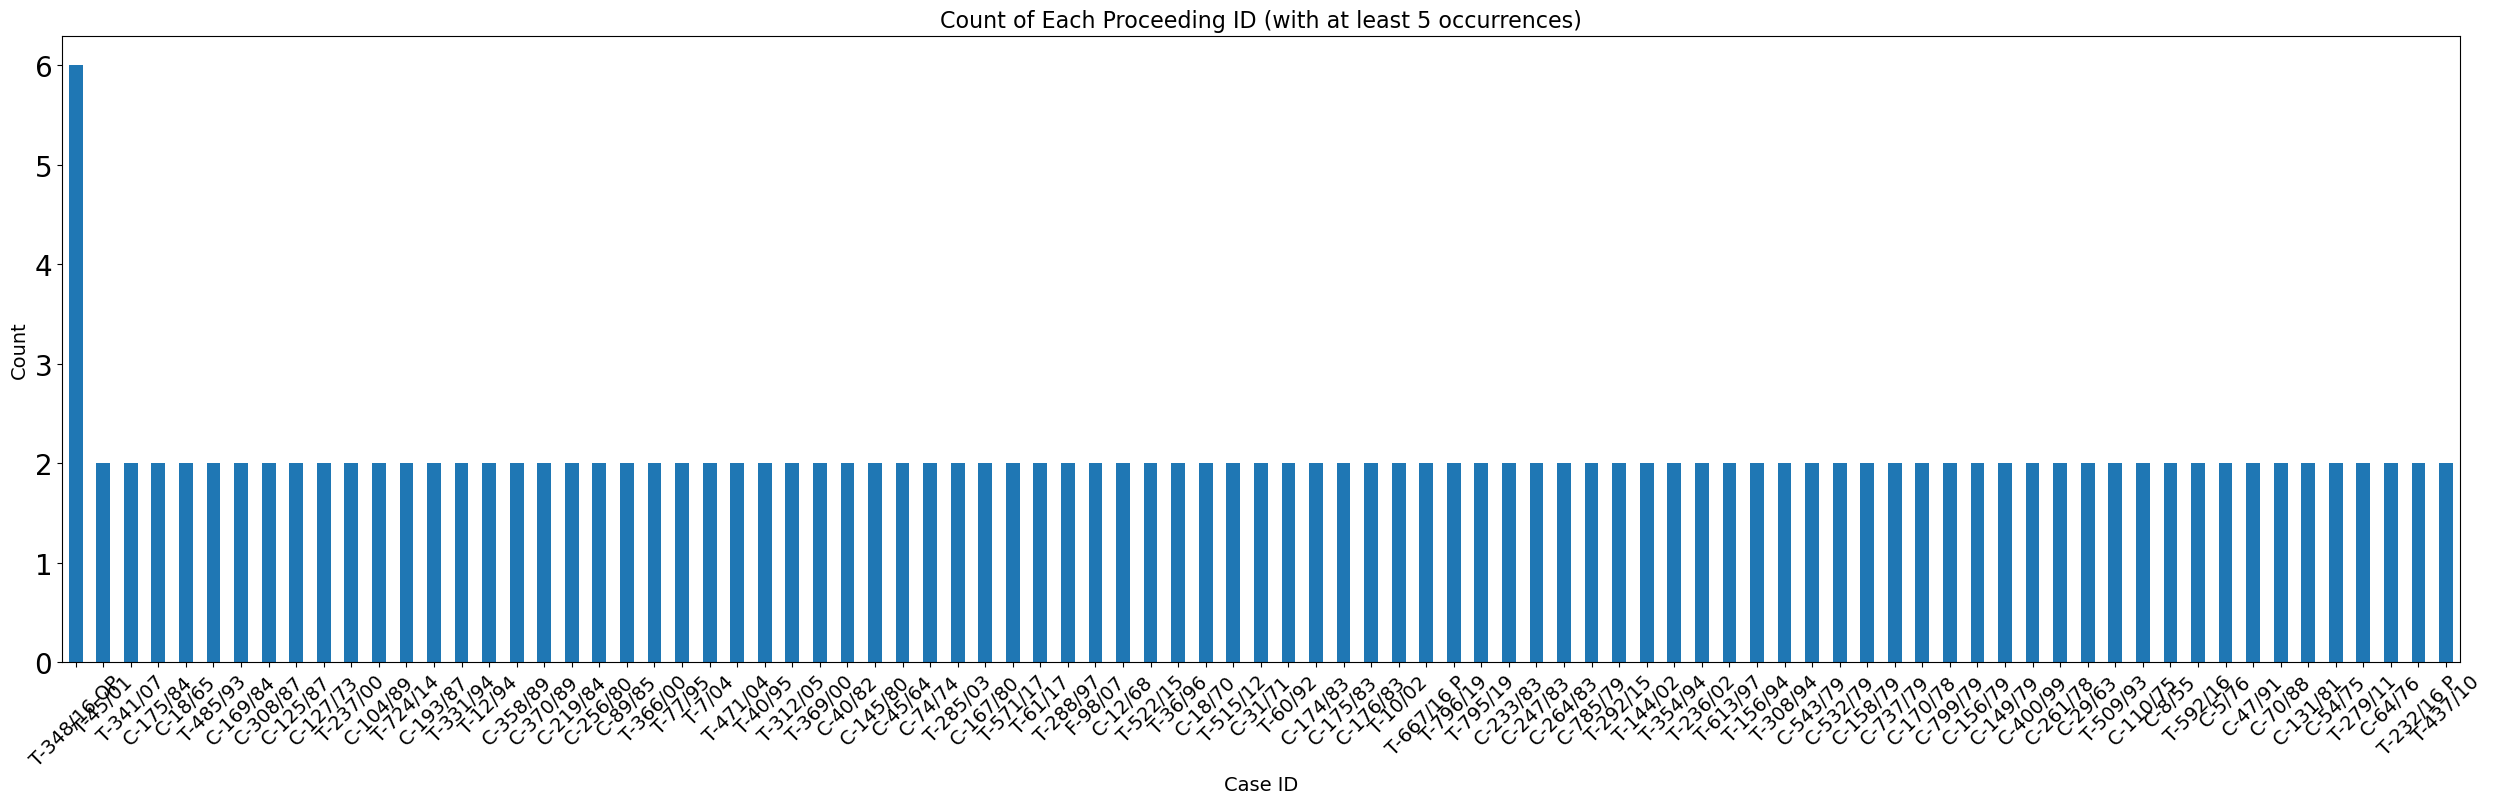

In [444]:
# Counting occurrences of each proceeding ID
case_id_counts = full_iuropa['cjeu_proceeding_id'].value_counts()

# Filtering for cases present more than three times
filtered_case_id_counts = case_id_counts[case_id_counts > 1]

plt.figure(figsize=(25, 8))  # Adjust the width and height as needed
filtered_case_id_counts.plot(kind='bar')
plt.xlabel('Case ID', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Each Proceeding ID (with at least 5 occurrences)', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=20)
plt.tight_layout()

plt.xticks(fontsize=14)

plt.savefig('proceeding_id_count.jpg', dpi=300)
plt.show()


In [445]:
# Reset index of the DataFrame
full_iuropa = full_iuropa.reset_index(drop=True)

It's worth checking if all those cases should indeed by recorded twice

By checking the iuropa_full_judgments table we can see if the cases are indeed mentioned twice and which ECLI numbers correspond

In [ ]:
test_table = iuropa_full_judgments['cjeu_proceeding_id'].str.contains('## insert cjeu_proceeding_id ##', na=False)

# Selecting rows based on the filtered condition
case_table =  iuropa_full_judgments[test_table]

pd.set_option('display.max_columns', None)

case_table

In [371]:
# Finding rows where 'cjeu_proceeding_id' contains '## insert cjeu_proceeding_id ##'
test_table2 = full_iuropa['cjeu_proceeding_id'].str.contains('## insert cjeu_proceeding_id ##', na=False)

# Select rows based on the filtered condition
case_table2 = full_iuropa[test_table2]

case_table2


court_id          court  case_year cjeu_proceeding_id  \
16383         2  General Court       2014           T-724/14   
16384         2  General Court       2014           T-724/14   

                                         proceeding_name decision_type  \
16383  European Children's Fashion Association and In...      judgment   
16384  European Children's Fashion Association and In...      judgment   

      decision_date proceeding_date  duration_days  duration_months  \
16383    2016-10-05      2014-10-07            729            23.93   
16384    2016-10-05      2014-10-07            729            23.93   

       count_joined_proceedings list_joined_proceedings  count_on_appeal  \
16383                         1                T-724/14                0   
16384                         1                T-724/14                0   

      list_on_appeal  count_appeal_of  list_appeal_of  \
16383           none                0  not applicable   
16384           none                0  not applicable   

       count_authentic_languages list_authentic_languages  count_procedures  \
16383                          1                   French                 1   
16384                          1                   French                 1   

          list_procedures  is_preliminary_ruling  is_urgent_procedure  \
16383  arbitration clause                      0                    0   
16384  arbitration clause                      0                    0   

       is_direct_action  is_appeal  is_staff_case  is_referred_back  \
16383                 0          0              0                 0   
16384                 0          0              0                 0   

       count_referring_member_states list_referring_member_states  \
16383                              0               not applicable   
16384                              0               not applicable   

       count_observers  list_observers iuropa_formation_id      formation  \
16383                0  not applicable              F:T:03  Third Chamber   
16384                0  not applicable              F:T:03  Third Chamber   

       count_judges                       list_judges  \
16383             3  Bieliūnas; Forrester; Papasavvas   
16384             3  Bieliūnas; Forrester; Papasavvas   

      iuropa_judge_rapporteur_id judge_rapporteur  count_advocates_general  \
16383                    J:UK:13        Forrester                        0   
16384                    J:UK:13        Forrester                        0   

      list_advocates_general  count_opinions   list_opinions  \
16383         not applicable               0  not applicable   
16384         not applicable               0  not applicable   

       count_cited_documents  \
16383                     21   
16384                     21   

                                    list_cited_documents  \
16383  12008E/PRO/03, 12008E263, 12008E272, 12008E296...   
16384  12008E/PRO/03, 12008E263, 12008E272, 12008E296...   

       count_subject_keywords                     list_subject_keywords  \
16383                       1  Education, vocational training and youth   
16384                       1  Education, vocational training and youth   

       count_directory_codes list_directory_codes joined_proceedings_1  \
16383                      0        not available             T-724/14   
16384                      0        not available             T-724/14   

      joined_proceedings_2 joined_proceedings_3 joined_proceedings_4  \
16383                  NaN                  NaN                  NaN   
16384                  NaN                  NaN                  NaN   

      joined_proceedings_5 joined_proceedings_6 joined_proceedings_7  \
16383                  NaN                  NaN                  NaN   
16384                  NaN                  NaN                  NaN   

      joined_proceedings_8 joined_proceedings_9 joined_proceedings_10  \
16383                  NaN    

In [ ]:
# We don't need to see all columns
selected_columns = ['cjeu_proceeding_id', 'list_procedures', 'AG opinion', 'order', 'judgment', 'AG view']
case_table_subset = case_table2[selected_columns]
case_table_subset

Now we he have to check the text in the requiered columns (judgment = 4) to match the date with the decision date in the iuropa_full_judgments table

In [ ]:
case_table_subset.iloc[0,4]

In [ ]:
case_table_subset.iloc[1,3]

Now we now all info, we can adapt the full_iuropa table

In [446]:
# References to the hand-selected texts based on the cjeu_case_proceeding and ecli
replacements = {
    'Decisions_By_Years/New/T 341 07.txt': 10791,
    'Decisions_By_Years/New/C 175 84.txt': 2012,
    'Decisions_By_Years/New/C 18 65.txt': 194,
    'Decisions_By_Years/New/T 45 01.txt': 7129,
    'Decisions_By_Years/New/T 485 93.txt': 4095,
    'Decisions_By_Years/New/C 169 84.txt': 1995,
    'Decisions_By_Years/New/C 308 87.txt': 2694,
    'Decisions_By_Years/New/C 125 87.txt': 2682,
    'Decisions_By_Years/New/C 127 73.txt': 542,
    'Decisions_By_Years/New/T 237 00.txt': 6592,
    'Decisions_By_Years/New/C 104 89.txt': 3114,
    'Decisions_By_Years/New/C 193 87.txt': 2661,
    'Decisions_By_Years/New/T 331 94.txt': 4506,
    'Decisions_By_Years/New/T 12 94.txt': 4513,
    'Decisions_By_Years/New/C 358 89.txt': 3139,
    'Decisions_By_Years/New/C 370 89.txt': 3141,
    'Decisions_By_Years/New/C 219 84.txt': 2014,
    'Decisions_By_Years/New/C 256 80.txt': 1316,
    'Decisions_By_Years/New/C 89 85.txt': 2251,
    'Decisions_By_Years/New/T 366 00.txt': 6568,
    'Decisions_By_Years/New/T 77 95.txt': 4878,
    'Decisions_By_Years/New/T 7 04.txt': 8629,
    'Decisions_By_Years/New/T 471 04.txt': 8634,
    'Decisions_By_Years/New/T 40 95.txt': 4861,
    'Decisions_By_Years/New/T 312 05.txt': 9100,
    'Decisions_By_Years/New/T 369 00.txt': 6562,
    'Decisions_By_Years/New/C 40 82.txt': 1617,
    'Decisions_By_Years/New/C 145 80.txt': 1318,
    'Decisions_By_Years/New/C 45 64.txt': 149,
    'Decisions_By_Years/New/C 74 74.txt': 609,
    'Decisions_By_Years/New/T 285 03.txt': 7929,
    'Decisions_By_Years/New/C 167 80.txt': 1328,
    'Decisions_By_Years/New/T 288 97.txt': 5459,
    'Decisions_By_Years/New/F 98 07.txt': 10361,
    'Decisions_By_Years/New/C 12 68.txt': 270,
    'Decisions_By_Years/New/T 36 96.txt': 5290,
    'Decisions_By_Years/New/C 18 70.txt': 359,
    'Decisions_By_Years/New/T 515 12.txt': 14534,
    'Decisions_By_Years/New/T 515 12 RENV.txt': 14535,
    'Decisions_By_Years/New/C 31 71.txt': 424,
    'Decisions_By_Years/New/T 60 92.txt': 3911,
    'Decisions_By_Years/New/C 174 83.txt': 1863, 
    'Decisions_By_Years/New/C 175 83.txt': 1860,
    'Decisions_By_Years/New/C 176 83.txt': 1858,
    'Decisions_By_Years/New/T 10 02.txt': 7469,
    'Decisions_By_Years/New/C 233 83.txt': 1844,
    'Decisions_By_Years/New/C 247 83.txt': 1831,
    'Decisions_By_Years/New/C 264 83.txt':1835,
    'Decisions_By_Years/New/C 785 79.txt': 1139,
    'Decisions_By_Years/New/T 292 15.txt': 17235,
    'Decisions_By_Years/New/T 144 02.txt': 7530,
    'Decisions_By_Years/New/T 354 94.txt': 4560,
    'Decisions_By_Years/New/T 236 02.txt': 7574,
    'Decisions_By_Years/New/T 613 97.txt': 5437,
    'Decisions_By_Years/New/T 308 94.txt': 4558,
    'Decisions_By_Years/New/C 543 79.txt': 1197,
    'Decisions_By_Years/New/C 532 79.txt': 1196,
    'Decisions_By_Years/New/C 158 79.txt': 1189,
    'Decisions_By_Years/New/C 737 79.txt': 1165,
    'Decisions_By_Years/New/C 170 78.txt': 1015,
    'Decisions_By_Years/New/C 799 79.txt': 1183,
    'Decisions_By_Years/New/C 156 79.txt': 1181,
    'Decisions_By_Years/New/C 149 79.txt': 1173,
    'Decisions_By_Years/New/C 400 99.txt': 6168,
    'Decisions_By_Years/New/C 261 78.txt': 1027,
    'Decisions_By_Years/New/C 29 63.txt': 112,
    'Decisions_By_Years/New/T 509 93.txt': 4100,
    'Decisions_By_Years/New/C 110 75.txt': 694,
    'Decisions_By_Years/New/C 8 55.txt': 8,
    'Decisions_By_Years/New/C 5 76.txt': 787,
    'Decisions_By_Years/New/C 47 91.txt': 3638,
    'Decisions_By_Years/New/C 70 88.txt': 2861,
    'Decisions_By_Years/New/C 131 81.txt': 1441,
    'Decisions_By_Years/New/C 54 75.txt': 692,
    'Decisions_By_Years/New/T 279 11.txt': 13423,
    'Decisions_By_Years/New/C 64 76.txt': 792,
}

full_iuropa = full_iuropa.reset_index(drop=True)

# Loop through replacements
for file_path, row_index in replacements.items():
    # Read the content of the text file
    with open(file_path, 'r', encoding="utf-8") as file:
        replacement_text = file.read()

    # Replace the text in the 'judgment' column at the specified row index
    full_iuropa.at[row_index, 'judgment'] = replacement_text

full_iuropa = full_iuropa.reset_index(drop=True)
    
# Replace other values
full_iuropa.at[17771, 'judgment'] = full_iuropa.at[17772, 'judgment']
full_iuropa.at[16383, 'judgment'] = full_iuropa.at[16384, 'judgment']
full_iuropa.at[19127, 'judgment'] = full_iuropa.at[19126, 'judgment']
full_iuropa.at[17390, 'judgment'] = full_iuropa.at[17389, 'judgment']
full_iuropa.at[20724, 'judgment'] = full_iuropa.at[20723, 'judgment']
full_iuropa.at[20726, 'judgment'] = full_iuropa.at[20725, 'judgment']
full_iuropa.at[12763, 'judgment'] = full_iuropa.at[12764, 'judgment']



# update specific row
update_values = {
    'cjeu_proceeding_id': 'T-515/12 RENV',
    'list_joined_proceedings': 'T-515/12 RENV',
    'list_judges': 'Bieliūnas; Forrester; Papasavvas',
    'proceeding_suffix': 'RENV',
    'duration_months': 10.52,
    'count_on_appeal': 0,
    'list_on_appeal': 'none',
    'count_directory_codes': 2,
    'list_directory_codes': '4.11.03.02.05, 4.11.03.02.07.05',
    'joined_proceedings_1': 'T-515/12 RENV',
    'cited_documents_10': '62014TJ0201',
    'on_appeal_1': 'none',
    'directory_codes_1': pd.NA,
    'birth_year_judges_2': 1945,
    'start_date_judges_2': '2015-10-07',
    'end_date_judges_2': '2020-01-31',
    'was_judge_judges_2': 1,
    'was_academic_judges_2': 1
}

# Assign values to the specified row using the 'at' accessor
for col, val in update_values.items():
    full_iuropa.at[14535, col] = val
    
full_iuropa = full_iuropa.reset_index(drop=True)

# Drop unnecessary columns    
full_iuropa.drop([4549, 17594, 17770, 17772, 17774, 17775, 18847, 19126, 17974, 17389, 17686], inplace=True)


### Summary

#### Summary statistics

In [ ]:
full_iuropa_summary = full_iuropa.describe()
print(full_iuropa_summary.iloc[:, 2:])

#### Number of unique proceedings

In [450]:
print('Total number of proceedings:', len(full_iuropa['cjeu_proceeding_id']))
print('Number of unique proceedings:', len(full_iuropa['cjeu_proceeding_id'].unique()))

Total number of proceedings: 22499
Number of unique proceedings: 22420


### Plots

#### General

In [451]:
numerical_columns = full_iuropa.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns

In [ ]:
snum_plots = len(numerical_columns)
num_cols = 2
num_rows = -(-num_plots // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

axes = axes.flatten()

# Histograms for each numerical variable
for i, col in enumerate(numerical_columns):
    ax = axes[i]
    full_iuropa[col].plot(kind='hist', ax=ax, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

for j in range(num_plots, num_cols*num_rows):
    fig.delaxes(axes[j])

plt.grid(axis='y')
plt.tight_layout()

# Show plot
plt.show()


#### Distribution of case years

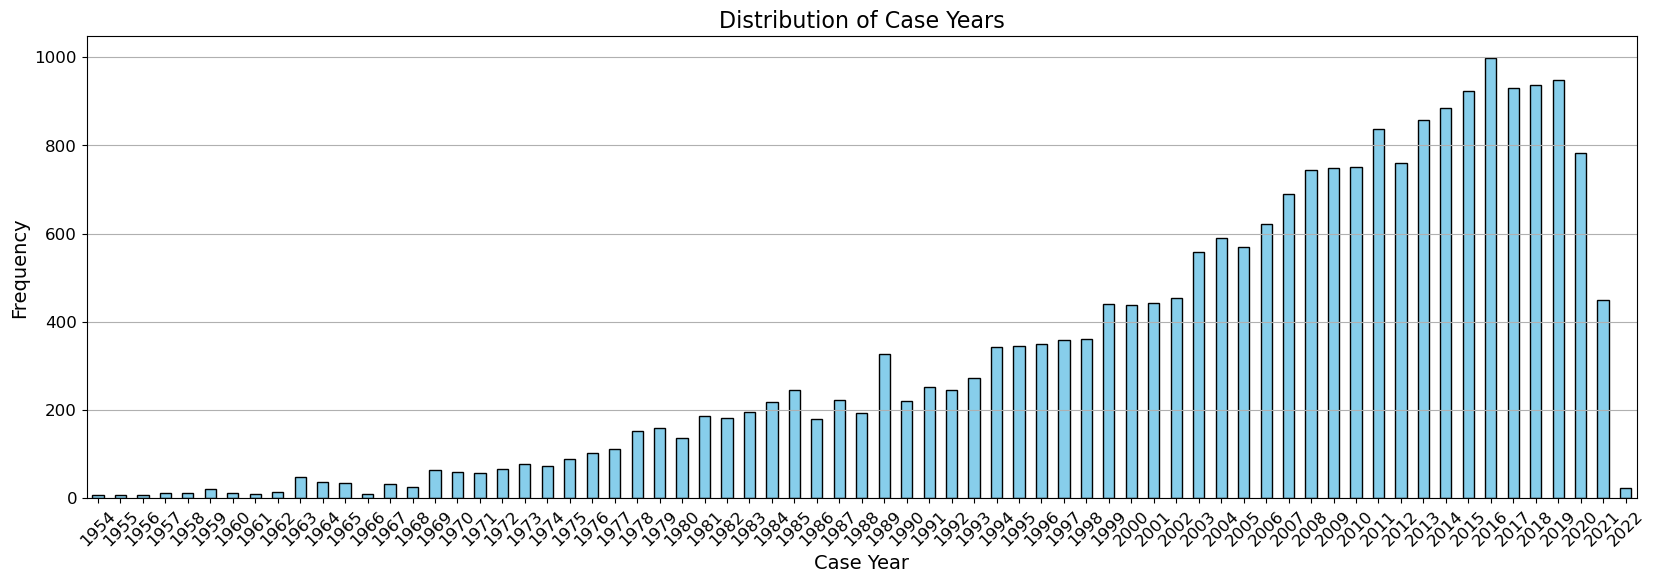

In [453]:
case_year_column = full_iuropa['case_year']

# Counting frequency of each year
year_counts = case_year_column.value_counts().sort_index()

# Bar plot
plt.figure(figsize=(20, 6))
year_counts.plot(kind='bar', color=colour_codes[0], edgecolor='black')
plt.xlabel('Case Year', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y')
plt.title('Distribution of Case Years', fontsize=16)

plt.savefig("Distribution_of_case_years_2004_2022.png", dpi=300)

plt.show()

#### Distribution of case duration

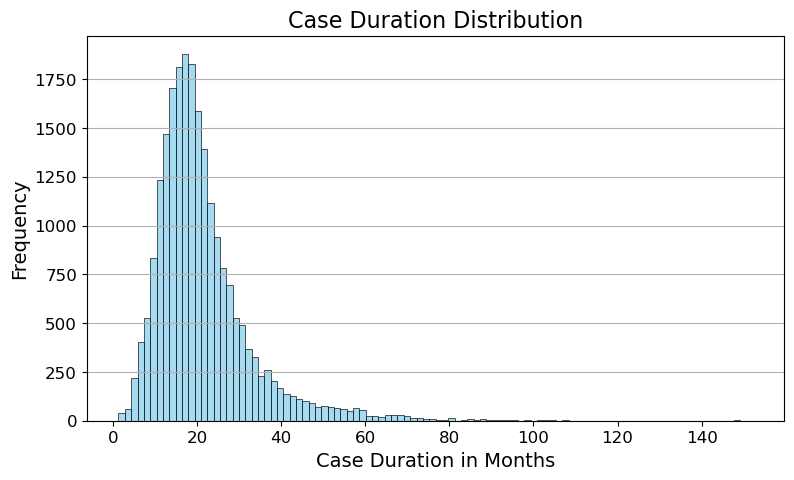

In [454]:
plt.figure(figsize=(9, 5))
sns.histplot(data=full_iuropa, x='duration_months', bins=100, kde=False, color=colour_code[0])
plt.xlabel('Case Duration in Months', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y')
plt.title('Case Duration Distribution', fontsize=16)

plt.savefig('histogram_duration_months.jpg', dpi=300)
plt.show()

In [455]:
mean_iuropa = full_iuropa['duration_months'].mean()
print("Mean months:", mean_iuropa)


Mean months: 21.342067647451


##### Min and max values in duration

In [456]:
print("Minimum value:", full_iuropa['duration_months'].min())
print("Maximum value:", full_iuropa['duration_months'].max())

Minimum value: 1.29
Maximum value: 152.13


##### Checking for outliers in duration

In [ ]:
# Calculating first and third quartiles
Q1 = full_iuropa['duration_months'].quantile(0.25)
Q3 = full_iuropa['duration_months'].quantile(0.75)

# Calculating interquartile range (IQR)
IQR = Q3 - Q1

# Defining lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Finding outliers
outliers = full_iuropa[(full_iuropa['duration_months'] < lower_bound) | (full_iuropa['duration_months'] > upper_bound)]

print(outliers['duration_months'].sort_values())

#### Courts

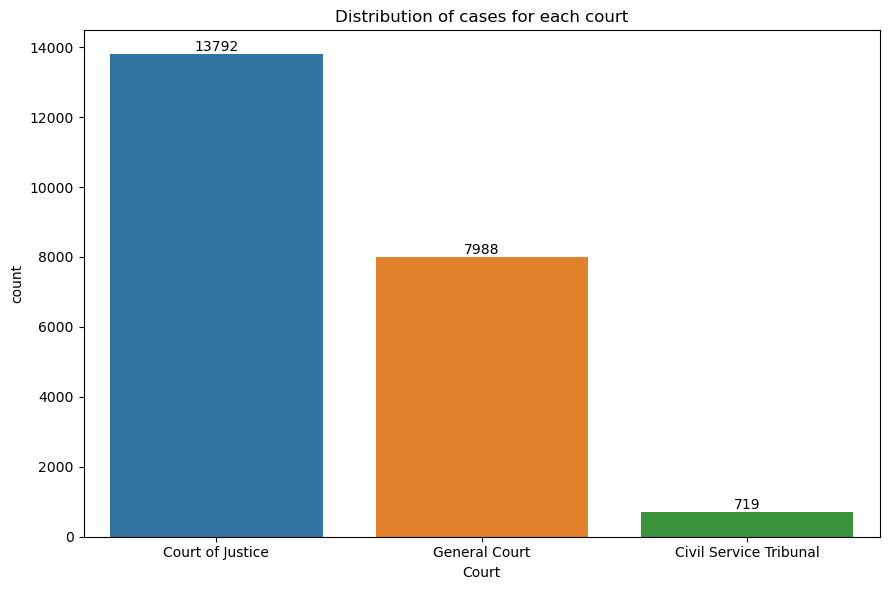

In [458]:
court_names = {
    1: 'Court of Justice',
    2: 'General Court',
    3: 'Civil Service Tribunal'
}

plt.figure(figsize=(9, 6))
ax = sns.countplot(data=full_iuropa, x='court_id', palette=[colour_codes[i] for i in range(3)])
plt.title('Distribution of cases for each court')
plt.xlabel('Court')
plt.xticks(ticks=[0, 1, 2], labels=[court_names[i] for i in range(1, 4)])  

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() + 0.5, '%d' % int(p.get_height()),
            fontsize=10, color='black', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('Distribution_of_cases_for_each_court.png', dpi=300) 
plt.show()

plt.show()


The Civil Service Tribunal has treated many cases less.

*The Treaty of Nice had provided in 2003 for the possibility of establishing specialised courts at EU level, and the Council of the European Union thus decided, on 2 November 2004, to establish the Civil Service Tribunal. Its task, which until then had been performed by the General Court of the European Union, was to determine disputes between the European Union and EU staff. In 2015, in view of the increase in litigation and the excessive length of proceedings in cases being dealt with in the General Court, the EU legislature decided to gradually increase the number of Judges at the General Court to 56 and to transfer to it the jurisdiction of the Civil Service Tribunal, which was dissolved on 1 September 2016.*

#### Document types

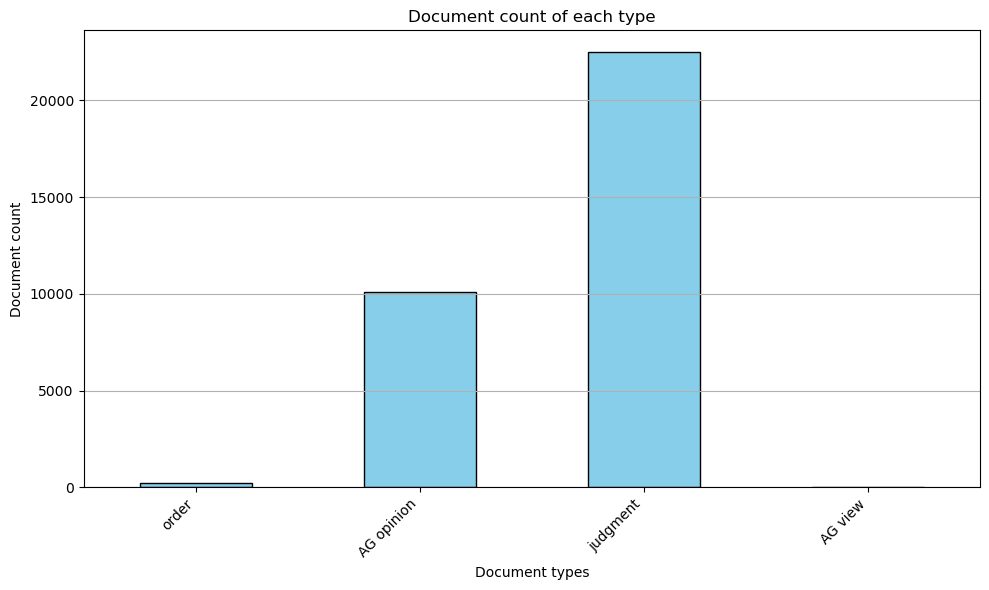

In [459]:
document_columns = ['order', 'AG opinion', 'judgment', 'AG view']
'
column_counts = full_iuropa[document_columns].apply(lambda x: x[x != 'not applicable'].count())

plt.figure(figsize=(10, 6))
column_counts.plot(kind='bar', color=colour_codes[0], edgecolor='black')
plt.xlabel('Document types')
plt.ylabel('Document count')
plt.title('Document count of each type')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Number of judges

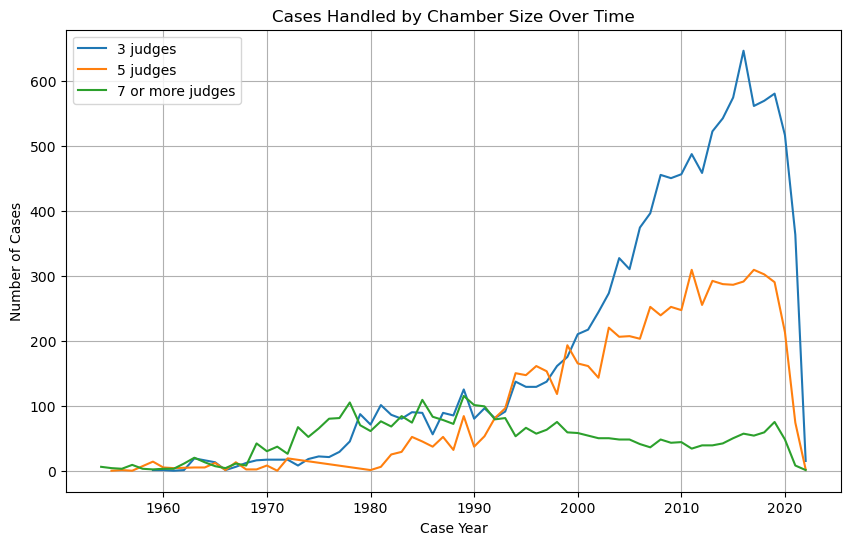

In [460]:
# Filtering data based on chamber size
chamber_size_3 = full_iuropa[full_iuropa['count_judges'] == 3]
chamber_size_5 = full_iuropa[full_iuropa['count_judges'] == 5]
chamber_size_7_or_more = full_iuropa[full_iuropa['count_judges'] >= 7]

# Grouping data by case year + counting
cases_by_year_3 = chamber_size_3.groupby('case_year').size()
cases_by_year_5 = chamber_size_5.groupby('case_year').size()
cases_by_year_7_or_more = chamber_size_7_or_more.groupby('case_year').size()

plt.figure(figsize=(10, 6))

# Plot for 3 judges
plt.plot(cases_by_year_3.index, cases_by_year_3.values, label='3 judges', color=colour_codes[0])

# Plot for 5 judges
plt.plot(cases_by_year_5.index, cases_by_year_5.values, label='5 judges', color=colour_codes[1])

# Plot for 7 or more judges
plt.plot(cases_by_year_7_or_more.index, cases_by_year_7_or_more.values, label='7 or more judges', color=colour_codes[2])

plt.title('Cases Handled by Chamber Size Over Time')
plt.xlabel('Case Year')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.show()


#### Chambers

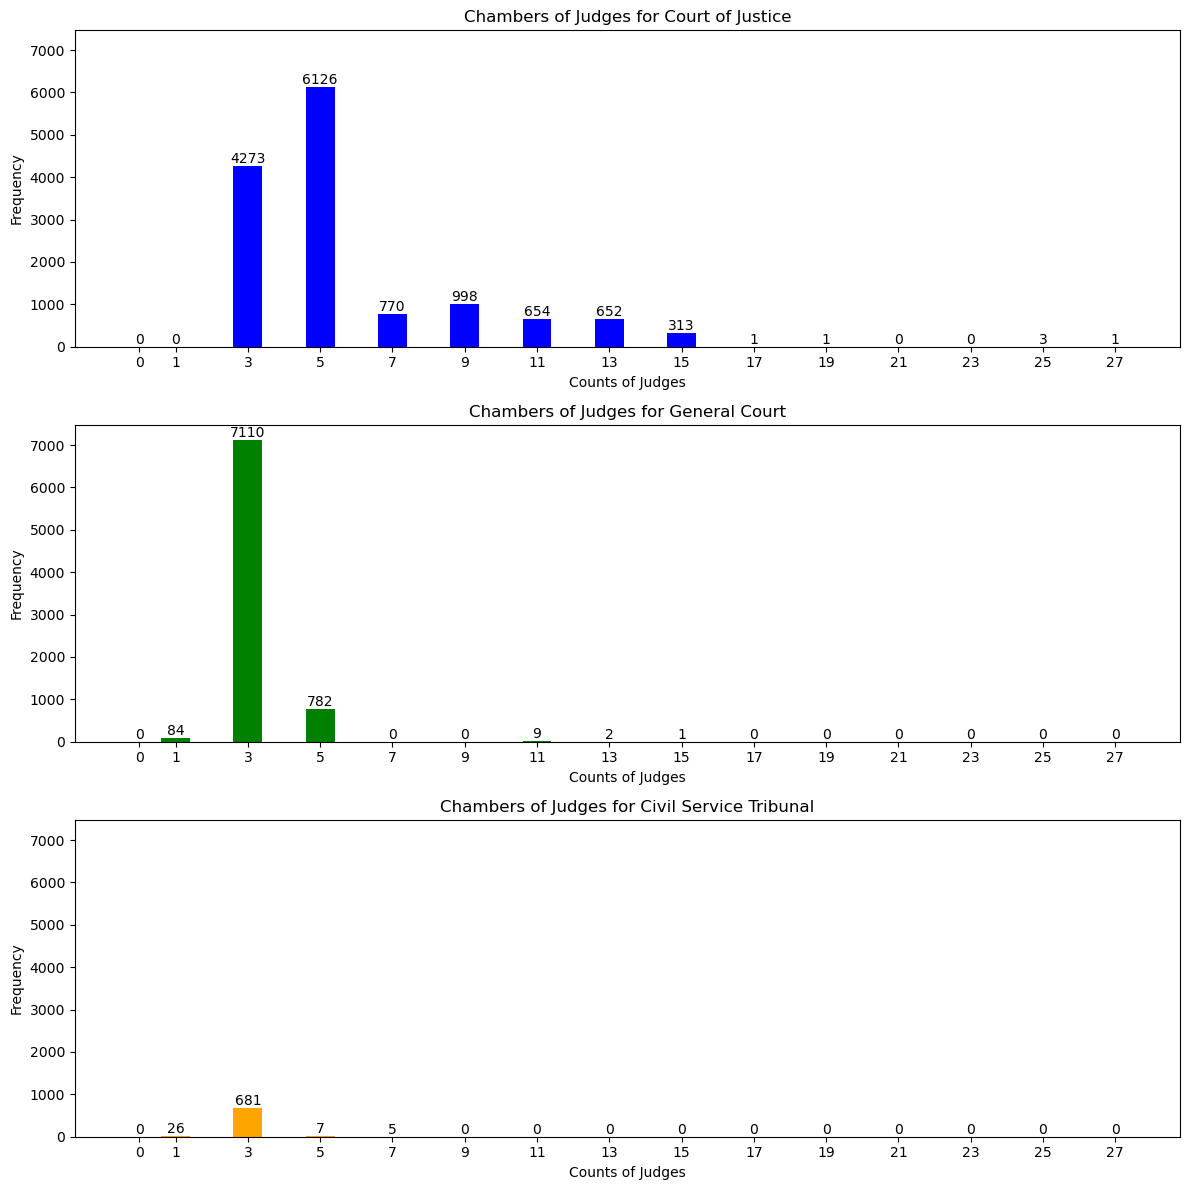

In [461]:
# Grouping by 'court' and 'count_judges', then counting occurrences
count_judges_counts = full_iuropa.groupby(['court_id', 'count_judges']).size().reset_index(name='counts')

# Defining specified values for the x-axis (= possible chambers)
specified_values = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), sharey=True)

# Looping through courts
colors = [colour_codes[0], colour_codes[1], colour_codes[2]]
for i, court_id in enumerate([1,2,3]):
    
    # Filtering data for current court
    court_data = count_judges_counts[count_judges_counts['court_id'] == court_id]

    # Creating df with only the specified count_judges values
    specified_count_judges_df = pd.DataFrame({'count_judges': specified_values})

    # Merging with court_data to include only specified values and filling missing counts with 0
    court_data_merged = pd.merge(specified_count_judges_df, court_data, on='count_judges', how='left').fillna(0)

    bars = axes[i].bar(court_data_merged['count_judges'], court_data_merged['counts'], color=colors[i])
    axes[i].set_xlabel('Counts of Judges')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Chambers of Judges for {court_names[court_id]}')

    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width() / 2, height, int(height),
                     ha='center', va='bottom', color='black', fontsize=10)

    axes[i].set_xticks(specified_values)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


#### Languages used

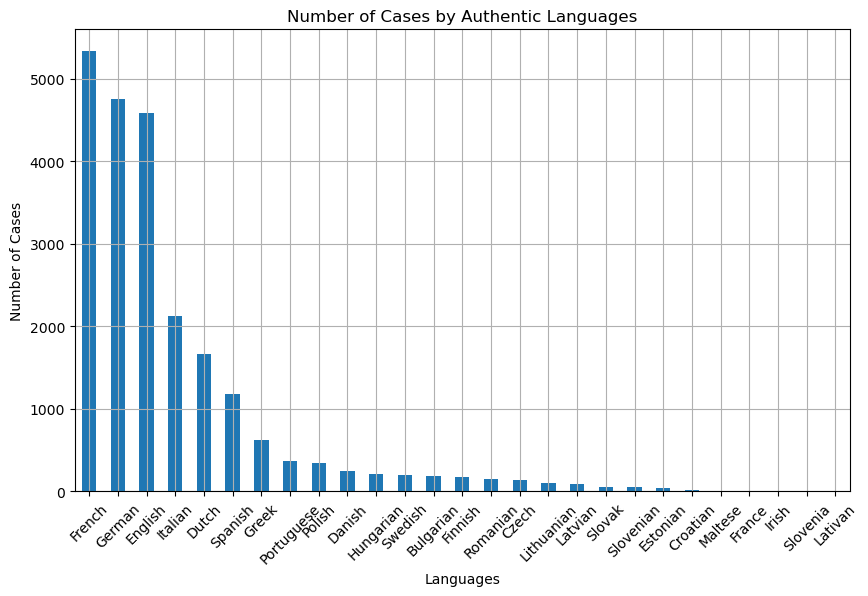

In [462]:
# Splitting list_authentic_languages column and making each language
languages_df = full_iuropa['list_authentic_languages'].str.split(',').explode()

# Counting occurrences
language_counts = languages_df.str.strip().value_counts()

plt.figure(figsize=(10, 6), colour_codes[0])
language_counts.plot(kind='bar')
plt.title('Number of Cases by Authentic Languages')
plt.xlabel('Languages')
plt.ylabel('Number of Cases')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


French is highest: The deliberations are held in French = the working language of the Court 

#### Correlations


The code should not train on the experience of judge 27, because full court cases are always longer. This will bias the data

Duration_months should be excluded

In [463]:
excluded_columns = [f'days_experience_judge_{i}' for i in range(6, 28)] + ['duration_months']
full_iuropa_corr = full_iuropa.drop(columns=excluded_columns, errors='ignore')


In [ ]:
# Selecting all numerical columns
numerical_columns2 = full_iuropa_corr.select_dtypes(include=['float64', 'int64', 'float32', 'int32'])

correlation_matrix = numerical_columns2.corr()

In [465]:
# Selecting correlations with 'duration_days'
duration_corr = correlation_matrix['duration_days'].drop('duration_days')  # no self-correlation

# Extracting top 20 correlations (in absolute numbers)
N = 20 
top_corr_with_duration = duration_corr.abs().nlargest(N)

print("Top Correlations with 'duration_days':")
for feature, correlation in top_corr_with_duration.items():
    print(f"{feature}: {correlation}")


Top Correlations with 'duration_days':
count_cited_documents: 0.38767377736140823
count_directory_codes: 0.2715554033267317
count_advocates_general: 0.26816714984780254
is_direct_action: 0.2491324586952776
count_on_appeal: 0.248762229433129
is_preliminary_ruling: 0.22670927625075765
count_referring_member_states: 0.2249894526446506
court_id: 0.22495024626624957
days_experience_judge_5: 0.21352408072700405
judge_from_1905-1910: 0.2083128811251301
days_experience_judge_2: 0.2082899939928614
judge_from_1910-1915: 0.20754033118408724
days_experience_judge_1: 0.202109586683799
judge_from_1915-1920: 0.20086370902237885
days_experience_judge_3: 0.1966071230738101
count_procedures: 0.19531663748442257
judge_former_politician: 0.150757997014943
English: 0.142660606238893
count_observers: 0.12531786765680472
days_experience_judge_4: 0.12485845750072963


# Rearranging data

The object columns take too much space (too many dummies) which makes training hard. Reducing them to bools makes them more comprehensible.

Also, info about the AG's and JR was not yet included

### AG's

#### Incuding info about AG's

In [481]:
# Getting the list of judges in iuropa_judgments
ag_cols = [col for col in full_iuropa.columns if 'advocates_' in col]

pbar = tqdm(total=len(full_iuropa)) # Progress bar

new_columns_data = []

for i, row in full_iuropa.iterrows():
    
    row_data = {}
    
    for jcol in ag_cols:
        ag_last_name = row[jcol]
        
        ag_info = iuropa_judges[iuropa_judges['last_name_label'] == ag_last_name]
        
        if not ag_info.empty:
            for icol in iuropa_judges.columns:
                if icol != 'last_name_label':
                    new_col_name = f'{icol}_{jcol}'
                    row_data[new_col_name] = ag_info[icol].values[0]
                    
    new_columns_data.append(row_data)
    pbar.update()

pbar.close()

# Creating a new df from new_columns_data
new_columns = pd.DataFrame(new_columns_data, index=full_iuropa.index)

# Concatenating it with the original df
full_iuropa = pd.concat([full_iuropa, new_columns], axis=1)


100%|██████████| 22499/22499 [01:30<00:00, 248.05it/s]


In [482]:
full_iuropa.drop(columns = ['member_state_list_advocates_general', 'birth_year_list_advocates_general', 'start_date_list_advocates_general', 'end_date_list_advocates_general'], inplace=True)

#### Combining AG characteristics

In [483]:
# Defining function to sum up columns for a specific category
def sum_columns(df, category):
    columns = [col for col in df.columns if col.startswith(category)]
    return df[columns].sum(axis=1)

# advocates_general_1
# Summing up the 'was_' columns
full_iuropa['ag1_former_judge'] = sum_columns(full_iuropa, 'was_judge_advocates_general_1')
full_iuropa['ag1_former_academic'] = sum_columns(full_iuropa, 'was_academic_advocates_general_1')
full_iuropa['ag1_former_civil_servant'] = sum_columns(full_iuropa, 'was_civil_advocates_general_1')
full_iuropa['ag1_former_lawyer'] = sum_columns(full_iuropa, 'was_lawyer_advocates_general_1')
full_iuropa['ag1_former_politician'] = sum_columns(full_iuropa, 'was_politician_advocates_general_1')


# advocates_general_2
# Summing up the 'was_' columns
full_iuropa['ag2_former_judge'] = sum_columns(full_iuropa, 'was_judge_advocates_general_2')
full_iuropa['ag2_former_academic'] = sum_columns(full_iuropa, 'was_academic_advocates_general_2')
full_iuropa['ag2_former_civil_servant'] = sum_columns(full_iuropa, 'was_civil_advocates_general_2')
full_iuropa['ag2_former_lawyer'] = sum_columns(full_iuropa, 'was_lawyer_advocates_general_2')
full_iuropa['ag2_former_politician'] = sum_columns(full_iuropa, 'was_politician_advocates_general_2')


def sum_columns2(df, col1, col2):
    return df[col1] + df[col2]

# Summing up the 'is_female' column and handling NaN values
full_iuropa['female_ag'] = full_iuropa[['is_female_advocates_general_1', 'is_female_advocates_general_2']].sum(axis=1, skipna=True)


# Dropping original columns
columns_to_drop = [col for col in full_iuropa.columns if col.startswith(('was_', 'is_female_', 'is_current_'))]
full_iuropa.drop(columns=columns_to_drop, inplace=True)

#### Sorting AG birth years

In [484]:
# Defining year bins
bins = pd.interval_range(start=1875, end=1980, freq=5)

bin_counts_df = pd.DataFrame(index=full_iuropa.index, columns=bins)

for index, row in full_iuropa.iterrows():
    
    # Counting number of judges falling into each bin for the current row
    bin_counts = pd.cut(row.filter(like='birth_year_advocates_'), bins=bins).value_counts()
    
    # Updating the bin_counts_df with the counts for the current row
    bin_counts_df.loc[index] = bin_counts

# Dropping original birth year columns
full_iuropa = full_iuropa.drop(columns=full_iuropa.filter(like='birth_year_advocates_').columns)

# Concatenating original df with the bin_counts_df
full_iuropa = pd.concat([full_iuropa, bin_counts_df], axis=1)

# Changing column names
columns = full_iuropa.columns[-21:]

# Formatting column names
def format_column_name(column):
    parts = str(column).strip('(]').split(', ')
    start_year = parts[0]
    end_year = parts[1]
    return f"ag_from_{start_year}-{end_year}"

new_columns = [format_column_name(column) for column in columns]

# Renaming columns
rename_dict = dict(zip(columns, new_columns))

full_iuropa = full_iuropa.rename(columns=rename_dict)


In [485]:
columns_to_convert = [
    'ag_from_1875-1880', 'ag_from_1880-1885', 'ag_from_1885-1890', 'ag_from_1890-1895',
    'ag_from_1895-1900', 'ag_from_1900-1905', 'ag_from_1905-1910', 'ag_from_1910-1915',
    'ag_from_1915-1920', 'ag_from_1920-1925', 'ag_from_1925-1930', 'ag_from_1930-1935',
    'ag_from_1935-1940', 'ag_from_1940-1945', 'ag_from_1945-1950', 'ag_from_1950-1955',
    'ag_from_1955-1960', 'ag_from_1960-1965', 'ag_from_1965-1970', 'ag_from_1970-1975',
    'ag_from_1975-1980'
]

# Convert to int32
full_iuropa[columns_to_convert] = full_iuropa[columns_to_convert].astype('int32')


#### Sorting AG's member states

In [486]:
# Initialising empty df
counts_df = pd.DataFrame(columns=[f"ag_from_{state}" for state in member_states])

# Progress bar
iterator = tqdm(full_iuropa.iterrows(), total=len(full_iuropa), desc="Processing Rows")

for index, row in iterator:
    
    row_counts = {state: 0 for state in member_states}
    
    for col in row.index:
        if col.startswith('member_state_advocates_'):
            
            state = row[col]
            
            # If value is not NaN & is in the member_states list, adding 1 to the count
            if pd.notnull(state) and state != 'not available' and state in member_states:
                row_counts[state] += 1
    
        for state, count in row_counts.items():
            counts_df.at[index, f"ag_from_{state}"] = count

# Concatenating counts df with original df
full_iuropa = pd.concat([full_iuropa, counts_df], axis=1)

# Dropping original columns
full_iuropa.drop(full_iuropa.filter(like='member_state_advocates_').columns, axis=1, inplace=True)



Processing Rows: 100%|██████████| 22499/22499 [1:54:21<00:00,  3.28it/s]  


#### Calculating AG experience

In [515]:
# Progress bar
iterator = tqdm(full_iuropa.iterrows(), total=len(full_iuropa), desc="Processing Rows")

for index, row in iterator:
    
    for i in range(1, 3):  
        start_date_col = f'start_date_advocates_general_{i}'
        end_date_col = 'decision_date' # calculating experience until decision date, 
                                       # because an AG can give their opinion in cases that had already started 
                                       # before they did
        
        start_date_str = row[start_date_col]
        end_date_str = row[end_date_col]
        
        # CheckING if both start and end dates are not null and not 'not available'
        if pd.notnull(start_date_str) and pd.notnull(end_date_str) and \
                start_date_str != 'not available' and end_date_str != 'not available':
            
            # Converting start and end dates to datetime objects
            start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
            end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
            
            # Calculating experience in days
            experience_days = (end_date - start_date).days
            
            # Creating new experience column
            experience_col = f'days_experience_ag_{i}'
            full_iuropa.at[index, experience_col] = experience_days
            
# Dropping original columns
start_date_cols = [f'start_date_advocates_general_{i}' for i in range(1, 3)]
end_date_cols = [f'end_date_advocates_general_{i}' for i in range(1, 3)]
full_iuropa.drop(columns=start_date_cols + end_date_cols, inplace=True)


Processing Rows: 100%|██████████| 22499/22499 [00:04<00:00, 4540.04it/s]


### JR

#### Incuding info about Judge Rapporteur

In [522]:
# Progress bar
pbar = tqdm(total=len(full_iuropa))

new_columns_data = []

for i, row in full_iuropa.iterrows():
    
    judge_rap_last_name = row['judge_rapporteur']
    
    # Fetching info on the JR from iuropa_judges
    judge_rap_info = iuropa_judges[iuropa_judges['last_name_label'] == judge_rap_last_name]
    
    # Checking if information is found
    if not judge_rap_info.empty:
        
        row_data = {}
        
        for col in iuropa_judges.columns:
            if col != 'last_name_label':
                new_col_name = f'{col}_judge_rapporteur'
                row_data[new_col_name] = judge_rap_info[col].values[0]
                
        new_columns_data.append(row_data)
        
    else:
        # Appending NaN if information is not found
        row_data = {f'{col}_judge_rapporteur': np.nan for col in iuropa_judges.columns if col != 'last_name'}
        new_columns_data.append(row_data)
    
    pbar.update()

pbar.close()

new_columns = pd.DataFrame(new_columns_data, index=full_iuropa.index)

# Concatenating original df with the new columns
full_iuropa = pd.concat([full_iuropa, new_columns], axis=1)


100%|██████████| 22499/22499 [01:27<00:00, 256.05it/s] 


#### Combining JR characteristics

In [528]:
# Summing up the 'was_' columns
full_iuropa['jr_former_judge'] = sum_columns(full_iuropa, 'was_judge_judge_rapporteur')
full_iuropa['jr_former_academic'] = sum_columns(full_iuropa, 'was_academic_judge_rapporteur')
full_iuropa['jr_former_civil_servant'] = sum_columns(full_iuropa, 'was_civil_judge_rapporteur')
full_iuropa['jr_former_lawyer'] = sum_columns(full_iuropa, 'was_lawyer_judge_rapporteur')
full_iuropa['jr_former_politician'] = sum_columns(full_iuropa, 'was_politician_judge_rapporteur')

# Dropping original columns
columns_to_drop = [col for col in full_iuropa.columns if col.startswith(('was_', 'is_current_'))]
full_iuropa.drop(columns=columns_to_drop, inplace=True)


#### Sorting JR birth years

In [529]:
for index, row in full_iuropa.iterrows():
    
    bin_counts = pd.cut(row.filter(like='birth_year_judge_rapporteur'), bins=bins).value_counts()

    bin_counts_df.loc[index] = bin_counts

# Dropping original birth year columns
full_iuropa = full_iuropa.drop(columns=full_iuropa.filter(like='birth_year_judge_rapporteur').columns)

# Concatenating original df with bin_counts_df
full_iuropa = pd.concat([full_iuropa, bin_counts_df], axis=1)

# Changing column names
columns = full_iuropa.columns[-21:]

def format_column_name(column):
    parts = str(column).strip('(]').split(', ')
    start_year = parts[0]
    end_year = parts[1]
    return f"jr_from_{start_year}-{end_year}"

new_columns = [format_column_name(column) for column in columns]

rename_dict = dict(zip(columns, new_columns))

full_iuropa = full_iuropa.rename(columns=rename_dict)


In [530]:
# Convert to int32
full_iuropa[new_columns] = full_iuropa[new_columns].astype('int32')

#### Sorting JR's member states

In [531]:
counts_df = pd.DataFrame(columns=[f"jr_from_{state}" for state in member_states])

# Progress bar
iterator = tqdm(full_iuropa.iterrows(), total=len(full_iuropa), desc="Processing Rows")

for index, row in iterator:
    
    row_counts = {state: 0 for state in member_states}
    
    state = row['judge_rapporteur']
    
    if pd.notnull(state) and state != 'not available' and state in member_states:
        row_counts[state] += 1
    
    for state, count in row_counts.items():
        counts_df.at[index, f"jr_from_{state}"] = count

# Concatenating counts_df with original df
full_iuropa = pd.concat([full_iuropa, counts_df], axis=1)


Processing Rows: 100%|██████████| 22499/22499 [08:39<00:00, 43.28it/s]


In [532]:
columns_to_convert = [
    'jr_from_Belgium', 'jr_from_Luxembourg', 'jr_from_Italy', 'jr_from_Netherlands', 
    'jr_from_United Kingdom', 'jr_from_Germany', 'jr_from_France', 'jr_from_Denmark', 
    'jr_from_Greece', 'jr_from_Spain', 'jr_from_Portugal', 'jr_from_Ireland', 
    'jr_from_Austria', 'jr_from_Estonia', 'jr_from_Finland', 'jr_from_Romania', 
    'jr_from_Sweden', 'jr_from_Cyprus', 'jr_from_Latvia', 'jr_from_Malta', 
    'jr_from_Hungary', 'jr_from_Lithuania', 'jr_from_Poland', 'jr_from_Czech Republic', 
    'jr_from_Slovakia', 'jr_from_Slovenia', 'jr_from_Bulgaria', 'jr_from_Croatia'
]

# Convert to int32
full_iuropa[columns_to_convert] = full_iuropa[columns_to_convert].astype('int32')


#### Calculating JR experience

In [525]:
experience_df = pd.DataFrame(columns=['days_experience_jr'])

# Progress bar
iterator = tqdm(full_iuropa.iterrows(), total=len(full_iuropa), desc="Processing Rows")

for index, row in iterator:
    
    start_date_str = row['start_date_judge_rapporteur']
    end_date_str = row['decision_date']
    
    if pd.notnull(start_date_str) and pd.notnull(end_date_str) and \
            start_date_str != 'not available' and end_date_str != 'not available':
        
        start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
        end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
        
        experience_days = (end_date - start_date).days
        
        experience_df.at[index, 'days_experience_jr'] = experience_days

# Concatenating experience df with original df
full_iuropa = pd.concat([full_iuropa, experience_df], axis=1)

# Dropping original columns
full_iuropa.drop(columns=['start_date_judge_rapporteur', 'end_date_judge_rapporteur'], inplace=True)

Processing Rows: 100%|██████████| 22499/22499 [02:55<00:00, 128.33it/s]


#### Rearranging formation columns

In [536]:
# One-hot encoding on the 'formation' column
formation_encoded = pd.get_dummies(full_iuropa['formation'], prefix='formation')

# Concatenating encoded features with original dataset
full_iuropa = pd.concat([full_iuropa.drop(columns=['formation']), formation_encoded], axis=1)


# Workload

In [31]:
# Converting start_date and end_date to datetime format
iuropa_judges['start_date'] = pd.to_datetime(iuropa_judges['start_date'], format='%Y-%m-%d')
iuropa_judges['end_date'] = pd.to_datetime(iuropa_judges['end_date'], format='%Y-%m-%d')

judge_activity = pd.concat([
    iuropa_judges[['start_date']].rename(columns={'start_date': 'date'}).assign(event='start'),
    iuropa_judges[['end_date']].rename(columns={'end_date': 'date'}).assign(event='end')
])

judge_activity['date'] = judge_activity['date'].dt.to_period('M').dt.to_timestamp()

monthly_events = judge_activity.groupby(['date', 'event']).size().unstack(fill_value=0)

date_range = pd.date_range(start=iuropa_judges['start_date'].min(), 
                           end=iuropa_judges['end_date'].max(), 
                           freq='MS')

# Ensuring all months have an entry
monthly_counts = monthly_events.reindex(date_range, fill_value=0)

# Calculating cumulative counts
cumulative_counts = monthly_counts.cumsum()

# Calculating number of active judges for each month
cumulative_counts['active_judges'] = cumulative_counts['start'] - cumulative_counts['end']

# Calculating total active judges for each year
judges_per_year = cumulative_counts.groupby(cumulative_counts.index.year)['active_judges'].max().reset_index()

# Renaming index to "case_year"
judges_per_year = judges_per_year.rename(columns={"index": "case_year"})

# Drop the row for the year 2023 (= not included in dataset)
judges_per_year = judges_per_year[judges_per_year['case_year'] != 2023]
                       
judges_per_year


case_year  active_judges
0        1953              2
1        1954              2
2        1955              2
3        1956              2
4        1957              2
..        ...            ...
65       2018             80
66       2019             83
67       2020             79
68       2021             81
69       2022             84

[70 rows x 2 columns]

In [32]:
# Data for backlog (handselectd from CJEU Annual Reports)
backlog_data = {
    'case_year': list(range(1997, 2023)),
    'backlog': [1800, 1755, 1628, 1660, 1735, 1779, 1973, 2014, 1903, 1985, 2131, 2163, 2108, 2284, 2335, 2358, 2420, 2426, 2382, 2358, 2420, 2334, 2500, 2542, 2541, 2585]
}

backlog = pd.DataFrame(backlog_data)

# Merging backlog data with judges_per_year
judge_backlog = pd.merge(judges_per_year, backlog, on='case_year', how='inner')

print(judge_backlog)


    case_year  active_judges  backlog
0        1997             35     1800
1        1998             34     1755
2        1999             34     1628
3        2000             33     1660
4        2001             33     1735
5        2002             33     1779
6        2003             34     1973
7        2004             54     2014
8        2005             62     1903
9        2006             62     1985
10       2007             66     2131
11       2008             66     2163
12       2009             66     2108
13       2010             66     2284
14       2011             68     2335
15       2012             67     2358
16       2013             69     2420
17       2014             69     2426
18       2015             70     2382
19       2016             80     2358
20       2017             80     2420
21       2018             80     2334
22       2019             83     2500
23       2020             79     2542
24       2021             81     2541
25       202

In [34]:
# Calculating the number of cases per judge for each year
judge_backlog['cases_per_judge'] = judge_backlog['backlog'] / judge_backlog['active_judges']

In [39]:
# Merging with full_iuropa
full_iuropa_workload = pd.merge(full_iuropa, judge_backlog, on='case_year', how='inner')

# Francophone JR

Choice for francophone judges is based on Cheruvu (p. 569, 2019)

In [545]:
# Defining condition for when 'jr_is_francophone' should be True
def is_francophone(row):
    
    # Checking if one of the jr_from_france, jr_from_belgium or jr_from_luxembourg columns is 1
    jr_is_francophone = row['jr_from_France'] == 1 or row['jr_from_Belgium'] == 1 or row['jr_from_Luxembourg'] == 1
    
    # Conditions to identify when 'jr_is_francophone' should be True
    if jr_is_francophone and row['judge_rapporteur'] not in ['Mertens de Wilmars', 'Lenaerts']:
        return True
    elif row['judge_rapporteur'] == 'Lycourgos':
        return True
    else:
        return False

full_iuropa_workload['jr_is_francophone'] = full_iuropa_workload.apply(is_francophone, axis=1)


# Including word counts of the texts

In [153]:
# Loading SpaCy model based on language
def load_spacy_model(language):
    if language == 'fr':
        return spacy.load("fr_core_news_sm")
    elif language == 'en':
        return spacy.load("en_core_web_sm")
    elif language == 'de':
        return spacy.load("de_core_news_sm")
    else:
        return None

def preprocess_text(text):
    text = text.strip().replace('\n', ' ')
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    return text

columns_to_check = ['order', 'judgment', 'ag opinion', 'ag view']

word_counts = []

# Progress bar
total_iterations = len(full_iuropa) * len(columns_to_check)
progress_bar = tqdm(total=total_iterations)

# Tokens to exclude (are not meaningful, but only to identify the document)
exclude_tokens = {'eurlex', 'ecli', 'celex'}

for index, row in full_iuropa.iterrows():
   
    row_word_counts = {}
    
    for column in columns_to_check:
        
        progress_bar.update(1)
        
        # Check if value is not 'not applicable'
        if row[column] != 'not applicable':
            
            # Preprocessing the text
            preprocessed_text = preprocess_text(row[column])
            
            # Detecting language code in first part of the text
            first_sentence = preprocessed_text.split('\n')[0]
            if 'fr' in first_sentence:
                language = 'fr'
            elif 'en' in first_sentence:
                language = 'en'
            elif 'de' in first_sentence:
                language = 'de'
            else:
                language = None
            
            # Loading relevant SpaCy model
            nlp = load_spacy_model(language)
            
            if nlp is not None:
               
                # Counting meaningful words
                doc = nlp(preprocess_text(row[column]))
                meaningful_words = [token.text for token in doc if not token.is_punct and not token.is_stop 
                                    and not any(char.isdigit() for char in token.text) and token.text not in exclude_tokens
                                    and token.text not in ['fr', 'en', 'de']
                                    and token.text.strip()]
               
                row_word_counts[f"words_{column}"] = len(meaningful_words)
            else:
                print(f"Language not recognised: {language}")
        else:
            # Putting an empty list if the master column is 'not applicable'
            row_word_counts[f"words_{column}"] = []
    
    word_counts.append(row_word_counts)

# Concatenating word counts df with original df
word_counts_df = pd.DataFrame(word_counts)
full_iuropa = pd.concat([full_iuropa, word_counts_df], axis=1)

progress_bar.close()

100%|██████████| 83632/83632 [43:07:23<00:00,  1.86s/it]    


# Making columns more consistent

#### Renaming

In [548]:
full_iuropa.rename(columns={
    'is_female_judge_rapporteur': 'female_jr'}, inplace=True)


In [549]:
full_iuropa.columns = map(str.lower, full_iuropa.columns)

#### Converting columns containing boolean columns to bools

In [107]:
columns_to_convert = [
    'is_preliminary_ruling', 'is_urgent_procedure', 'is_direct_action', 'is_appeal', 'is_staff_case', 
    'is_referred_back', 'belgium_is_referring', 'luxembourg_is_referring', 'italy_is_referring', 
    'netherlands_is_referring', 'united kingdom_is_referring', 'germany_is_referring', 'france_is_referring', 
    'denmark_is_referring', 'greece_is_referring', 'spain_is_referring', 'portugal_is_referring', 
    'ireland_is_referring', 'austria_is_referring', 'estonia_is_referring', 'finland_is_referring', 
    'romania_is_referring', 'sweden_is_referring', 'cyprus_is_referring', 'latvia_is_referring', 
    'malta_is_referring', 'hungary_is_referring', 'lithuania_is_referring', 'poland_is_referring', 
    'czech republic_is_referring', 'slovakia_is_referring', 'slovenia_is_referring', 'bulgaria_is_referring', 
    'croatia_is_referring', 'french', 'italian', 'dutch', 'german', 'english', 'danish', 'greek', 'spanish', 
    'portuguese', 'swedish', 'finnish', 'polish', 'hungarian', 'estonian', 'czech', 'slovak', 'lithuanian', 
    'romanian', 'bulgarian', 'latvian', 'maltese', 'slovenian', 'croatian', 'irish', 'female_jr', 
    'jr_former_judge', 'jr_former_academic', 'jr_former_civil_servant', 'jr_former_lawyer', 
    'jr_former_politician', 'jr_from_1875-1880', 'jr_from_1880-1885', 'jr_from_1885-1890', 'jr_from_1890-1895', 
    'jr_from_1895-1900', 'jr_from_1900-1905', 'jr_from_1905-1910', 'jr_from_1910-1915', 
    'jr_from_1915-1920', 'jr_from_1920-1925', 'jr_from_1925-1930', 'jr_from_1930-1935', 
    'jr_from_1935-1940', 'jr_from_1940-1945', 'jr_from_1945-1950', 'jr_from_1950-1955', 
    'jr_from_1955-1960', 'jr_from_1960-1965', 'jr_from_1965-1970', 'jr_from_1970-1975', 
    'jr_from_1975-1980', 'jr_from_belgium', 'jr_from_luxembourg', 'jr_from_italy', 
    'jr_from_netherlands', 'jr_from_united kingdom', 'jr_from_germany', 'jr_from_france', 
    'jr_from_denmark', 'jr_from_greece', 'jr_from_spain', 'jr_from_portugal', 'jr_from_ireland', 
    'jr_from_austria', 'jr_from_estonia', 'jr_from_finland', 'jr_from_romania', 'jr_from_sweden', 
    'jr_from_cyprus', 'jr_from_latvia', 'jr_from_malta', 'jr_from_hungary', 'jr_from_lithuania', 
    'jr_from_poland', 'jr_from_czech republic', 'jr_from_slovakia', 'jr_from_slovenia', 
    'jr_from_bulgaria', 'jr_from_croatia'
]

# Converting to bools
full_iuropa[columns_to_convert] = full_iuropa[columns_to_convert].astype(bool)

# Handling NaN values

In [19]:
# Cheking which columns contain NaN and how much
missing_values = full_iuropa.isnull().sum()
nan_columns = missing_values[missing_values > 0]  # Filter columns with NaN values
print(nan_columns)


Series([], dtype: int64)


## Looking for explanation

### AGs and JR

The columns _list_advocates_general_ and _judge_rappporteur_ in the _iuropa_full_judgments_table_ contain values like 'no record', 'not applicable' or 'not available'. This leads to NaN values in the derivate columns

In [574]:
print("Number of rows of 'days_experience_jr' where the value is NaN:", len(full_iuropa[full_iuropa['days_experience_jr'].isna()]))
print("Number of rows containing 'no record' in 'judge_rapporteur' column:", sum(full_iuropa['judge_rapporteur'] == 'no record'))
print("Number of rows containing 'not available' in 'judge_rapporteur' column:", sum(full_iuropa['judge_rapporteur'] == 'not available'))

# Counting the number of rows for which there was no JR info in the orginal dataset (not available) AND where the experience is NaN
# >> should be the same as the number of NaNs, otherwise there are more missing values
print("All NaNs in 'days_experience_jr' due to 'not available' in 'judge_rapporteur':", len(full_iuropa[(full_iuropa['judge_rapporteur'] == 'not available') & (full_iuropa['days_experience_jr'].isna())]) == 900, '\n')

print("Number of rows with 0 for count_advocates_general:", len(full_iuropa[full_iuropa['count_advocates_general'] == 0]))
print("Number of rows of 'days_experience_ag_1' where the value is NaN:", len(full_iuropa[full_iuropa['days_experience_ag_1'].isna()]))
print("Number of rows containing 'no record' in the 'list_advocates_general' column:", sum(full_iuropa['list_advocates_general']  == 'no record'))
print("Number of rows containing 'not applicable' in the 'list_advocates_general' column:", sum(full_iuropa['list_advocates_general'] == 'not applicable'))

# Counting the number of rows for which there was no AG (not applicable) AND where the experience is NaN
# >> should be the same as the number of NaNs, otherwise there are more missing values
print("All NaNs in 'days_experience_ag_1' due to 'not applicable' in 'list_advocates_general':", len(full_iuropa[(full_iuropa['list_advocates_general'] == 'not applicable') & (full_iuropa['days_experience_ag_1'].isna())]) == 8023, '\n')


print("Number of rows with 2 for count_advocates_general:", len(full_iuropa[full_iuropa['count_advocates_general'] == 2]))
print("Number of rows of 'days_experience_ag_2' where the value is NaN:", len(full_iuropa[full_iuropa['days_experience_ag_2'].isna()]))

# Counting the number of rows for which there are 2 AGs and then adding the number of rows with NaN in experience_ag_2
# >> should be the total number of rows in the dataset = 17096
print("All NaNs in 'days_experience_ag_2' due to the lack of 2 AGs in the case:", len(full_iuropa[full_iuropa['count_advocates_general'] == 2]) + len(full_iuropa[full_iuropa['days_experience_ag_2'].isna()]) == 17096)

Number of rows of 'days_experience_jr' where the value is NaN: 900
Number of rows containing 'no record' in 'judge_rapporteur' column: 0
Number of rows containing 'not available' in 'judge_rapporteur' column: 900
All NaNs in 'days_experience_jr' due to 'not available' in 'judge_rapporteur': True 

Number of rows with 0 for count_advocates_general: 8023
Number of rows of 'days_experience_ag_1' where the value is NaN: 8023
Number of rows containing 'no record' in the 'list_advocates_general' column: 0
Number of rows containing 'not applicable' in the 'list_advocates_general' column: 8023
All NaNs in 'days_experience_ag_1' due to 'not applicable' in 'list_advocates_general': True 

Number of rows with 2 for count_advocates_general: 7
Number of rows of 'days_experience_ag_2' where the value is NaN: 17089
All NaNs in 'days_experience_ag_2' due to the lack of 2 AGs in the case: True


### Judges

Not all cases have been decided by the same number of judges. This also lead to NaN values. We should check whether the data is missing because of the different chambers or because of missing info.

We only have to check uneven numbers, because that's the only possible chamber composition

In [578]:
results = []

def count_nan_by_judges(full_iuropa, num_judges):
    column = f'days_experience_judge_{num_judges+2}'
    
    count_judges_condition = sum(len(full_iuropa[full_iuropa['count_judges'] == i]) for i in range(1, num_judges + 1))
    
    nan_count = len(full_iuropa[full_iuropa[column].isna()])
    
    print(f"Number of rows with {num_judges} for count_judges: {count_judges_condition}")
    print(f"Number of rows of '{column}' where the value is NaN: {nan_count}\n")
    
    results.append((count_judges_condition, nan_count))

for i in range(1, 27, 2):
    count_nan_by_judges(full_iuropa, i)

# Checking for discrepancies
discrepancies = False

for idx, (count_condition, nan_count) in enumerate(results):
    if count_condition != nan_count:
        
        print(f"Numbers are not the same")
        
        discrepancies = True

if not discrepancies:
    print("All counts are correct")
    
else:
    print("There are values missing")


Number of rows with 1 for count_judges: 108
Number of rows of 'days_experience_judge_3' where the value is NaN: 108

Number of rows with 3 for count_judges: 10152
Number of rows of 'days_experience_judge_5' where the value is NaN: 10152

Number of rows with 5 for count_judges: 15847
Number of rows of 'days_experience_judge_7' where the value is NaN: 15847

Number of rows with 7 for count_judges: 15852
Number of rows of 'days_experience_judge_9' where the value is NaN: 15852

Number of rows with 9 for count_judges: 15964
Number of rows of 'days_experience_judge_11' where the value is NaN: 15964

Number of rows with 11 for count_judges: 16277
Number of rows of 'days_experience_judge_13' where the value is NaN: 16277

Number of rows with 13 for count_judges: 16792
Number of rows of 'days_experience_judge_15' where the value is NaN: 16792

Number of rows with 15 for count_judges: 17090
Number of rows of 'days_experience_judge_17' where the value is NaN: 17090

Number of rows with 17 for co

## Handling them

### AG

_Not applicable_ means that there was no AG, not that the info is missing. So we can safely impute those values with 0

In [581]:
full_iuropa['days_experience_ag_1'].fillna(0, inplace=True)
full_iuropa['days_experience_ag_2'].fillna(0, inplace=True)

### JR

_Not available_ means that maybe there was a judge rapporteur but that the info is missing. We cannot just replace the experience of one person with the experience of another, so we should drop these rows

In [160]:
full_iuropa.dropna(subset=['days_experience_jr'], inplace=True)

### Judges

We can safely impute the missing judge values with 0, because no 27 judge is the same as a 27th judge with all its values at 0

In [588]:
columns_to_impute = [f'days_experience_judge_{i}' for i in range(1, 28)]
full_iuropa[columns_to_impute] = full_iuropa[columns_to_impute].fillna(0)

#### Converting all int64 to int32

In [589]:
full_iuropa[full_iuropa.select_dtypes(include=['int64']).columns.tolist()] = full_iuropa[full_iuropa.select_dtypes(include=['int64']).columns.tolist()].astype('int32')

#### Converting float64 to int32

There are no columns that should contain non-integer values except from `duration_months` and `cases_per_judge`

In [590]:
columns_to_convert = [
    'ag_from_1875-1880', 'ag_from_1880-1885', 'ag_from_1885-1890', 'ag_from_1890-1895', 
    'ag_from_1895-1900', 'ag_from_1900-1905', 'ag_from_1905-1910', 'ag_from_1910-1915', 
    'ag_from_1915-1920', 'ag_from_1920-1925', 'ag_from_1925-1930', 'ag_from_1930-1935', 
    'ag_from_1935-1940', 'ag_from_1940-1945', 'ag_from_1945-1950', 'ag_from_1950-1955', 
    'ag_from_1955-1960', 'ag_from_1960-1965', 'ag_from_1965-1970', 'ag_from_1970-1975', 
    'ag_from_1975-1980', 'ag_from_belgium', 'ag_from_luxembourg', 'ag_from_italy', 'ag_from_netherlands', 
    'ag_from_united kingdom','ag_from_germany', 'ag_from_france', 'ag_from_denmark', 'ag_from_greece', 
    'ag_from_spain', 'ag_from_portugal', 'ag_from_ireland', 'ag_from_austria', 'ag_from_estonia', 
    'ag_from_finland', 'ag_from_romania', 'ag_from_sweden', 'ag_from_cyprus', 'ag_from_latvia', 
    'ag_from_malta', 'ag_from_hungary', 'ag_from_lithuania', 'ag_from_poland', 'ag_from_czech republic', 
    'ag_from_slovakia', 'ag_from_slovenia', 'ag_from_bulgaria', 'ag_from_croatia',
    'judge_former_judge', 'judge_former_academic', 'judge_former_servant', 
    'judge_former_lawyer', 'judge_former_politician', 'female_judges', 
    'current_judges', 'days_experience_judge_1', 'days_experience_judge_2', 
    'days_experience_judge_3', 'days_experience_judge_4', 'days_experience_judge_5', 
    'days_experience_judge_6', 'days_experience_judge_7', 'days_experience_judge_8', 
    'days_experience_judge_9', 'days_experience_judge_10', 'days_experience_judge_11', 
    'days_experience_judge_12', 'days_experience_judge_13', 'days_experience_judge_14', 
    'days_experience_judge_15', 'days_experience_judge_16', 'days_experience_judge_17', 
    'days_experience_judge_18', 'days_experience_judge_19', 'days_experience_judge_20', 
    'days_experience_judge_21', 'days_experience_judge_22', 'days_experience_judge_23', 
    'days_experience_judge_24', 'days_experience_judge_25', 'days_experience_judge_26', 
    'days_experience_judge_27', 'ag1_former_judge', 'ag1_former_academic', 
    'ag1_former_civil_servant', 'ag1_former_lawyer', 'ag1_former_politician', 
    'ag2_former_judge', 'ag2_former_academic', 'ag2_former_civil_servant', 
    'ag2_former_lawyer', 'ag2_former_politician', 'female_ag', 'days_experience_ag_1', 
    'days_experience_ag_2', 'days_experience_jr'
]

full_iuropa[columns_to_convert] = full_iuropa[columns_to_convert].astype('int32')

#### Converting other float64 to float32

In [596]:
columns_to_convert = ['duration_months', 'cases_per_judge']

full_iuropa[columns_to_convert] = full_iuropa[columns_to_convert].astype('float32')

# Dropping unnecessary columns

In [152]:
# Dropping columns starting with 'list'
columns_to_drop = [col for col in full_iuropa.columns if col.startswith('list_')]
full_iuropa.drop(columns=columns_to_drop, inplace=True)

# Dropping columns 'judges_1' to 'judges_27'
columns_to_drop = [f'judges_{i}' for i in range(1, 28)]
full_iuropa.drop(columns=columns_to_drop, inplace=True)

# Dropping columns 'observers_1' to 'observers_18'
columns_to_drop = [f'observers_{i}' for i in range(1, 19)]
full_iuropa.drop(columns=columns_to_drop, inplace=True)

# Dropping columns 'procedures_1' to 'procedures_4'
columns_to_drop = [f'procedures_{i}' for i in range(1, 5)]
full_iuropa.drop(columns=columns_to_drop, inplace=True)

# Dropping columns 'opinions_1' to 'opinions_3'
columns_to_drop = [f'opinions_{i}' for i in range(1, 4)]
full_iuropa.drop(columns=columns_to_drop, inplace=True)

# Dropping columns for 'even' judge counts, because chambers are always uneven
columns_to_drop = [col for col in full_iuropa.columns if col.startswith('days_experience_judge_') and int(col.split('_')[-1]) % 2 == 0]
full_iuropa.drop(columns=columns_to_drop, inplace=True)

# Dropping columns 'advocates_general_1' and 'advocates_general_2'
full_iuropa.drop(columns=['advocates_general_1', 'advocates_general_2',
                         'cjeu_proceeding_id', 'proceeding_suffix',
                         'joined_proceedings_1', 'decision_date', 'proceeding_date',
                         'cited_documents_10','on_appeal_1', 'directory_codes_1', 
                         'judge_rapporteur', 'member_state_judge_rapporteur',
                         'last_name_label_judge_rapporteur', 'birth_year_judges_2',
                         'proceeding_date', 'start_date_judges_2',
                         'end_date_judges_2'], inplace=True)

In [598]:
full_iuropa = full_iuropa.reset_index()

# Intermediate save

In [44]:
full_iuropa.to_csv('Databases/CJEU_data/full_iuropa_preprocessed.csv', index = False)

In [2]:
full_iuropa = pd.read_csv('Databases/CJEU_data/full_iuropa_preprocessed.csv', low_memory = False)

# Converting integer columns to int32
full_iuropa[full_iuropa.select_dtypes(include='int64').columns] = full_iuropa[full_iuropa.select_dtypes(include='int64').columns].astype('int32')

# Converting float columns to float32
full_iuropa[full_iuropa.select_dtypes(include='float64').columns] = full_iuropa[full_iuropa.select_dtypes(include='float64').columns].astype('float32')

In [10]:
full_iuropa.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16196 entries, 0 to 16195
Data columns (total 326 columns):
 #    Column                                            Dtype  
---   ------                                            -----  
 0    court_id                                          int32  
 1    case_year                                         int32  
 2    duration_days                                     int32  
 3    duration_months                                   float32
 4    count_joined_proceedings                          int32  
 5    count_on_appeal                                   int32  
 6    count_appeal_of                                   int32  
 7    count_authentic_languages                         int32  
 8    count_procedures                                  int32  
 9    is_preliminary_ruling                             bool   
 10   is_urgent_procedure                               bool   
 11   is_direct_action                                  bo

# Updated EDA

### Summary

#### Summary statistics

In [33]:
full_iuropa_summary = full_iuropa.describe()
print(full_iuropa_summary.iloc[:, 2:])

       duration_days  duration_months  count_joined_proceedings  \
count   16196.000000     16196.000000              16196.000000   
mean      664.241418        21.822660                  1.105829   
std       345.943263        11.366450                  0.795348   
min        40.000000         1.290000                  1.000000   
25%       449.000000        14.770000                  1.000000   
50%       582.000000        19.129999                  1.000000   
75%       772.000000        25.389999                  1.000000   
max      4537.000000       149.029999                 49.000000   

       count_on_appeal  count_appeal_of  count_authentic_languages  \
count     16196.000000     16196.000000               16196.000000   
mean          0.143801         0.113670                   1.004939   
std           0.422732         0.603363                   0.086653   
min           0.000000         0.000000                   1.000000   
25%           0.000000         0.000000       

### Plots

#### General

In [680]:
numerical_columns = full_iuropa.select_dtypes(include=['float32', 'int32']).columns

In [694]:
num_plots = len(numerical_columns)
num_cols = 2
num_rows = -(-num_plots // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    ax = axes[i]
    full_iuropa[col].plot(kind='hist', ax=ax, bins=20, color=colour_codes[0], edgecolor='black')
    ax.set_title(col)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    # Add a grid with specific settings
    axes[i].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Removing empty subplots
for j in range(num_plots, num_cols*num_rows):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


#### Distribution of case years

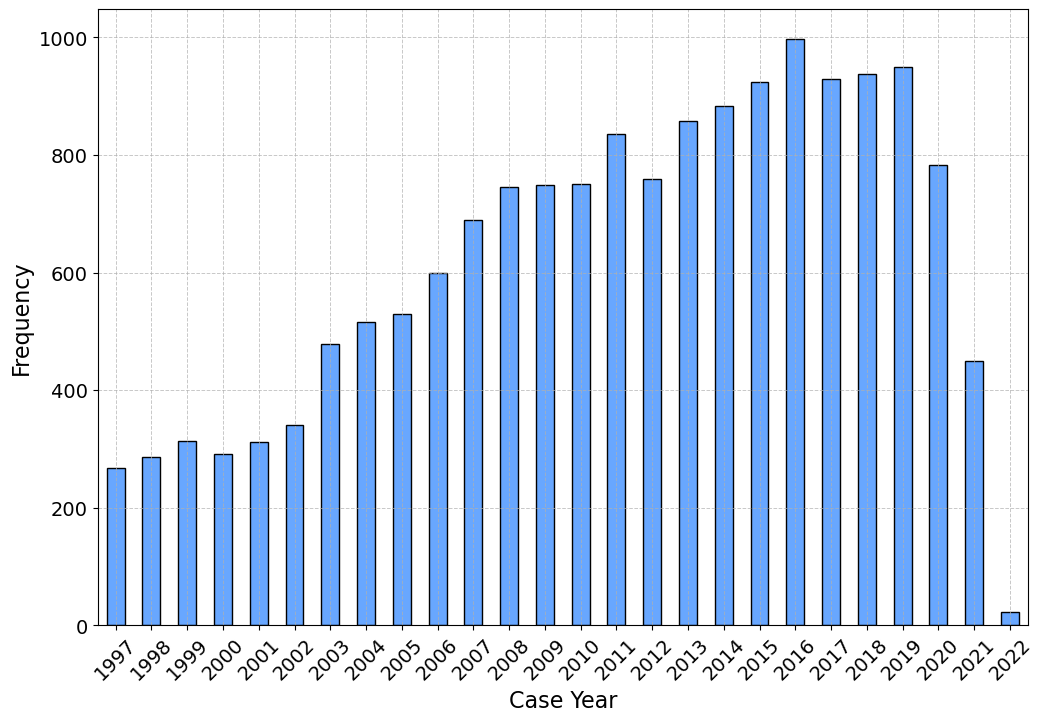

In [15]:
case_year_column = full_iuropa['case_year']

# Counting frequency of each year
year_counts = case_year_column.value_counts().sort_index()

plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar', color=colour_codes[0], edgecolor='black')
plt.xlabel('Case Year', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linestyle='--', linewidth=0.7, alpha=0.7)

plt.gcf().set_size_inches(12, 8)

plt.savefig("distribution_of_case_years_1997_2022.png", dpi=300)

plt.show()

#### Distribution of case duration

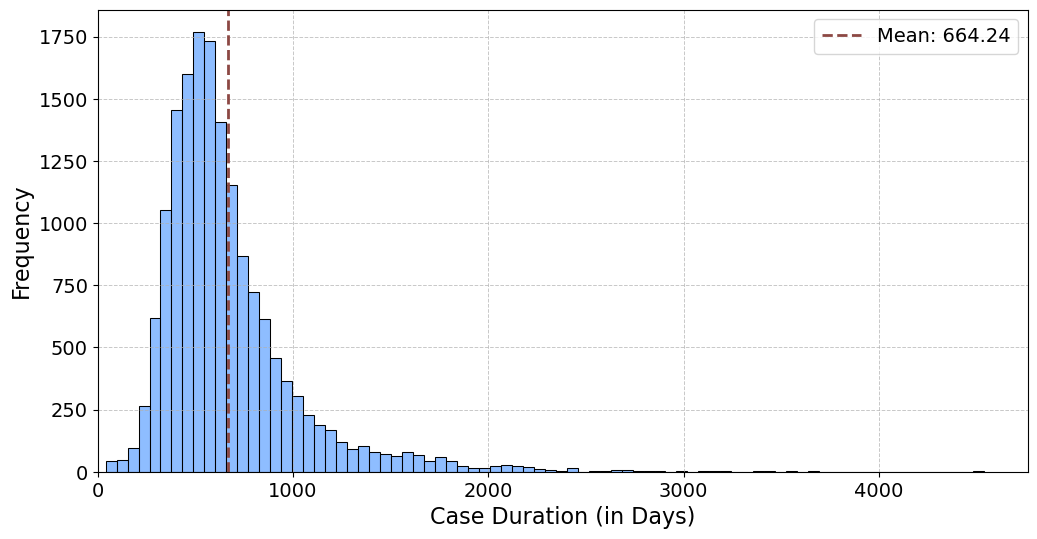

In [12]:
plt.figure(figsize=(12, 6)) 
hist_plot = sns.histplot(data=full_iuropa, x='duration_days', bins=80, color=colour_codes[0], edgecolor = 'black')

plt.xlim(left=0) 
plt.ylim(bottom=0) 
plt.xlabel('Case Duration (in Days)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.grid(linestyle='--', linewidth=0.7, alpha=0.7)  
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

mean_duration = full_iuropa['duration_days'].mean()
plt.axvline(mean_duration, color=colour_codes[3], linestyle='--', linewidth=2, label=f'Mean: {mean_duration:.2f}')
plt.legend(fontsize=14)

plt.savefig('histogram_duration_days.jpg', dpi=300)
plt.show()

##### Min and max values in duration

In [112]:
print("Minimum value:", full_iuropa['duration_days'].min())
print("Maximum value:", full_iuropa['duration_days'].max())

Minimum value: 40
Maximum value: 4537


#### Case duration throughout time

In [ ]:
dates['decision_date'] = pd.to_datetime(full_iuropa['decision_date'])

# Plotting duration for each decision date
plt.figure(figsize=(20, 7))
plt.plot(
    dates['decision_date'],
    dates['duration_days'],
    marker='o',
    color=colour_codes[0]
)

plt.title('Case Duration by Decision Date')
plt.xlabel('Decision Date')
plt.ylabel('Duration (days)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7) 
plt.tight_layout()  
plt.show()

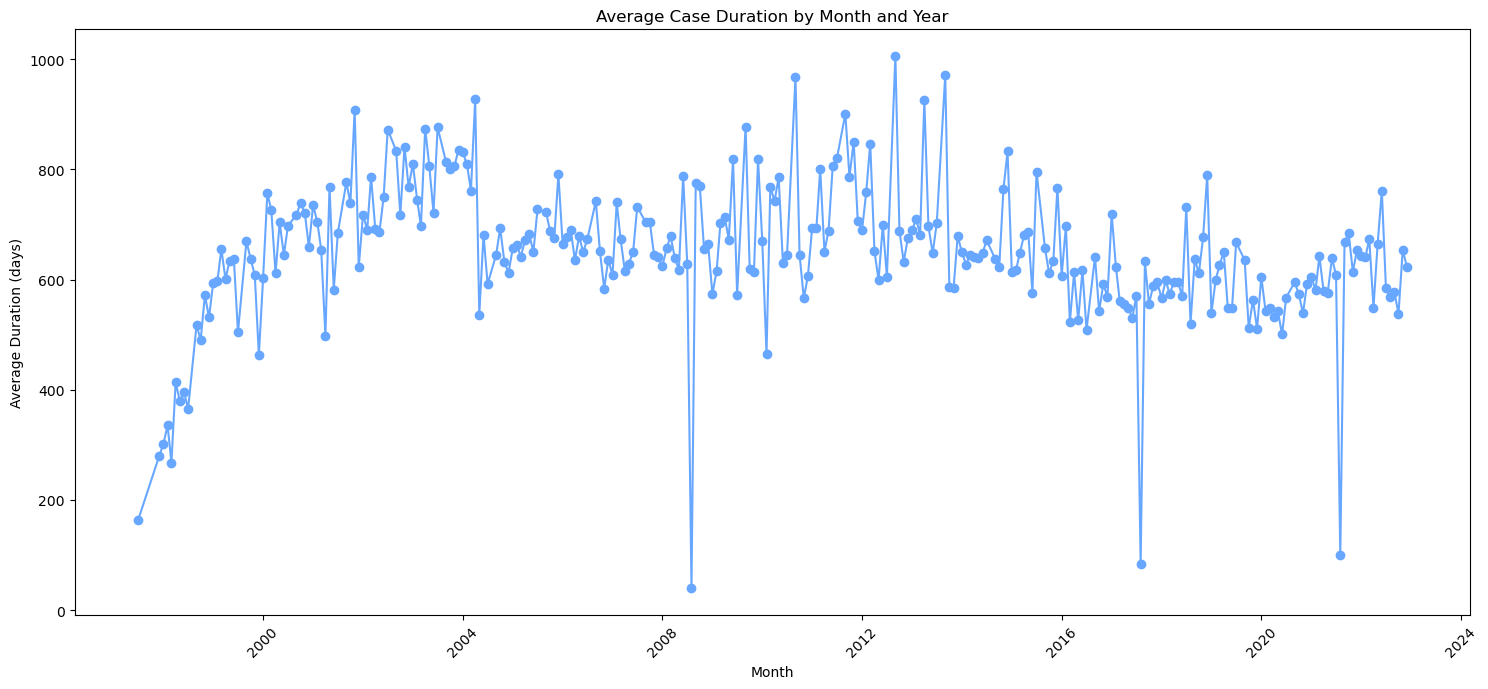

In [185]:
# Ensuring 'decision_date' is in datetime format
dates['decision_date'] = pd.to_datetime(full_iuropa['decision_date'])

# Extracting year and month from 'decision_date'
dates['year'] = dates['decision_date'].dt.year
dates['month'] = dates['decision_date'].dt.month

# Grouping by year and month to calculate average case duration for each month-year combination
avg_durations_per_month_per_year = dates.groupby(['year', 'month'])['duration_days'].mean().reset_index()

avg_durations_per_month_per_year['date'] = pd.to_datetime(avg_durations_per_month_per_year[['year', 'month']].assign(day=1))

# Plotting average duration for each month-year combination
plt.figure(figsize=(15, 7))
plt.plot(
    avg_durations_per_month_per_year['date'],
    avg_durations_per_month_per_year['duration_days'],
    marker = 'o',
    color=colour_codes[0]
)

plt.title('Average Case Duration by Month and Year')
plt.xlabel('Month')
plt.ylabel('Average Duration (days)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Courts

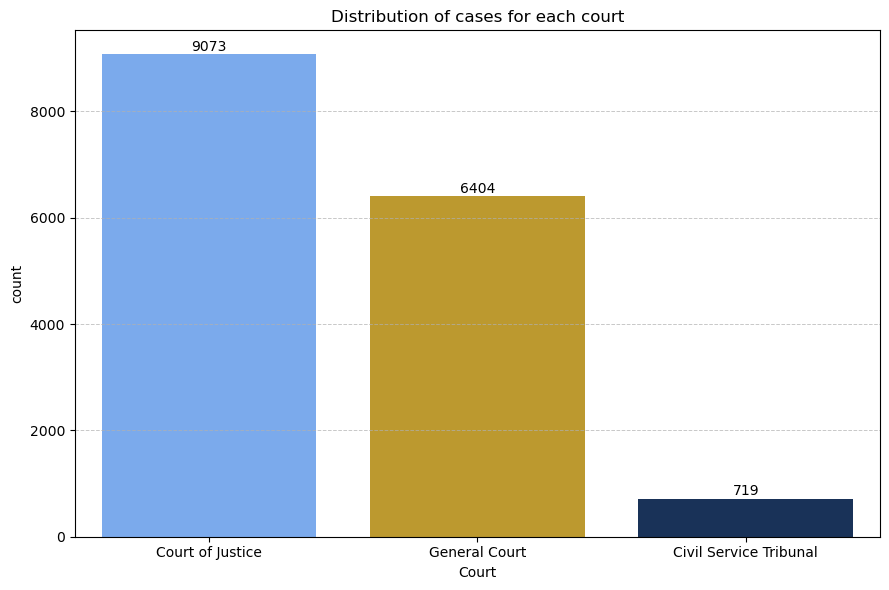

In [39]:
# Creating custom color palette
custom_palette = sns.color_palette(colour_codes[:3])

# Dictionary for court names
court_names = {
    1: 'Court of Justice',
    2: 'General Court',
    3: 'Civil Service Tribunal'
}

# Plotting with Seaborn
plt.figure(figsize=(9, 6))
ax = sns.countplot(data=full_iuropa, x='court_id', palette=custom_palette)

# Custom labels
plt.title('Distribution of cases for each court')
plt.xlabel('Court')
plt.xticks(ticks=[0, 1, 2], labels=[court_names[i] for i in range(1, 4)])  # Custom tick labels

# Adding counts on top of each bar
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.5, '%d' % int(p.get_height()),
            fontsize=10, color='black', ha='center', va='bottom')

# Tight layout and save the plot
plt.tight_layout()
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.savefig('Distribution_of_cases_for_each_court.png', dpi=300)
plt.show()


#### Document types

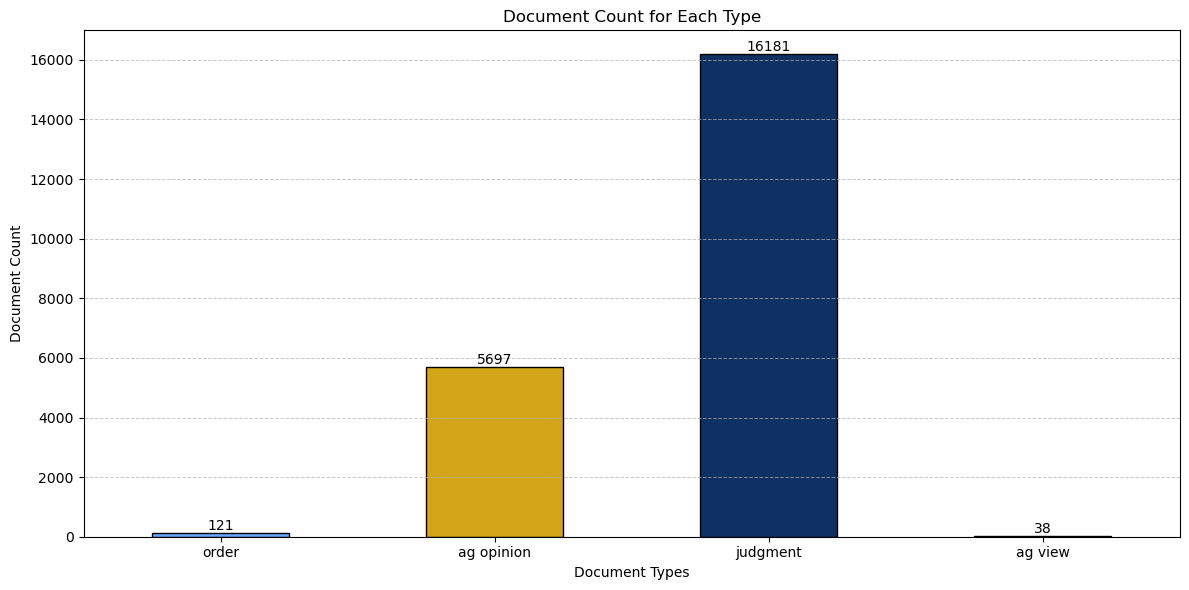

In [40]:
custom_palette = sns.color_palette(colour_codes[:4])

document_columns = ['order', 'ag opinion', 'judgment', 'ag view']

# Counting values excluding 'not applicable'
column_counts = full_iuropa[document_columns].apply(lambda x: x[x != 'not applicable'].count())

plt.figure(figsize=(12, 6)) 
bar_plot = column_counts.plot(kind='bar', color=custom_palette, edgecolor='black') 

for i, count in enumerate(column_counts):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

plt.xlabel('Document Types')
plt.ylabel('Document Count')
plt.title('Document Count for Each Type')
plt.xticks(rotation=0, ha='center')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout() 
plt.show()

#### Number of judges

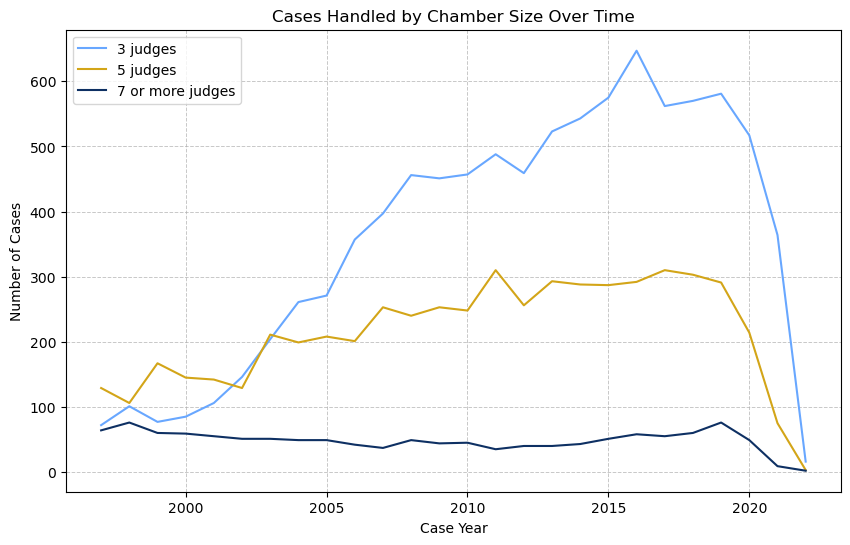

In [41]:
# Filtering data based on chamber size
chamber_size_3 = full_iuropa[full_iuropa['count_judges'] == 3]
chamber_size_5 = full_iuropa[full_iuropa['count_judges'] == 5]
chamber_size_7_or_more = full_iuropa[full_iuropa['count_judges'] >= 7]

# Grouping data by case year + counting
cases_by_year_3 = chamber_size_3.groupby('case_year').size()
cases_by_year_5 = chamber_size_5.groupby('case_year').size()
cases_by_year_7_or_more = chamber_size_7_or_more.groupby('case_year').size()

plt.figure(figsize=(10, 6))

plt.plot(cases_by_year_3.index, cases_by_year_3.values, label='3 judges', color=colour_codes[0])
plt.plot(cases_by_year_5.index, cases_by_year_5.values, label='5 judges', color=colour_codes[1])
plt.plot(cases_by_year_7_or_more.index, cases_by_year_7_or_more.values, label='7 or more judges', color=colour_codes[2])

plt.title('Cases Handled by Chamber Size Over Time')
plt.xlabel('Case Year')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()


#### Chambers

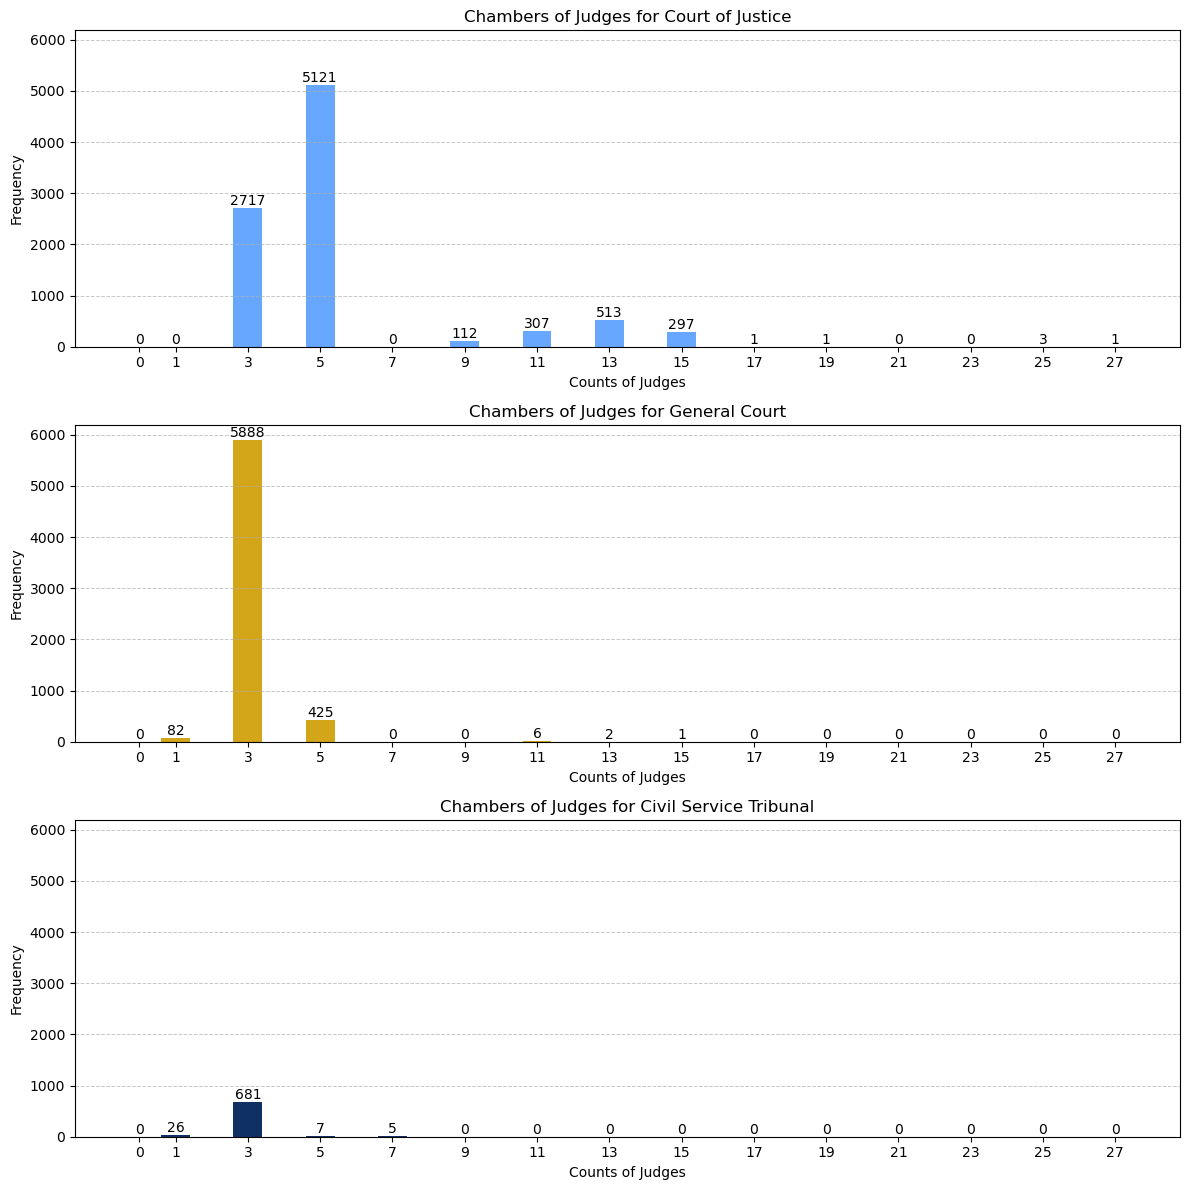

In [42]:
# Grouping by 'court' and 'count_judges', then counting occurrences
count_judges_counts = full_iuropa.groupby(['court_id', 'count_judges']).size().reset_index(name='counts')

# Specified values for the x-axis
specified_values = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), sharey=True)

for i, court_id in enumerate([1,2,3]):
    # Filtering data for current court
    court_data = count_judges_counts[count_judges_counts['court_id'] == court_id]

    # Creating a df with only the specified count_judges values
    specified_count_judges_df = pd.DataFrame({'count_judges': specified_values})

    # Merging with court_data to include only specified values & filling missing counts with 0
    court_data_merged = pd.merge(specified_count_judges_df, court_data, on='count_judges', how='left').fillna(0)

    bar_color = colour_codes[i]
    bars = axes[i].bar(court_data_merged['count_judges'], court_data_merged['counts'], color=bar_color)
    
    axes[i].set_xlabel('Counts of Judges')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Chambers of Judges for {court_names[court_id]}')

    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width() / 2, height, int(height),
                     ha='center', va='bottom', color='black', fontsize=10)

    axes[i].set_xticks(specified_values)
    
    axes[i].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


#### Workload

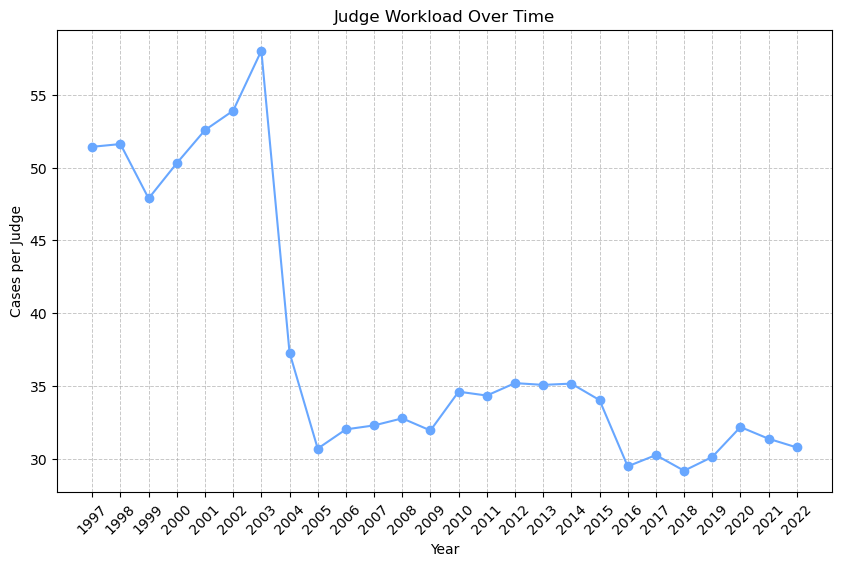

In [57]:
plt.figure(figsize=(10, 6)) 
plt.plot(judge_backlog['case_year'], judge_backlog['cases_per_judge'], 
         marker='o', linestyle='-', color=colour_codes[0], label='Cases per Judge')

plt.title('Judge Workload Over Time') 
plt.xlabel('Year')  
plt.ylabel('Cases per Judge')  
plt.xticks(judge_backlog['case_year'], rotation = 45)
plt.grid(linestyle='--', linewidth=0.7, alpha=0.7) 

plt.savefig('judge_workload_over_time.png')
plt.show()  

#### Languages used

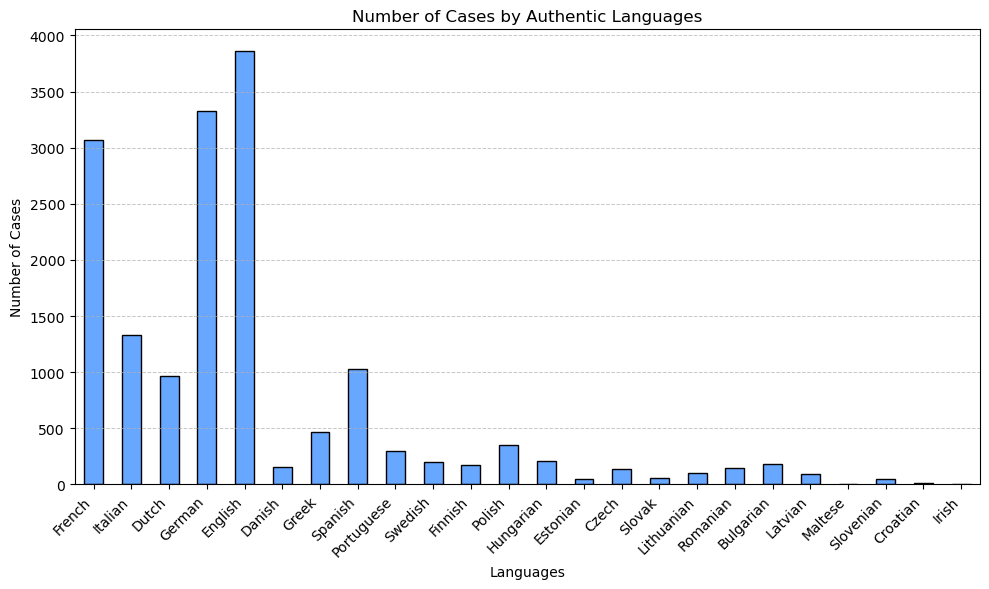

In [43]:
language_columns = full_iuropa[['french', 'italian', 'dutch', 'german', 
                                'english', 'danish', 'greek', 'spanish', 
                                'portuguese', 'swedish', 'finnish', 'polish', 
                                'hungarian', 'estonian', 'czech', 'slovak', 
                                'lithuanian', 'romanian', 'bulgarian', 'latvian', 
                                'maltese', 'slovenian', 'croatian', 'irish']]

# Summing occurrences of True values for each language
language_counts = language_columns.sum()

plt.figure(figsize=(10, 6))
language_counts.plot(kind='bar', color=colour_codes[0], edgecolor='black')
plt.title('Number of Cases by Authentic Languages')
plt.xlabel('Languages')
plt.ylabel('Number of Cases')

# Capitalising x-axis labels (because of preprocessing, languages didn't start with a capital letter)
capitalized_labels = [label.capitalize() for label in language_counts.index]
plt.xticks(ticks=range(len(capitalized_labels)), labels=capitalized_labels, rotation=45, ha='right')

plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()
plt.show()


French is highest: The deliberations are held in French = the working language of the Court 

#### Correlation between case duration and word count in case texts

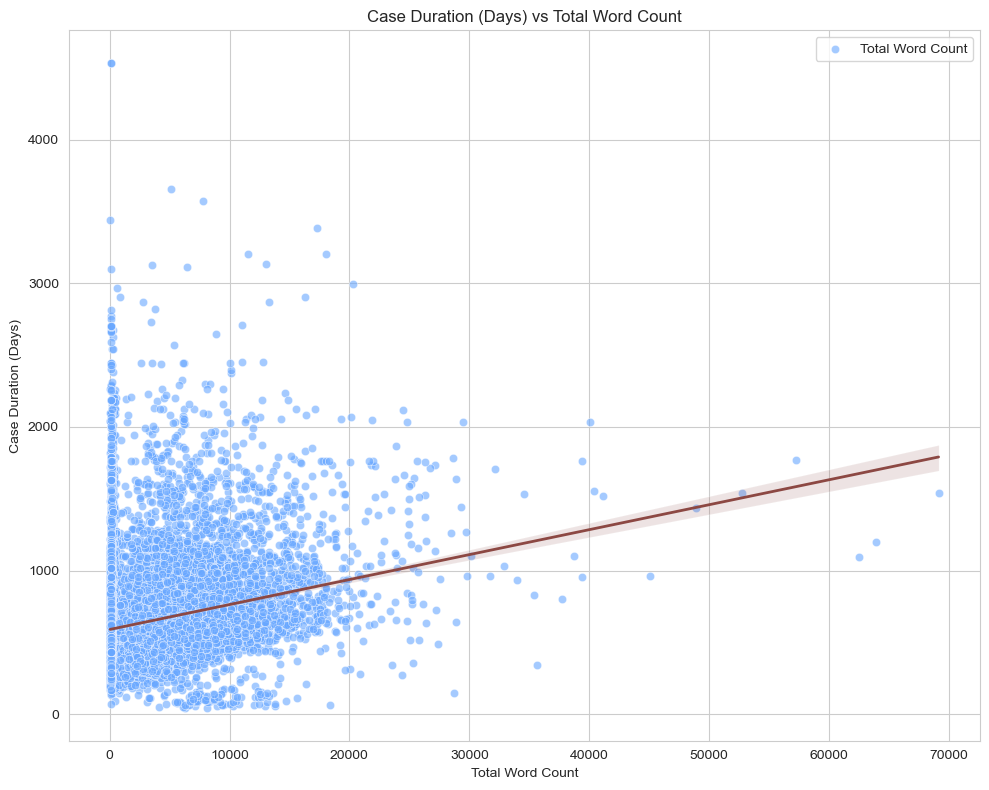

In [94]:
df = full_iuropa.copy()
df['total_word_count'] = (
    df['words_judgment'] + 
    df['words_order'] + 
    df['words_ag opinion'] + 
    df['words_ag view']
)

sns.set_style("whitegrid")

# Creating a scatter plot for total word count vs. duration days
plt.figure(figsize=(10, 8))

sns.scatterplot(data=df, x='total_word_count', y='duration_days', color=colour_codes[0], alpha=0.6, label='Total Word Count')
sns.regplot(data=df, x='total_word_count', y='duration_days', scatter=False, color=colour_codes[3], line_kws={"linewidth": 2})

plt.title('Case Duration (Days) vs Total Word Count')
plt.xlabel('Total Word Count')
plt.ylabel('Case Duration (Days)')

plt.tight_layout()

plt.savefig('correlation_duration_wordcount.jpg', dpi=300) 
plt.show()



#### Text values

We filter out rows where the texts have 0 words, because that means the text does not exist and we want to know the avarage word count of texts that _do_ exist.

In [68]:
non_zero_order = full_iuropa[full_iuropa['words_order'] > 0]
non_zero_judgment = full_iuropa[full_iuropa['words_judgment'] > 0]
non_zero_ag_opinion = full_iuropa[full_iuropa['words_ag opinion'] > 0]
non_zero_ag_view = full_iuropa[full_iuropa['words_ag view'] > 0]

total_words = (sum(non_zero_order['words_order']) + sum(non_zero_judgment['words_judgment']) + sum(non_zero_ag_opinion['words_ag opinion']) + sum(non_zero_ag_view['words_ag view']))
total_texts = len(non_zero_order) + len(non_zero_judgment) + len(non_zero_ag_opinion) + len(non_zero_ag_view) 

In [69]:
print("Average number of words in orders':", non_zero_order['words_order'].mean())
print("Average number of words in judgments':", non_zero_judgment['words_judgment'].mean())
print("Average number of words in AG opinions':", non_zero_ag_opinion['words_ag opinion'].mean())
print("Average number of words in AG views':", non_zero_ag_view['words_ag view'].mean())
print("Average number of words across all texts:", total_words/total_texts)

Average number of words in orders': 609.5619834710744
Average number of words in judgments': 2673.49873308201
Average number of words in AG opinions': 4522.695629278568
Average number of words in AG views': 5369.421052631579
Average number of words across all texts: 3144.8688569224487


#### Correlation Matrix


`duration_months` should be excluded as it is the same as duration_days

`case_year` should be excluded as training should not happen based on years. It will influence the correlations wrongly

In [28]:
excluded_columns = ['duration_months'] + ['case_year']
full_iuropa_corr = full_iuropa.drop(columns=excluded_columns, errors='ignore')


##### Correlations including keywords

In [ ]:
categorical_columns = full_iuropa_corr.select_dtypes(include=['object']).columns

one_hot_encoded_df = pd.get_dummies(full_iuropa_corr, columns=categorical_columns)

correlation_matrix = one_hot_encoded_df.corr()

# Extracting only the 'duration_days' correlations
correlations_with_duration = correlation_matrix[['duration_days']].copy()  

In [ ]:
correlations_with_duration = correlation_matrix['duration_days'].drop('duration_days')

# Get top 10 positive correlations
N = 10
top_corr_with_duration = correlations_with_duration.nlargest(N)  

# Get top 10 negative correlations
bottom_corr_with_duration = correlations_with_duration.nsmallest(N)  

# Reversing the order of bottom_corr_with_duration (lowest correlation at the bottom)
bottom_corr_with_duration_reversed = bottom_corr_with_duration.iloc[::-1] 

# Concatenating the positive correlations with the reversed negative correlations
top_and_bottom_corr = pd.concat([top_corr_with_duration, bottom_corr_with_duration_reversed])

print("Top Correlations with 'duration_days':")
for feature, correlation in top_and_bottom_corr.items():
    print(f"{feature}: {correlation}")

Top Correlations with 'duration_days':
count_cited_documents: 0.36632960525324104
keyword_1_Agreements: 0.31425271025974244
keyword_2_decisions and concerted practices: 0.31425271025974244
keyword_3_ Competition: 0.31312390309356236
words_judgment: 0.29600706211917677
count_directory_codes: 0.29445141130779307
count_on_appeal: 0.24584821654675879
count_procedures: 0.20410699695449078
is_direct_action: 0.20179032522339035
keyword_1_Competition: 0.18613411017096873
keyword_1_Intellectual: -0.15085345795574057
ag1_former_lawyer: -0.15224147475345312
days_experience_judge_1: -0.17578200330770777
count_referring_member_states: -0.19235106706716099
is_preliminary_ruling: -0.1942233270294261
days_experience_judge_3: -0.19883181981676176
active_judges: -0.20847336371988245
ag1_former_academic: -0.21645705925170944
count_advocates_general: -0.22393784498261107
backlog: -0.2392675417849621


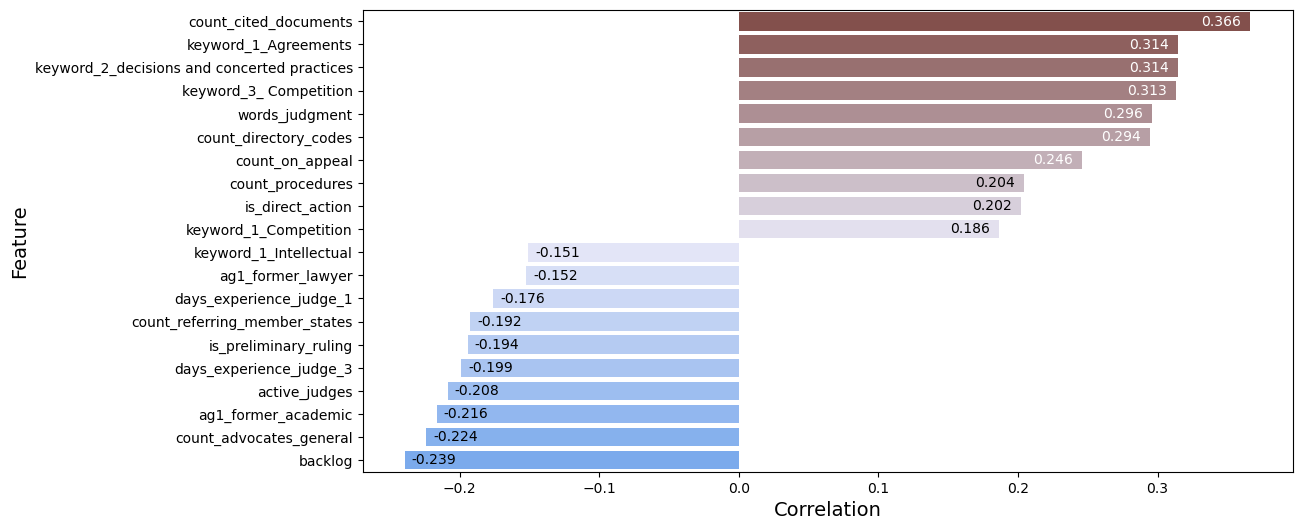

In [48]:
# Generate own colors
num_colors = len(top_and_bottom_corr)
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient", [colour_codes[3], "#e6e6fa", colour_codes[0]], N=num_colors2)

# Create a list of discrete colors from the colormap
color_palette = [custom_cmap(i / (num_colors - 1)) for i in range(num_colors)]

# Create a bar plot with the custom color palette
plt.figure(figsize=(12, 6))
sns.barplot(x=top_and_bottom_corr.values, y=top_and_bottom_corr.index, palette=color_palette, orient='h')

# Annotate the bars with correlation values
for i, (value, feature) in enumerate(zip(top_and_bottom_corr.values, top_and_bottom_corr.index)):
    text_color = 'black' if value < 0.245 else 'white'  
    text_position = value + 0.005 if value < 0 else value - 0.035 
    plt.text(text_position, i, f'{value:.3f}', color=text_color, va='center') 

# Add labels and titles
plt.xlabel('Correlation', fontsize=14)
plt.ylabel('Feature', fontsize=14)

plt.savefig('top_correlations_incl_keywords.jpg', dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()


##### Correlations without keywords

In [44]:
# Excluding variables that start with 'keyword_'
filtered_correlations = correlations_with_duration[
    ~correlations_with_duration.index.str.startswith('keyword_')
]

filtered_top_corr_with_duration = filtered_correlations.nlargest(N)

filtered_bottom_corr_with_duration = filtered_correlations.nsmallest(N)

filtered_bottom_corr_with_duration_reversed = filtered_bottom_corr_with_duration.iloc[::-1]

filtered_top_and_bottom_corr = pd.concat([filtered_top_corr_with_duration, filtered_bottom_corr_with_duration_reversed])

print("\nTop and Bottom Correlations with 'duration_days' (excluding 'keyword_'):")
for feature, correlation in filtered_top_and_bottom_corr.items():
    print(f"{feature}: {correlation}")


Top and Bottom Correlations with 'duration_days' (excluding 'keyword_'):
count_cited_documents: 0.36632960525324104
words_judgment: 0.29600706211917677
count_directory_codes: 0.29445141130779307
count_on_appeal: 0.24584821654675879
count_procedures: 0.20410699695449078
is_direct_action: 0.20179032522339035
court_id: 0.1717162850540253
cases_per_judge: 0.14342246159595967
english: 0.11797483587577912
judge_from_greece: 0.10889256608029105
days_experience_ag_1: -0.13942416862337947
ag1_former_lawyer: -0.15224147475345312
days_experience_judge_1: -0.17578200330770777
count_referring_member_states: -0.19235106706716099
is_preliminary_ruling: -0.1942233270294261
days_experience_judge_3: -0.19883181981676176
active_judges: -0.20847336371988245
ag1_former_academic: -0.21645705925170944
count_advocates_general: -0.22393784498261107
backlog: -0.2392675417849621


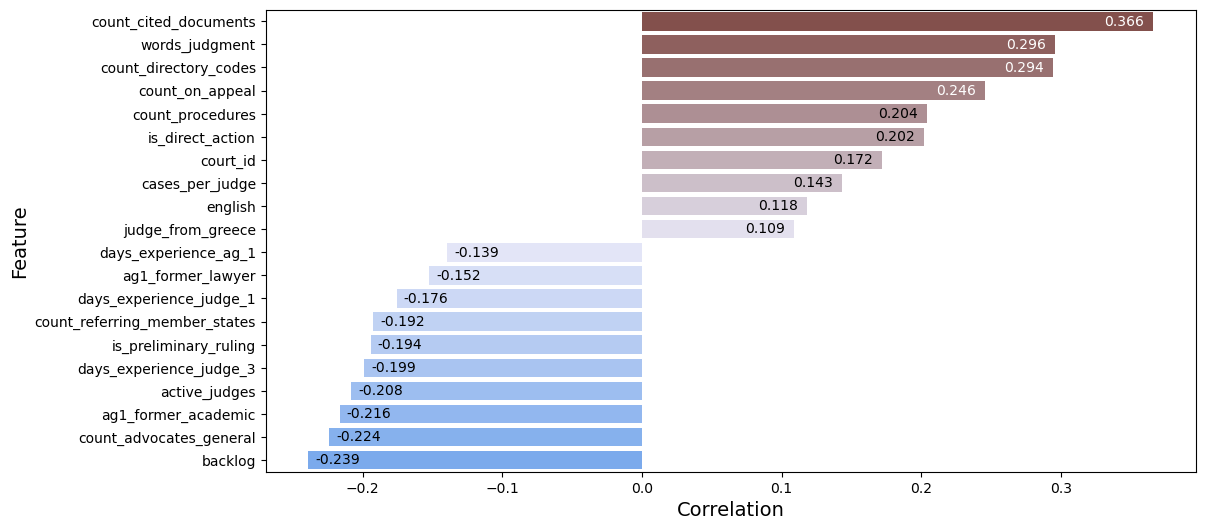

In [49]:
# Create a bar plot with the custom color palette
plt.figure(figsize=(12, 6))
sns.barplot(x=filtered_top_and_bottom_corr.values, y=filtered_top_and_bottom_corr.index, palette=color_palette, orient='h')

# Annotate the bars with correlation values
for i, (value, feature) in enumerate(zip(filtered_top_and_bottom_corr.values, filtered_top_and_bottom_corr.index)):
    text_color = 'black' if value < 0.245 else 'white'
    text_position = value + 0.005 if value < 0 else value - 0.035  
    plt.text(text_position, i, f'{value:.3f}', color=text_color, va='center')  

plt.xlabel('Correlation', fontsize=14)
plt.ylabel('Feature', fontsize=14)

plt.savefig('top_correlations_no_keywords.jpg', dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()


# Duration and backlog CJEU

Info manually retrieved from CJEU Annual Reports (https://curia.europa.eu/jcms/jcms/Jo2_7015/en/)

In [16]:
annual_reports = {
    'Year': list(range(1997, 2023)),
    'Cases Brought': [1089, 723, 927, 901, 849, 888, 1027, 1067, 1073, 1117, 1260, 1333, 1243, 1406, 1569, 1427, 1649, 1691, 1711, 1604, 1656, 1683, 1905, 1582, 1720, 1710],
    'Cases Closed': [642, 768, 1054, 869, 774, 844, 833, 1026, 1184, 1035, 1117, 1301, 1298, 1230, 1518, 1404, 1587, 1685, 1755, 1628, 1594, 1769, 1739, 1540, 1723, 1666],
    'Cases Pending (backlog)': [1800, 1755, 1628, 1660, 1735, 1779, 1973, 2014, 1903, 1985, 2131, 2163, 2108, 2284, 2335, 2358, 2420, 2426, 2382, 2358, 2420, 2334, 2500, 2542, 2541, 2585],
    'Average Duration CJEU': [15.2, 19.6, 17.6, 19.5, 19.7, 20.9, 22.4, 20.7, 21.4, 22.0, 19.5, 21.7, 22.2, 20.5, 20.9, 19.8, 21.4, 18.5, 16.1, 16.7, 16.3, 17.8, 15.6, 15.4, 17.2, 16.3],
    'Average Duration CJ': [12.8, 20.9, 22.4, 21.5, 20.7, 22.5, 26.3, 21.7, 20.9, 19.2, 18.4, 17.4, 16.5, 15.7, 17.3, 16.8, 19.1, 16.5, 15.6, 14.7, 16.4, 15.7, 14.4, 15.4, 16.6, 16.4],
    'Average Duration GC': [17.5, 18.4, 12.7, 17.4, 18.6, 19.3, 18.4, 19.7, 22.0, 24.8, 26.8, 30.7, 34.9, 27.8, 31.2, 27.8, 30.4, 26.4, 20.6, 18.7, 16.3, 20.0, 16.9, 15.4, 17.3, 16.2],
    'Average Duration CST': [None, None, None, None, None, None, None, None, None, None, 13.2, 17.0, 15.1, 18.1, 14.2, 14.8, 14.7, 12.7, 12.1, 10, None, None, None, None, None, None]
}

annual_reports_df = pd.DataFrame(annual_reports)

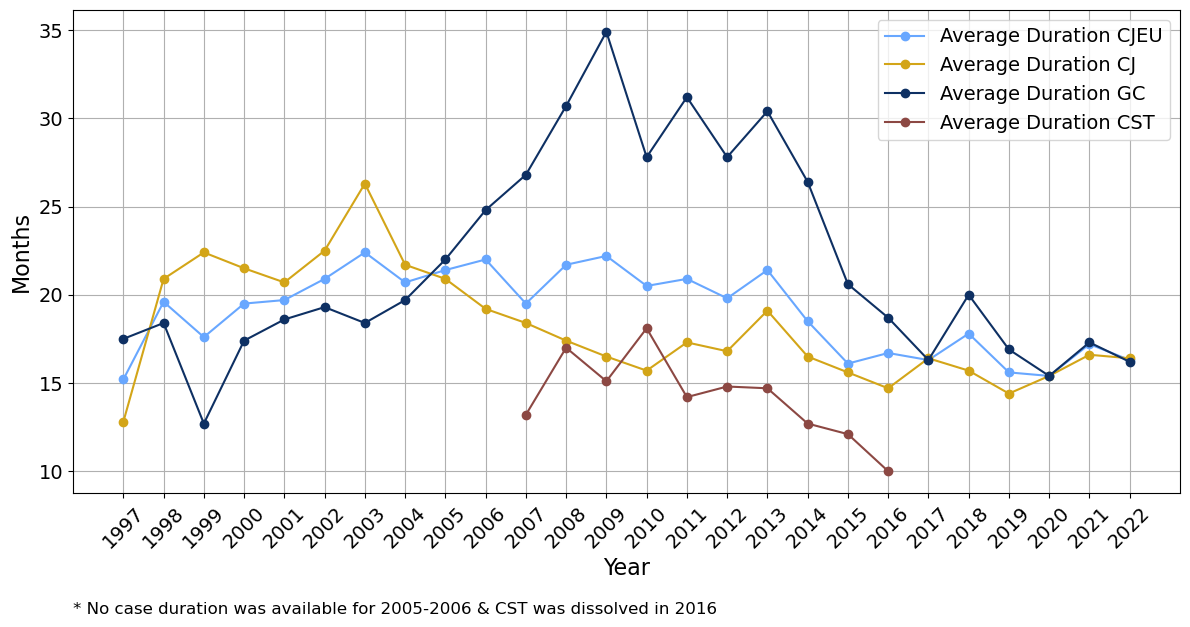

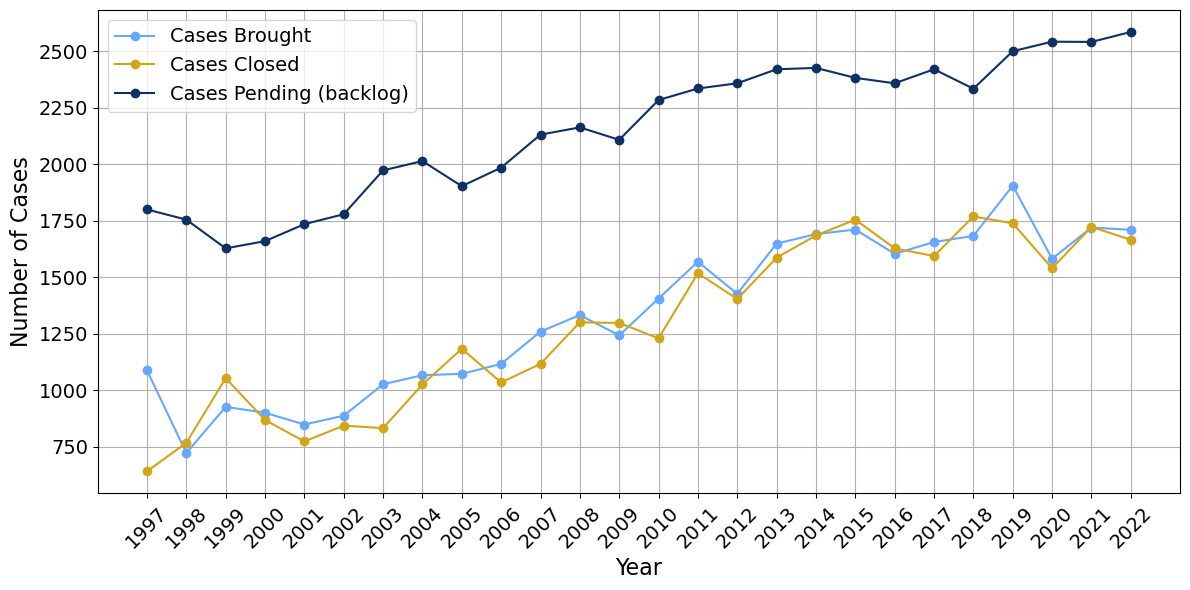

In [26]:
# Plotting durations (CJEU, CJ, GC, CST)
plt.figure(figsize=(12, 6))
for i, column in enumerate(['Average Duration CJEU', 
                            'Average Duration CJ', 
                            'Average Duration GC', 
                            'Average Duration CST']):
    
    # Adding an asterisk to the CST label
    label = column + ' (*)' if 'Civil Service Tribunal' in column else column
    plt.plot(annual_reports_df['Year'], annual_reports_df[column], marker='o', color=colour_palette(i), label=label)
    

plt.xlabel('Year', fontsize = 16)
plt.ylabel('Months', fontsize = 16)
plt.xticks(annual_reports_df['Year'], rotation = 45, fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(True)
plt.legend(fontsize = 14)
plt.tight_layout()

# Adding annotation explaining the asterisk
plt.text(0, -0.25, '* No case duration was available for 2005-2006 & CST was dissolved in 2016', 
         transform=plt.gca().transAxes, fontsize = 12)

plt.savefig('durations_over_time.png', bbox_inches='tight', dpi = 300)
plt.show()


# Plotting cases (brought, closed, pending)
plt.figure(figsize=(12, 6))
for i, column in enumerate(['Cases Brought', 'Cases Closed', 'Cases Pending (backlog)']):
    plt.plot(annual_reports_df['Year'], annual_reports_df[column], marker='o', color=colour_palette(i), label=column)

plt.xlabel('Year', fontsize = 16)
plt.ylabel('Number of Cases', fontsize = 16)
plt.xticks(annual_reports_df['Year'], rotation = 45, fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(True)
plt.legend(fontsize = 14)
plt.tight_layout()

plt.savefig('cases_over_time.png', dpi = 300)
plt.show()


# Models

## Loading the dataset

In [4]:
full_iuropa = pd.read_csv('Databases/CJEU_data/full_iuropa_preprocessed.csv', low_memory = False)

# Converting integer columns to int32
full_iuropa[full_iuropa.select_dtypes(include='int64').columns] = full_iuropa[full_iuropa.select_dtypes(include='int64').columns].astype('int32')

# Converting float columns to float32
full_iuropa[full_iuropa.select_dtypes(include='float64').columns] = full_iuropa[full_iuropa.select_dtypes(include='float64').columns].astype('float32')

full_iuropa = full_iuropa.drop(['duration_months'], axis=1)

## Definfing Huber Loss

\begin{equation} \label{eq:huber}
        \rho(t) = 
          \begin{cases} 
            \frac{1}{2} t^2 & \text{if } |t| < k \\
            k \cdot |t| - \frac{1}{2} k^2 & \text{if } |t| \geq k
          \end{cases} 
        \end{equation}
        
where _t_ represents the residual and _k_ represents the threshold

In [10]:
def huber_loss(y_true, y_pred, k=1.35):
    
    residual = y_true - y_pred
    
    is_small_error = np.abs(residual) <= k
    
    small_error_loss = 0.5 * residual[is_small_error] ** 2
    large_error_loss = k * np.abs(residual[~is_small_error]) - 0.5 * k ** 2
    
    total_loss = np.sum(small_error_loss) + np.sum(large_error_loss)
    
    return total_loss / len(y_true)

## Training without text-related data

### Data preparation

In [24]:
df = full_iuropa.copy()

# Dropping text-related columns
columns_to_drop = ['judgment', 'order', 'ag opinion', 'ag view', 
                   'words_order', 'words_judgment', 'words_ag opinion', 'words_ag view']

columns_to_drop_by_prefix = df.filter(like='keyword_').columns.tolist()

columns_to_drop += columns_to_drop_by_prefix

df = df.drop(columns=columns_to_drop, errors='ignore')

# Making sure the columns are ordered chronologically
df = df.sort_values(by='case_year')

# Making a held_out_test set
num_samples = len(df)
split_index = int(num_samples * 0.85)

# Extracting the last 15% for the held-out test set
held_out_test = df.iloc[split_index:] 

# Extracting the first 85% for training/validation
train_val_set = df.iloc[:split_index]

In [25]:
# Making a train/validation split (70/30)
train_set, val_set = train_test_split(train_val_set, test_size=0.30, shuffle=True, random_state=42)

numeric_columns = [col for col in df.select_dtypes(include=['int', 'float']).columns if col != 'duration_days' and col != 'case_year']

# Preprocessing pipeline for numeric columns
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numeric_columns)],
    remainder="passthrough"
)

### Mean prediction Baseline

In [125]:
y_train_mean = train_set['duration_days']
y_val_mean = val_set['duration_days']

# Calculating the mean of the target variable in the training set
mean_prediction = y_train_mean.mean()

# Creating an array with the same length as the test set, filled with the mean value
y_pred_val_mean = np.full(len(y_val_mean), mean_prediction)

# Evaluating the mean prediction baseline
mae_val_mean = mean_absolute_error(y_val_mean, y_pred_val_mean)
r2_val_mean = r2_score(y_val_mean, y_pred_val_mean)
huber_val_mean = huber_loss(y_val_mean, y_pred_val_mean)  

print("Baseline Metrics (Predicting Mean):")
print(f"MAE:: {mae_val_mean:.2f}")
print(f"R2 Score: {r2_val_mean:.4f}")
print(f"Huber Loss: {huber_val_mean:.2f}")

Baseline Metrics (Predicting Mean):
MAE:: 250.82
R2 Score: -0.0002
Huber Loss: 337.69


### Linear Regression Baseline

In [88]:
percentile_99 = df['duration_days'].quantile(0.99)

print("The 99th percentile of duration_days is:", percentile_99)


The 99th percentile of duration_days is: 2023.0


Making a clipping maximum to avoid overfow

In [89]:
clipping_max = np.log1p(2023.0)

In [90]:
X_train = train_set.drop(['duration_days', 'case_year'], axis=1)
y_train = train_set['duration_days']

X_val = val_set.drop(['duration_days', 'case_year'], axis=1)
y_val = val_set['duration_days']

# Log-transforming the target variable to avoid influence by extreme values
y_train_log = np.log1p(y_train)

# Define a Linear Regression pipeline
linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Fitting the pipeline on the training data
linear_pipeline.fit(X_train, y_train_log)

# Meking predictions
y_pred_val_linear_log = linear_pipeline.predict(X_val)

# Clipping predictions
y_pred_val_linear_log_clipped = np.clip(y_pred_val_linear_log, a_min=np.NINF, a_max=clipping_max)

# Reverting log transformation for interpretability
y_pred_val_linear = np.expm1(y_pred_val_linear_log_clipped)

val_mae_linear = mean_absolute_error(y_val, y_pred_val_linear)
val_r2_linear = r2_score(y_val, y_pred_val_linear)
val_huber_linear = huber_loss(y_val, y_pred_val_linear)

print("Validation Metrics:")
print(f"MAE: {val_mae_linear:.2f}")
print(f"R²: {val_r2_linear:.2f}")
print(f"Huber Loss: {val_huber_linear:.2f}")


Validation Metrics:
MAE: 173.15
R²: 0.45
Huber Loss: 232.84


### Adaboost

#### Shuffled

In [28]:
# Defining Ada-parameter-grid for grid search
param_grid_ada = {
    'model__estimator__max_depth': [3, 5, 7],  
    'model__n_estimators': [100, 150, 200],  
    'model__learning_rate': [0.05, 0.1, 0.2],  
}

grid_search = GridSearchCV(
    estimator=Pipeline([
        ('preprocessor', preprocessor),
        ('model', AdaBoostRegressor(
            estimator=DecisionTreeRegressor(),
            random_state=42
        ))
    ]),
    param_grid = param_grid_ada,
    cv = 5,  
    scoring = 'neg_mean_squared_error',  
    n_jobs = -1,  
    verbose = 1  
)

grid_search.fit(train_set.drop(['duration_days', 'case_year'], axis=1), train_set['duration_days'])

# Retrieving best parameters and pipeline
best_params_adashuffle = grid_search.best_params_
best_pipeline_adashuffle = grid_search.best_estimator_

print("Best parameters:", best_params_adashuffle)

# Predictions on validation set using the best pipeline
y_pred_val_adashuffle = best_pipeline_adashuffle.predict(X_val)

# Calculate metrics on the validation set
val_mae_adashuffle = mean_absolute_error(y_val, y_pred_val_adashuffle)
val_r2_adashuffle = r2_score(y_val, y_pred_val_adashuffle)
val_huber_adashuffle = huber_loss(y_val, y_pred_val_adashuffle)

print("Validation Metrics:")
print(f"MAE: {val_mae_adashuffle:.2f}")
print(f"R²: {val_r2_adashuffle:.2f}")
print(f"Huber Loss: {val_huber_adashuffle:.2f}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'model__estimator__max_depth': 7, 'model__learning_rate': 0.1, 'model__n_estimators': 200}
Validation Metrics:
MAE: 162.28
R²: 0.65
Huber Loss: 218.17


#### Incrementally expanded

Defining function for incremental expansion

In [ ]:
def incremental_expansion(train_val):
    years = sorted(train_val['case_year'].unique())
    n_years = len(years)

    for i in range(1, n_years):
        
        # Training set includes data from all previous years and 85% of current year
        training_data = train_val[train_val['case_year'] < years[i]]
        current_year_data = train_val[train_val['case_year'] == years[i]]
        
        train_set = pd.concat([training_data, current_year_data[:int(0.85 * len(current_year_data))]])

        # Validation set is the remaining 15% of the current year's data
        val_set = current_year_data[int(0.85 * len(current_year_data)):]

        yield train_set, val_set

In [27]:
grid_search = GridSearchCV(
    estimator=Pipeline([
        ('preprocessor', preprocessor),
        ('model', AdaBoostRegressor(
            estimator=DecisionTreeRegressor(),
            random_state=42
        ))
    ]),
    param_grid = param_grid_ada,
    cv = 5,  
    scoring = 'neg_mean_squared_error',  
    n_jobs = -1,  
    verbose = 1  
)

# Incrementally training and validation
for train_set, val_set in incremental_expansion(train_val_set):
    
    X_train = train_set.drop(['duration_days', 'case_year'], axis=1)
    y_train = train_set['duration_days']

    X_val = val_set.drop(['duration_days', 'case_year'], axis=1)
    y_val = val_set['duration_days']

    grid_search.fit(X_train, y_train)

    # Retrieving best pipeline and parameters
    best_ada_pipeline = grid_search.best_estimator_
    best_ada_params = grid_search.best_params_

    print("Best parameters:", best_ada_params)

    # Predict and evaluate on the current validation set
    y_pred_val_adaexp = best_ada_pipeline.predict(X_val)

    # Calculate validation metrics
    mae_val_adaexp = mean_absolute_error(y_val, y_pred_val_adaexp)
    r2_val_adaexp = r2_score(y_val, y_pred_val_adaexp)
    huber_val_adaexp = huber_loss(y_val,  y_pred_val_adaexp)

    print("Validation Metrics:")
    print(f"MAE: {mae_val_adaexp:.2f}")
    print(f"R²: {r2_val_adaexp:.2f}")
    print(f"Huber Loss: {huber_val_adaexp:.2f}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 200}
Validation Metrics:
MAE: 104.83
R²: 0.11
Huber Loss: 140.61
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'model__estimator__max_depth': 7, 'model__learning_rate': 0.1, 'model__n_estimators': 200}
Validation Metrics:
MAE: 128.38
R²: 0.39
Huber Loss: 172.40
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 200}
Validation Metrics:
MAE: 150.21
R²: 0.40
Huber Loss: 201.87
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 200}
Validation Metrics:
MAE: 426.20
R²: 0.57
Huber Loss: 574.46
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameter

C:\Users\jarno\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
8 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jarno\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jarno\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jarno\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit(

Best parameters: {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 150}
Validation Metrics:
MAE: 139.37
R²: 0.29
Huber Loss: 187.23
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 200}
Validation Metrics:
MAE: 194.54
R²: 0.60
Huber Loss: 261.71
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 200}
Validation Metrics:
MAE: 176.00
R²: 0.80
Huber Loss: 236.69
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 200}
Validation Metrics:
MAE: 158.53
R²: 0.15
Huber Loss: 213.11
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'model__estimator__max_depth': 7, 'model__learning_rate': 

#### Graphical Representation AdaBoost Configurations

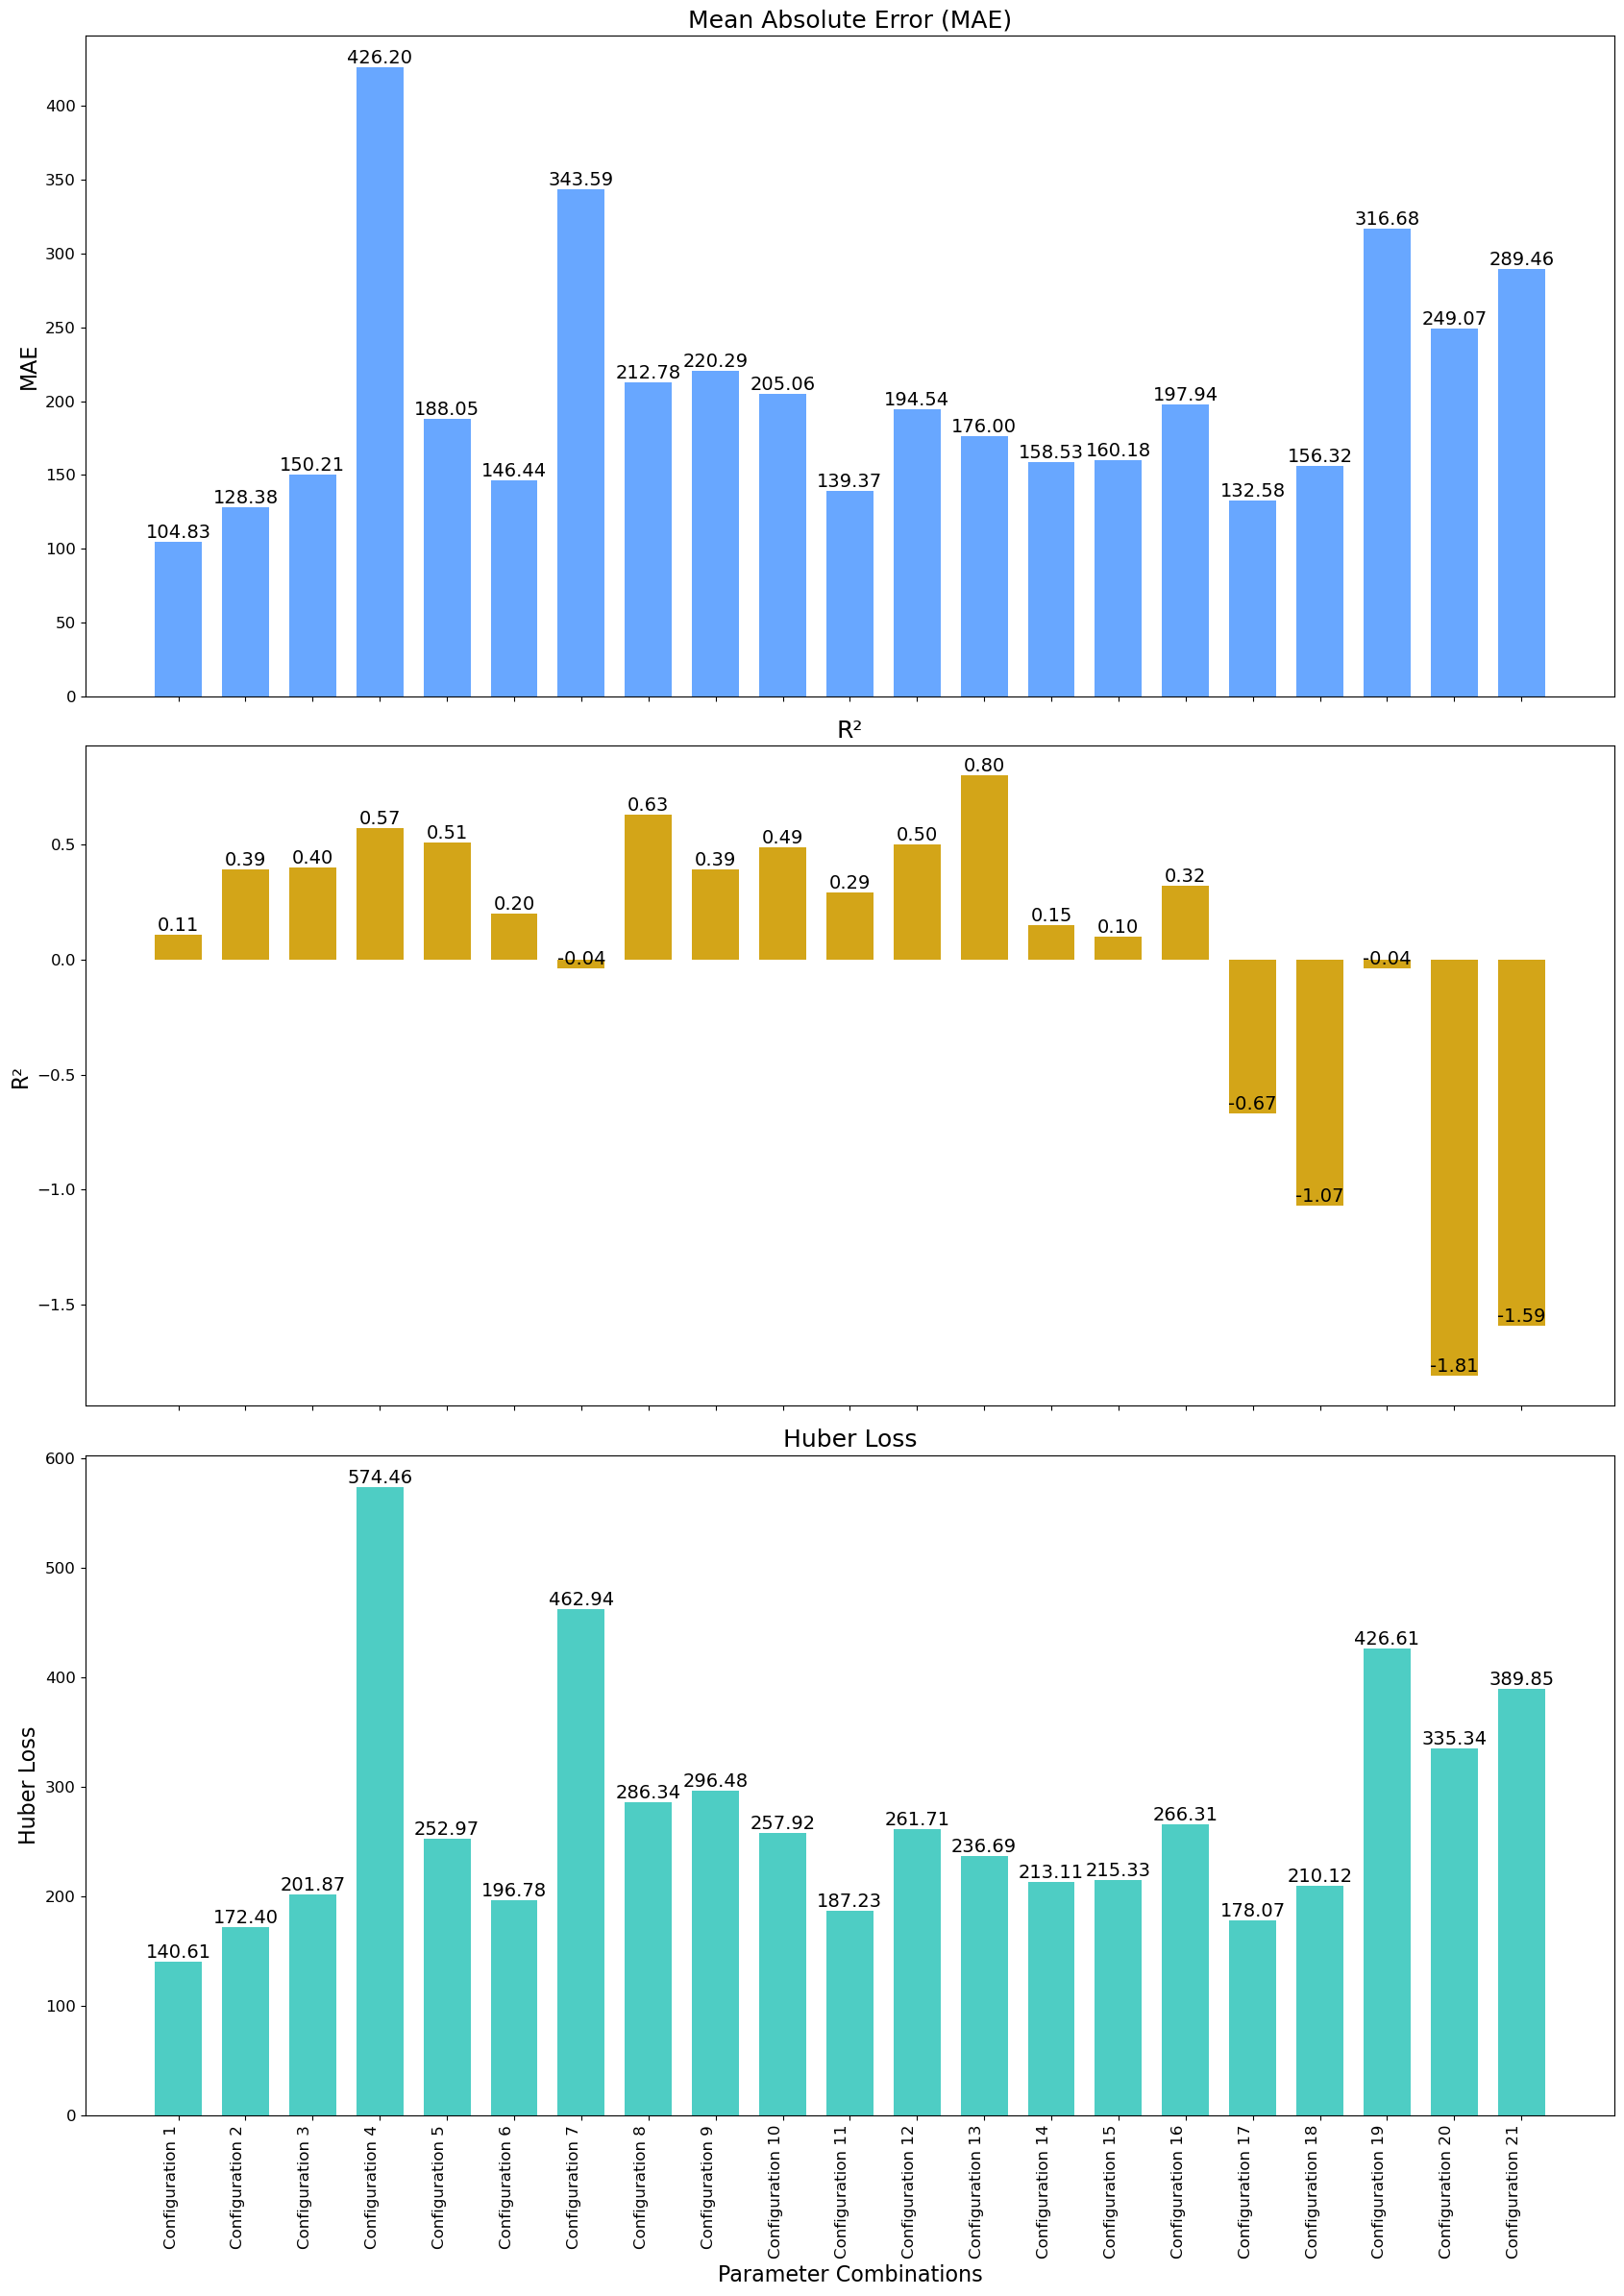

In [75]:
param_dict_ada = {
    "Parameters": [
        "Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5",
        "Configuration 6", "Configuration 7", "Configuration 8", "Configuration 9", "Configuration 10",
        "Configuration 11", "Configuration 12", "Configuration 13", "Configuration 14", "Configuration 15",
        "Configuration 16", "Configuration 17", "Configuration 18", "Configuration 19", "Configuration 20",
        "Configuration 21"
        
        #1 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 200}
        #2 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.1, 'model__n_estimators': 200}
        #3 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 200}
        #4 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 200}
        #5 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.1, 'model__n_estimators': 150}
        #6 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 200}
        #7 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 200}
        #8 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 200}
        #9 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 200}
        #10 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 150}
        #11 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 150}
        #12 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 200}
        #13 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 200}
        #14 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 200}
        #15 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 200}
        #16 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 200}
        #17 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 200}
        #18 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 200}
        #19 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 150}
        #20 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 150}
        #21 {'model__estimator__max_depth': 7, 'model__learning_rate': 0.2, 'model__n_estimators': 150}
    ],

    "MAE": [
        104.83, 128.38, 150.21, 426.20, 188.05, 146.44, 343.59, 212.78, 220.29, 205.06,
        139.37, 194.54, 176.00, 158.53, 160.18, 197.94, 132.58, 156.32, 316.68, 249.07, 289.46
    ],
    "R²": [
        0.11, 0.39, 0.40, 0.57, 0.51, 0.20, -0.04, 0.63, 0.39, 0.49,
        0.29, 0.50, 0.80, 0.15, 0.10, 0.32, -0.67, -1.07, -0.04, -1.81, -1.59
    ],
    "Huber Loss": [
        140.61, 172.40, 201.87, 574.46, 252.97, 196.78, 462.94, 286.34, 296.48, 257.92,
        187.23, 261.71, 236.69, 213.11, 215.33, 266.31, 178.07, 210.12, 426.61, 335.34, 389.85
    ],
}

param_data_ada = pd.DataFrame(param_dict_ada)

# Plotting a grouped bar chart for each metric
x_indices = np.arange(len(param_data_ada))  
 
fig, axes = plt.subplots(3, 1, figsize=(17, 25), sharex=True)

bar_width = 0.7

# Plot for MAE
bars = axes[0].bar(x_indices, param_data_ada["MAE"], width=bar_width, color=colour_codes[0])
axes[0].set_title("Mean Absolute Error (MAE)", fontsize=18)
axes[0].set_ylabel("MAE", fontsize=16)
axes[0].tick_params(axis="y", labelsize=12)

for bar in bars:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=14)

# Plot for R²
bars = axes[1].bar(x_indices, param_data_ada["R²"], width=bar_width, color=colour_codes[1])
axes[1].set_title("R²", fontsize=18)
axes[1].set_ylabel("R²", fontsize=16)
axes[1].tick_params(axis="y", labelsize=12)

for bar in bars:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=14)

# Plot for Huber Loss
bars = axes[2].bar(x_indices, param_data_ada["Huber Loss"], width=bar_width, color=colour_codes[5])
axes[2].set_title("Huber Loss", fontsize=18)
axes[2].set_xlabel("Parameter Combinations", fontsize=16)
axes[2].set_ylabel("Huber Loss", fontsize=16)
axes[2].tick_params(axis="y", labelsize=12)
axes[2].set_xticks(x_indices)
axes[2].set_xticklabels(param_data_ada["Parameters"], rotation=90, ha="right", fontsize=12)

for bar in bars:
    yval = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig("validation_metrics_ada.png", dpi=300)
plt.show()     


### XGBoost

#### Shuffled

In [30]:
# Defining XGB-parameter-grid for grid search
param_grid = {
    'model__n_estimators': [100, 150, 200],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__max_depth': [3, 5, 7],
    'model__colsample_bytree': [0.7, 0.8, 0.9]
}

# Defining XGBoost pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

grid_search = GridSearchCV(
    xgb_pipeline,
    param_grid,
    cv = 5, 
    scoring = 'neg_mean_squared_error',  
    n_jobs = -1,
    verbose = 1
)

# Fitting grid search on the training set
grid_search.fit(train_set.drop(['duration_days', 'case_year'], axis=1), train_set['duration_days'])

# Retrieving best parameters and pipeline
best_params_xgbshuffle = grid_search.best_params_
best_pipeline_xgbshuffle = grid_search.best_estimator_

print("Best parameters:", best_params_xgbshuffle)

# Predictions on validation set using the best pipeline
y_pred_val_xgbshuffle = best_pipeline_xgbshuffle.predict(X_val)

# Calculate metrics on the validation set
val_mae_xgbshuffle = mean_absolute_error(y_val, y_pred_val_xgbshuffle)
val_r2_xgbshuffle = r2_score(y_val, y_pred_val_xgbshuffle)
val_huber_xgbshuffle = huber_loss(y_val, y_pred_val_xgbshuffle)

print("Validation Metrics:")
print(f"MAE: {val_mae_xgbshuffle:.2f}")
print(f"R²: {val_r2_xgbshuffle:.2f}")
print(f"Huber Loss: {val_huber_xgbshuffle:.2f}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 200}
Validation Metrics:
MAE: 112.28
R²: 0.79
Huber Loss: 150.67


#### Incrementally expanded

In [38]:
# Incrementally training and validation
for train_set, val_set in incremental_expansion(train_val_set):
    
    X_train = train_set.drop(['duration_days', 'case_year'], axis=1)
    y_train = train_set['duration_days']

    X_val = val_set.drop(['duration_days', 'case_year'], axis=1)
    y_val = val_set['duration_days']

    grid_search.fit(X_train, y_train)

    # Retrieving best pipeline and parameters
    best_xgbexp_pipeline = grid_search.best_estimator_
    best_xgbexp_params = grid_search.best_params_

    print("Best parameters:", best_xgbexp_params)

    # Predict and evaluate on the current validation set
    y_pred_valid_xgbexp = best_xgbexp_pipeline.predict(X_val)

    # Calculate validation metrics
    mae_val_xgbexp = mean_absolute_error(y_val, y_pred_valid_xgbexp)
    r2_val_xgbexp = r2_score(y_val, y_pred_valid_xgbexp)
    huber_val_xgbexp = huber_loss(y_val, y_pred_valid_xgbexp)

    print("Validation Metrics:")
    print(f"MAE: {mae_val_xgbexp:.2f}")
    print(f"R²: {r2_val_xgbexp:.2f}")
    print(f"Huber Loss: {huber_val_xgbexp:.2f}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
Validation Metrics:
MAE: 102.24
R²: -0.17
Huber Loss: 137.12
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
Validation Metrics:
MAE: 110.86
R²: 0.59
Huber Loss: 148.75
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 200}
Validation Metrics:
MAE: 140.14
R²: 0.49
Huber Loss: 188.27
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
Validation Metrics:
MAE: 276.07
R²: 0.80
Huber Loss

#### Graphical Representation XGBoost Configurations

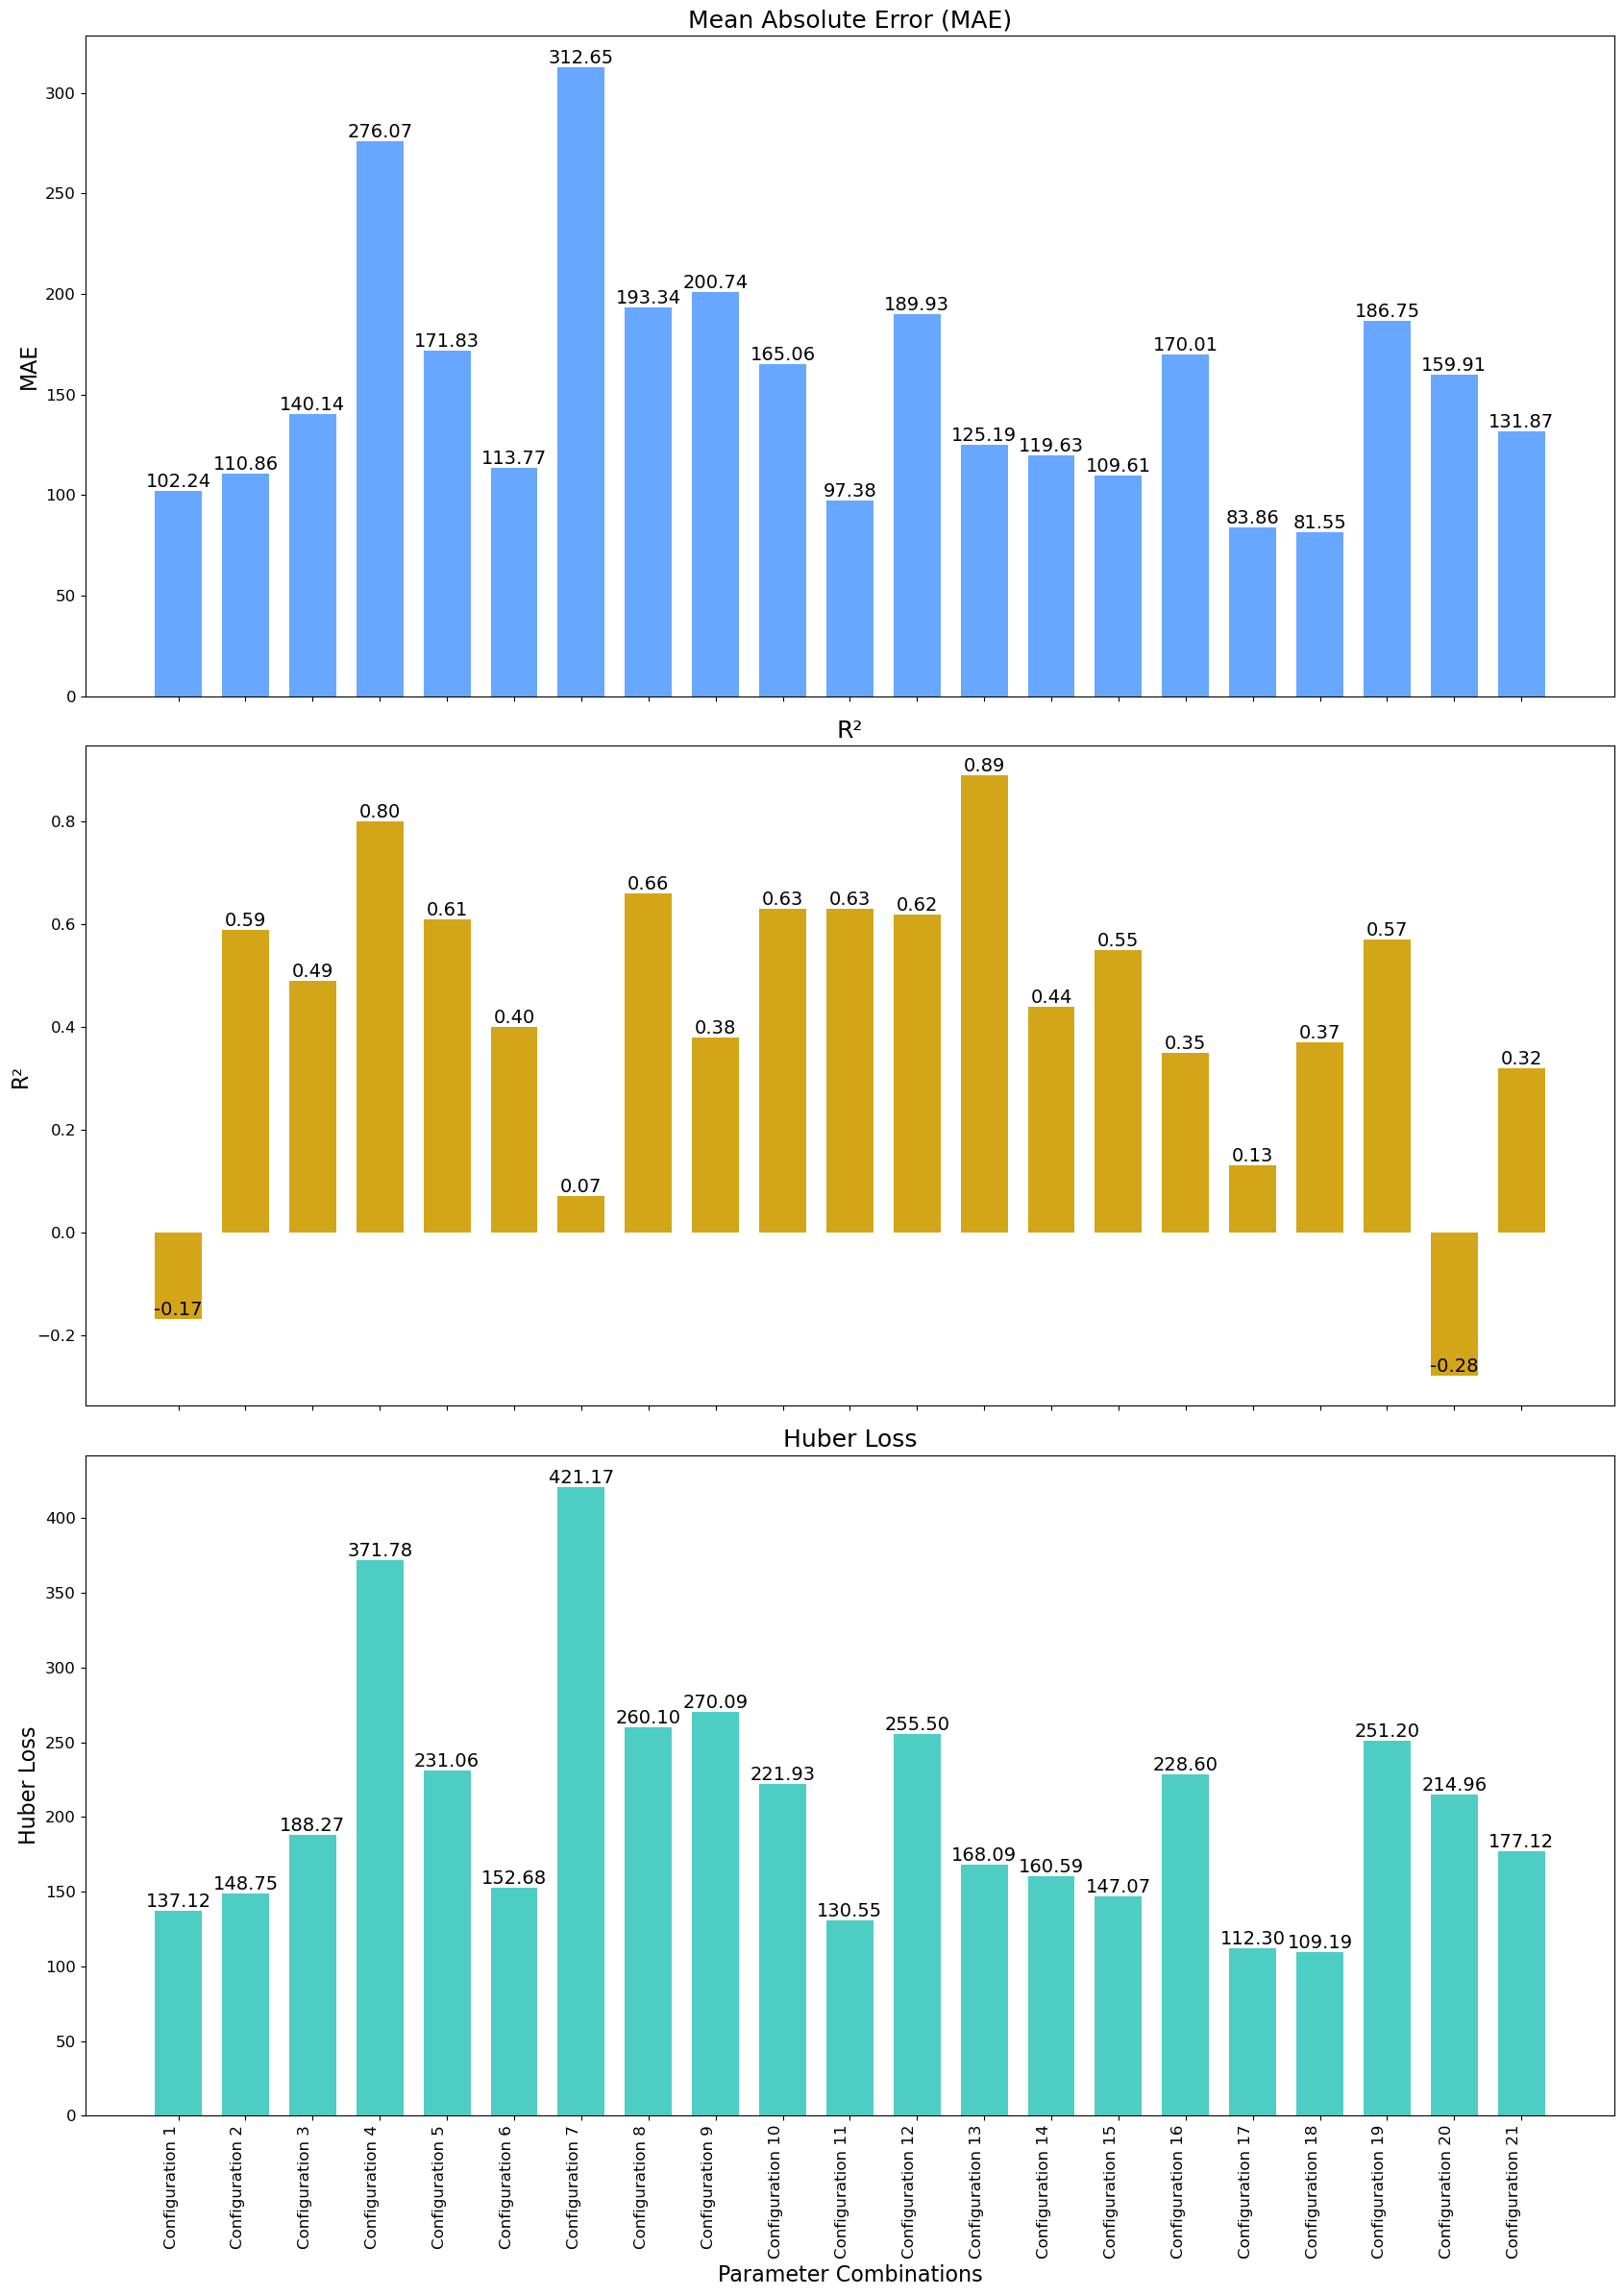

In [76]:
param_dict_xgb = {
    "Parameters": ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5",
                   "Configuration 6", "Configuration 7", "Configuration 8", "Configuration 9", "Configuration 10",
                   "Configuration 11", "Configuration 12", "Configuration 13", "Configuration 14", "Configuration 15",
                   "Configuration 16", "Configuration 17", "Configuration 18", "Configuration 19", "Configuration 20",
                   "Configuration 21"],
    
    
                #1 {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
                #2 {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
                #3 {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 200}
                #4 {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
                #5 {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 200}
                #6 {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 150}
                #7 {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__n_estimators': 150}
                #8 {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200}
                #9 {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__n_estimators': 200}
                #10 {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 150}
                #11 {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__n_estimators': 200}
                #12 {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 150}
                #13 {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__n_estimators': 150}
                #14 {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 150}
                #15 {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200}
                #16 {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
                #17 {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
                #18 {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200}
                #19 {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__n_estimators': 200}
                #20 {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 200}
                #21 {'model__colsample_bytree': 0.9, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 150}

                   
    "MAE": [102.24, 110.86, 140.14, 276.07, 171.83, 113.77, 312.65, 193.34, 200.74, 165.06, 
            97.38, 189.93, 125.19, 119.63, 109.61, 170.01, 83.86, 81.55, 186.75, 159.91, 131.87],
    
    "R²": [-0.17, 0.59, 0.49, 0.80, 0.61, 0.40, 0.07, 0.66, 0.38, 0.63, 
           0.63, 0.62, 0.89, 0.44, 0.55, 0.35, 0.13, 0.37, 0.57, -0.28, 0.32],
    
    "Huber Loss": [137.12, 148.75, 188.27, 371.78, 231.06, 152.68, 421.17, 260.10, 270.09, 221.93, 
                   130.55, 255.50, 168.09, 160.59, 147.07, 228.60, 112.30, 109.19, 251.20, 214.96, 177.12]
}

param_data_xgb = pd.DataFrame(param_dict_xgb)

# Plotting a grouped bar chart for each metric
x_indices = np.arange(len(param_data_xgb))  
 
fig, axes = plt.subplots(3, 1, figsize=(17, 25), sharex=True)

bar_width = 0.7

# Plot for MAE
bars = axes[0].bar(x_indices, param_data_xgb["MAE"], width=bar_width, color=colour_codes[0])
axes[0].set_title("Mean Absolute Error (MAE)", fontsize=18)
axes[0].set_ylabel("MAE", fontsize=16)
axes[0].tick_params(axis="y", labelsize=12)

for bar in bars:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=14)

# Plot for R²
bars = axes[1].bar(x_indices, param_data_xgb["R²"], width=bar_width, color= colour_codes[1])
axes[1].set_title("R²", fontsize=18)
axes[1].set_ylabel("R²", fontsize=16)
axes[1].tick_params(axis="y", labelsize=12)

for bar in bars:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=14)

# Plot for Huber Loss
bars = axes[2].bar(x_indices, param_data_xgb["Huber Loss"], width=bar_width,  color=colour_codes[5])
axes[2].set_title("Huber Loss", fontsize=18)
axes[2].set_xlabel("Parameter Combinations", fontsize=16)
axes[2].set_ylabel("Huber Loss", fontsize=16)
axes[2].tick_params(axis="y", labelsize=12)
axes[2].set_xticks(x_indices)
axes[2].set_xticklabels(param_data_xgb["Parameters"], rotation=90, ha="right", fontsize=12)

for bar in bars:
    yval = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig("validation_metrics_xgb.png", dpi=300)
plt.show()



## Residual plots of two best models

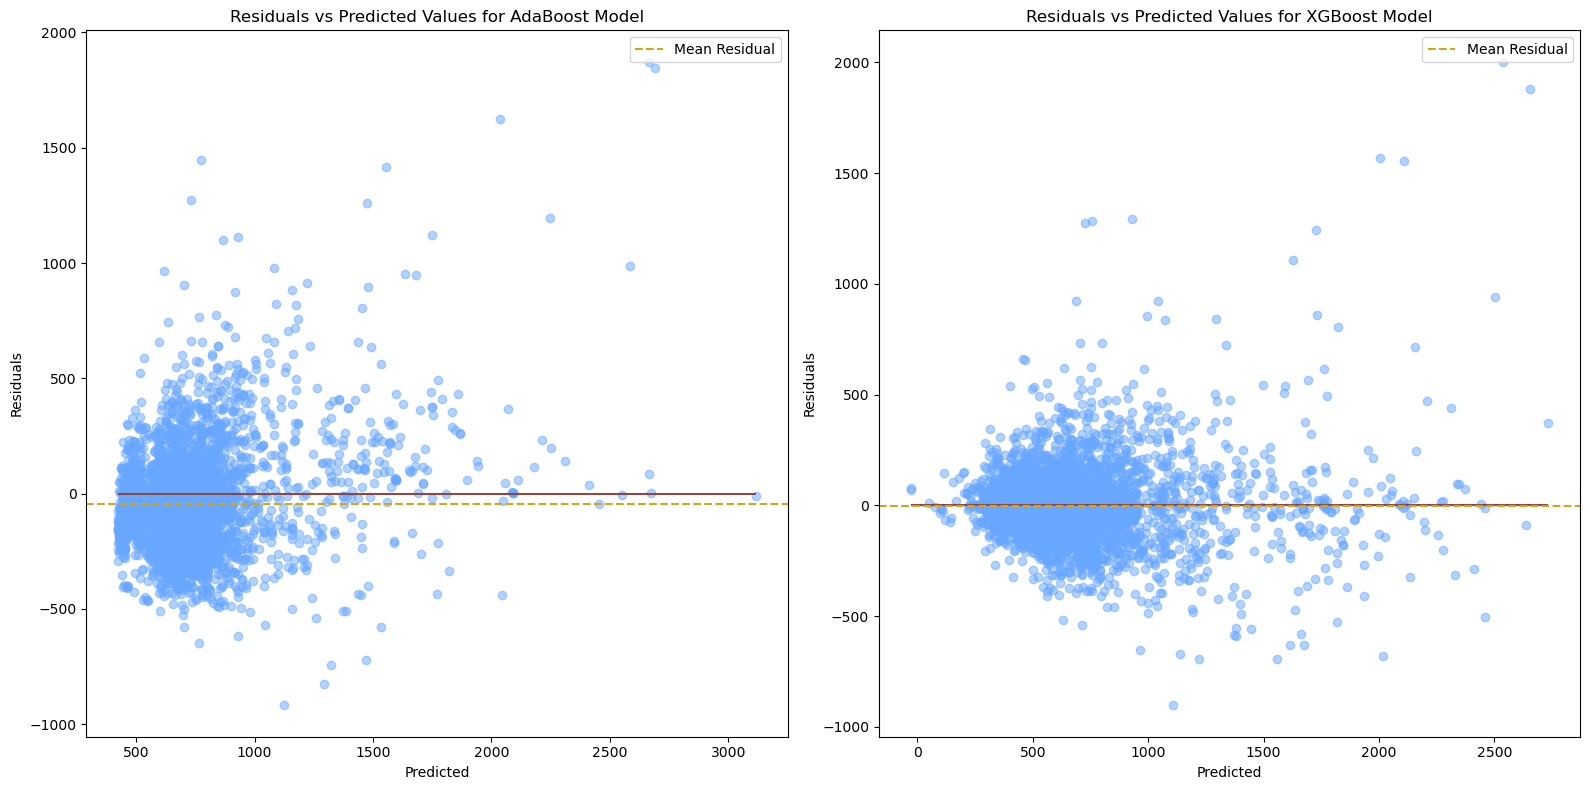

In [36]:
# Calculate residuals for the shuffled AdaBoost and XGBoost models
residuals_ada = y_val - y_pred_val_adashuffle
residuals_xgb = y_val - y_pred_val_xgbshuffle

# Calculating mean of residuals for AdaBoost
mean_residuals_ada = np.mean(residuals_ada)

# Calculating mean of residuals for XGBoost
mean_residuals_xgb = np.mean(residuals_xgb)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# AdaBoost Residuals
axs[0].scatter(y_pred_val_adashuffle, residuals_ada, alpha=0.5, color=colour_codes[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Residuals')
axs[0].hlines(0, min(y_pred_val_adashuffle), max(y_pred_val_adashuffle), color=colour_codes[3])  
axs[0].axhline(y=mean_residuals_ada, color=colour_codes[1], linestyle='--', label='Mean Residual')  
axs[0].legend()
axs[0].set_title('Residuals vs Predicted Values for AdaBoost Model')

# XGBoost Residuals
axs[1].scatter(y_pred_val_xgbshuffle, residuals_xgb, alpha=0.5, color=colour_codes[0])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Residuals')
axs[1].hlines(0, min(y_pred_val_xgbshuffle), max(y_pred_val_xgbshuffle), color=colour_codes[3])  
axs[1].axhline(y=mean_residuals_xgb, color=colour_codes[1], linestyle='--', label='Mean Residual')  
axs[1].legend()
axs[1].set_title('Residuals vs Predicted Values for XGBoost Model')

plt.tight_layout()
plt.savefig('residuals_subplots.png', dpi=300)
plt.show()


## Training with text-related data

### New data preparation

In [37]:
df2 = full_iuropa.copy()

# Including keyword and word count columns
columns_to_drop2 = ['judgment', 'order', 'ag opinion', 'ag view']

df2 = df2.drop(columns=columns_to_drop2, errors='ignore')

df2 = df2.sort_values(by='case_year')

num_samples2 = len(df2)
split_index2 = int(num_samples2 * 0.85)

# Extracting the last 15% for the held-out test set
held_out_test2 = df2.iloc[split_index2:] 

# Extracting the first 85% for training/validation
train_val_set2 = df2.iloc[:split_index2]

In [6]:
train_set_text, val_set_text = train_test_split(train_val_set2, test_size=0.3, shuffle=True, random_state=42)

numeric_columns2 = [col for col in train_val_set2.select_dtypes(include=['int', 'float']).columns if col != 'duration_days' and col != 'case_year']
object_columns2 = [col for col in train_val_set2.select_dtypes(include=['object']).columns]

preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns2),
        ('cat', OneHotEncoder(handle_unknown='ignore'), object_columns2)
    ],
    remainder='passthrough'
)

### Shuffled Adaboost on validation using text data

In [22]:
# Defining an AdaBoost pipeline with the best hyperparameters found
adaboost_pipeline_text = Pipeline([
    ('preprocessor', preprocessor2),
    ('model', AdaBoostRegressor(
        random_state=42,
        n_estimators=200,
        learning_rate=0.2,
        estimator=DecisionTreeRegressor(max_depth=7)
    ))
])

adaboost_pipeline_text.fit(train_set_text.drop(['duration_days', 'case_year'], axis=1), train_set_text['duration_days'])

X_val_text = val_set_text.drop(['duration_days', 'case_year'], axis=1)  
y_val_text = val_set_text['duration_days']  

y_pred_val_text_ada = adaboost_pipeline_text.predict(X_val_text)

text_val_mae_ada = mean_absolute_error(y_val_text, y_pred_val_text_ada)
text_val_r2_ada = r2_score(y_val_text, y_pred_val_text_ada)
text_val_huber_ada = huber_loss(y_val_text, y_pred_val_text_ada)

print("Validation Metrics for AdaBoost:")
print(f"MAE: {text_val_mae_ada:.2f}")
print(f"R²: {text_val_r2_ada:.2f}")
print(f"Huber Loss: {text_val_huber_ada:.2f}")


Validation Metrics for AdaBoost:
MAE: 160.61
R²: 0.67
Huber Loss: 215.91


### Shuffled XGBoost on validation using text data

In [43]:
# Defining XGBoost pipeline with the best hyperparameters found
xgb_pipeline_text = Pipeline([
    ('preprocessor', preprocessor2),
    ('model', XGBRegressor(
        random_state=42,
        n_estimators=200,
        learning_rate=0.2,
        max_depth=7,
        colsample_bytree=0.7
    ))
])

xgb_pipeline_text.fit(train_set_text.drop(['duration_days', 'case_year'], axis=1), train_set_text['duration_days'])

y_pred_val_text_xgb = xgb_pipeline_text.predict(X_val_text)

text_val_mae_xgb = mean_absolute_error(y_val_text, y_pred_val_text_xgb)
text_val_r2_xgb = r2_score(y_val_text, y_pred_val_text_xgb)
text_val_huber_xgb = huber_loss(y_val_text, y_pred_val_text_xgb)

print("Validation Metrics:")
print(f"MAE: {text_val_mae_xgb:.2f}")
print(f"R²: {text_val_r2_xgb:.2f}")
print(f"Huber Loss: {text_val_huber_xgb:.2f}")

Validation Metrics:
MAE: 109.27
R²: 0.80
Huber Loss: 146.61


## Graphs of performance metrics all models

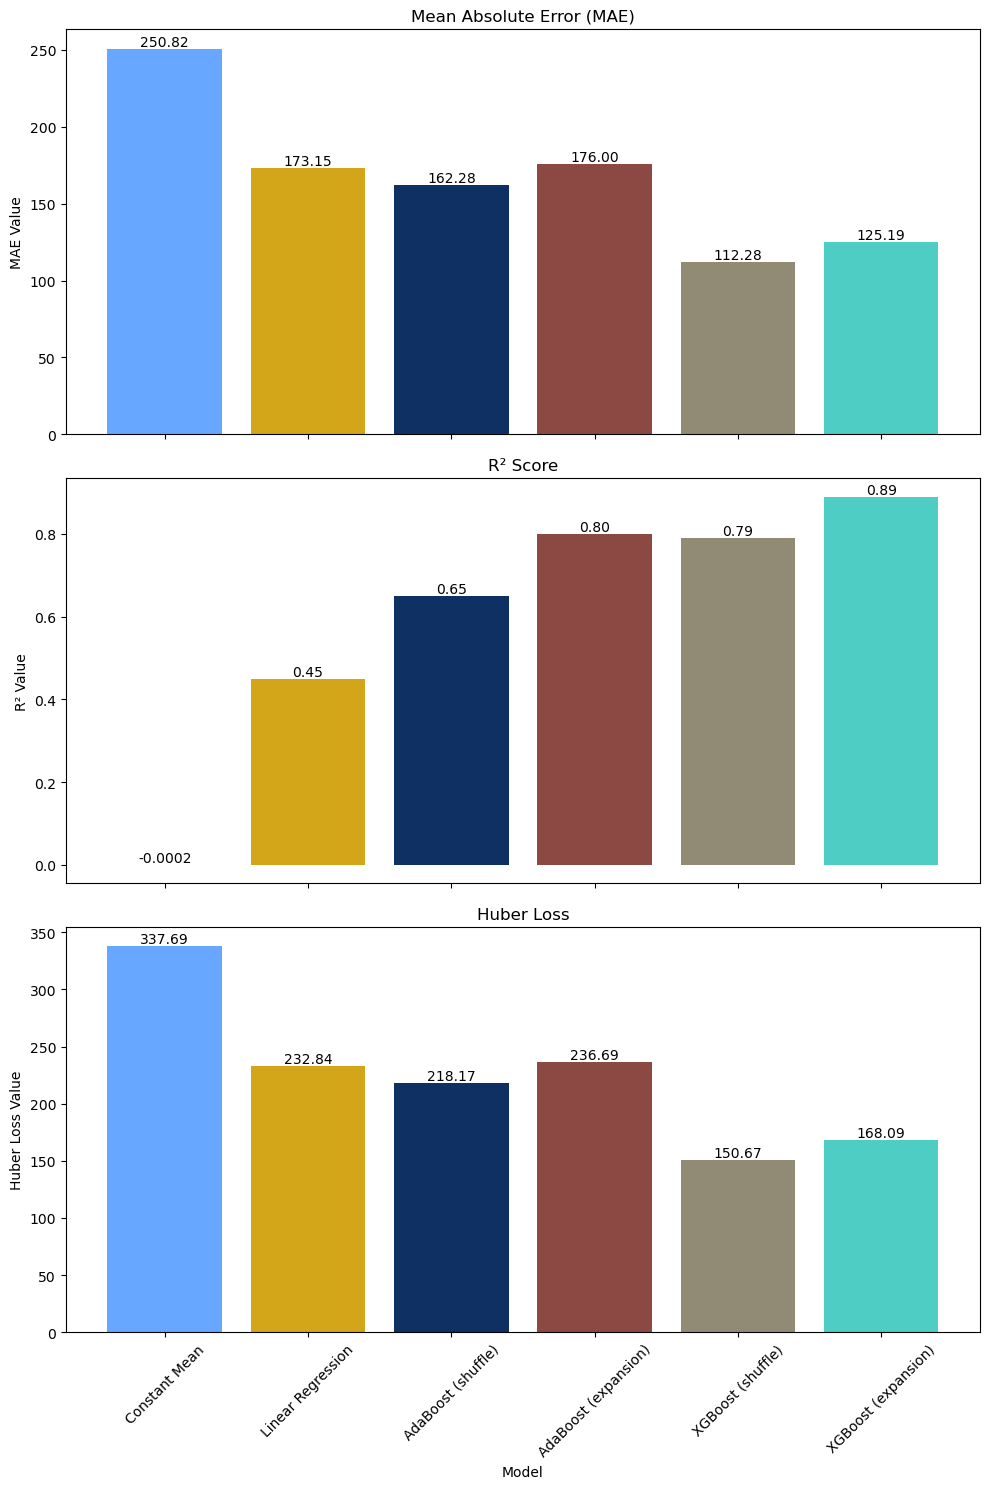

In [3]:
model_data = {
    'models': ['Constant Mean', 'Linear Regression', 'AdaBoost (shuffle)', 
               'AdaBoost (expansion)', 'XGBoost (shuffle)', 'XGBoost (expansion)'],
    
    'mae': [250.82, 173.15, 162.28, 176.00, 112.28, 125.19],
    
    'r2_score': [-0.0002, 0.45, 0.65, 0.80, 0.79, 0.89],
    
    'huber_loss': [337.69, 232.84, 218.17, 236.69, 150.67, 168.09]
    
}

# Creating a dictionary to map models to colors
model_colors = {
    'Constant Mean': colour_codes[0],
    'Linear Regression': colour_codes[1],
    'AdaBoost (shuffle)': colour_codes[2],
    'AdaBoost (expansion)': colour_codes[3],
    'XGBoost (shuffle)': colour_codes[4],
    'XGBoost (expansion)': colour_codes[5]
}

fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Plot MAE
bars_mae = axes[0].bar(model_data['models'], model_data['mae'], color=[model_colors[model] for model in model_data['models']])
axes[0].set_title('Mean Absolute Error (MAE)')
axes[0].set_ylabel('MAE Value')

# Add values on the bars for MAE
for bar in bars_mae:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

# Plot R²
bars_r2 = axes[1].bar(model_data['models'], model_data['r2_score'], color=[model_colors[model] for model in model_data['models']])
axes[1].set_title('R² Score')
axes[1].set_ylabel('R² Value')

# Add values on the bars for R²
for i, bar in enumerate(bars_r2):
    height = bar.get_height()
    if i == 0:
        # Value is to small. 2 decimals would be meaningless
        axes[1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.4f}', ha='center', va='bottom') 
    else:
        axes[1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

# Plot Huber Loss
bars_huber = axes[2].bar(model_data['models'], model_data['huber_loss'], color=[model_colors[model] for model in model_data['models']])
axes[2].set_title('Huber Loss')
axes[2].set_ylabel('Huber Loss Value')
axes[2].tick_params(axis='x', rotation=45)

# Add values on the bars for Huber Loss
for bar in bars_huber:
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

plt.xlabel('Model')

plt.tight_layout()

plt.savefig('performance_metrics.png', dpi=300)
plt.show()


## Residual plots of two best models including text-related data

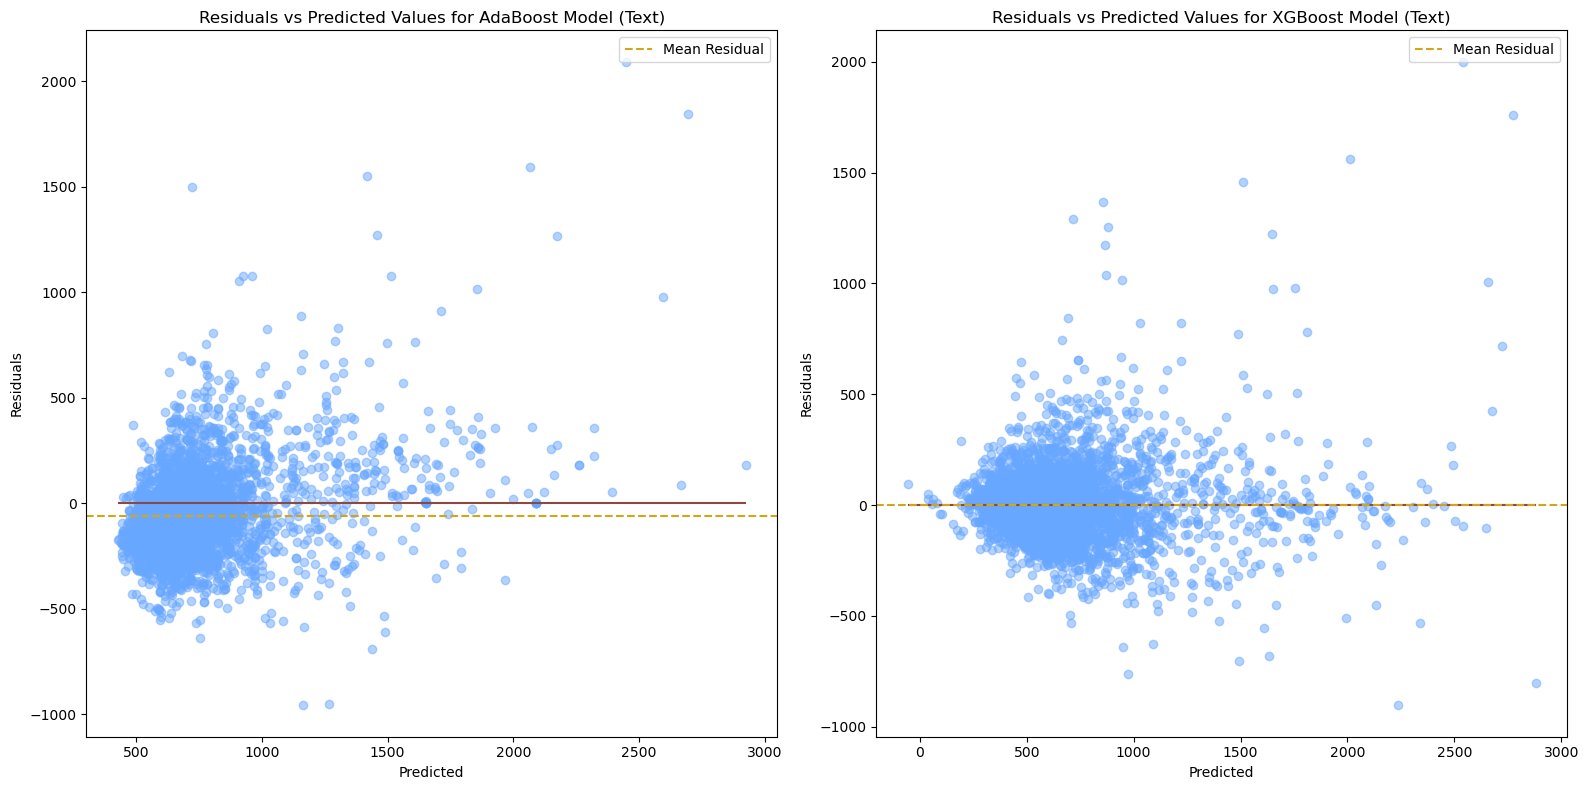

In [39]:
# Calculate residuals for AdaBoost and XGBoost text models
residuals_ada_text = y_val_text - y_pred_val_text_ada
residuals_xgb_text = y_val_text - y_pred_val_text_xgb

# Calculating mean of residuals for AdaBoost
mean_residuals_ada_text = np.mean(residuals_ada_text)

# Calculating mean of residuals for XGBoost
mean_residuals_xgb_text = np.mean(residuals_xgb_text)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# AdaBoost Residuals
axs[0].scatter(y_pred_val_text_ada, residuals_ada_text, alpha=0.5, color=colour_codes[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Residuals')
axs[0].hlines(0, min(y_pred_val_text_ada), max(y_pred_val_text_ada), color=colour_codes[3])  
axs[0].axhline(y=mean_residuals_ada_text, color=colour_codes[1], linestyle='--', label='Mean Residual')  
axs[0].legend()
axs[0].set_title('Residuals vs Predicted Values for AdaBoost Model (Text)')

# XGBoost Residuals
axs[1].scatter(y_pred_val_text_xgb, residuals_xgb_text, alpha=0.5, color=colour_codes[0])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Residuals')
axs[1].hlines(0, min(y_pred_val_text_xgb), max(y_pred_val_text_xgb), color=colour_codes[3])  
axs[1].axhline(y=mean_residuals_xgb_text, color=colour_codes[1], linestyle='--', label='Mean Residual')  
axs[1].legend()
axs[1].set_title('Residuals vs Predicted Values for XGBoost Model (Text)')

plt.tight_layout()
plt.savefig('residuals_subplots_text.png', dpi=300)
plt.show()


## Combined AdaBoost and XGBoost residual plots

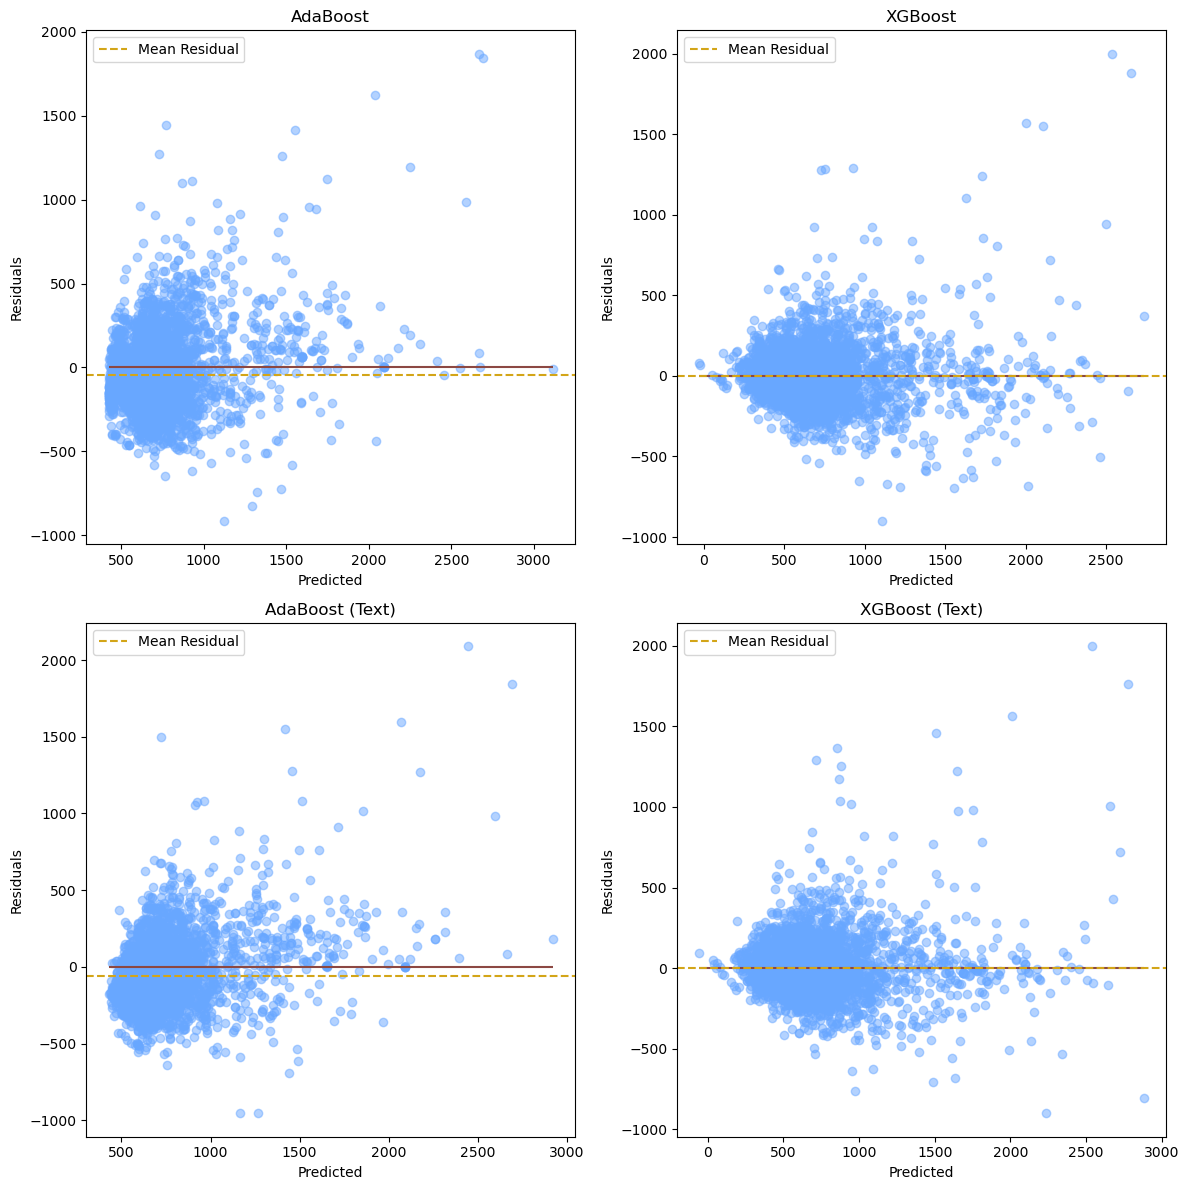

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# AdaBoost Residuals
axs[0, 0].scatter(y_pred_val_adashuffle, residuals_ada, alpha=0.5, color=colour_codes[0])
axs[0, 0].set_xlabel('Predicted')
axs[0, 0].set_ylabel('Residuals')
axs[0, 0].hlines(0, min(y_pred_val_adashuffle), max(y_pred_val_adashuffle), color=colour_codes[3])  
axs[0, 0].axhline(y=mean_residuals_ada, color=colour_codes[1], linestyle='--', label='Mean Residual')  
axs[0, 0].legend()
axs[0, 0].set_title('AdaBoost')

# XGBoost Residuals
axs[0, 1].scatter(y_pred_val_xgbshuffle, residuals_xgb, alpha=0.5, color=colour_codes[0])
axs[0, 1].set_xlabel('Predicted')
axs[0, 1].set_ylabel('Residuals')
axs[0, 1].hlines(0, min(y_pred_val_xgbshuffle), max(y_pred_val_xgbshuffle), color=colour_codes[3])  
axs[0, 1].axhline(y=mean_residuals_xgb, color=colour_codes[1], linestyle='--', label='Mean Residual')  
axs[0, 1].legend()
axs[0, 1].set_title('XGBoost')

# AdaBoost Residuals (Text)
axs[1, 0].scatter(y_pred_val_text_ada, residuals_ada_text, alpha=0.5, color=colour_codes[0])
axs[1, 0].set_xlabel('Predicted')
axs[1, 0].set_ylabel('Residuals')
axs[1, 0].hlines(0, min(y_pred_val_text_ada), max(y_pred_val_text_ada), color=colour_codes[3])  
axs[1, 0].axhline(y=mean_residuals_ada_text, color=colour_codes[1], linestyle='--', label='Mean Residual')  
axs[1, 0].legend()
axs[1, 0].set_title('AdaBoost (Text)')

# XGBoost Residuals (Text)
axs[1, 1].scatter(y_pred_val_text_xgb, residuals_xgb_text, alpha=0.5, color=colour_codes[0])
axs[1, 1].set_xlabel('Predicted')
axs[1, 1].set_ylabel('Residuals')
axs[1, 1].hlines(0, min(y_pred_val_text_xgb), max(y_pred_val_text_xgb), color=colour_codes[3])  
axs[1, 1].axhline(y=mean_residuals_xgb_text, color=colour_codes[1], linestyle='--', label='Mean Residual')  
axs[1, 1].legend()
axs[1, 1].set_title('XGBoost (Text)')

plt.tight_layout()
plt.savefig('combined_residuals_subplots.png', dpi=300)
plt.show()


## Best model on held-out test set

In [41]:
# Evaluating best XGBoost pipeline on the test set
y_pred_test_text = xgb_pipeline_text.predict(held_out_test2.drop(['duration_days', 'case_year'], axis=1))

print("\nTest Set Metrics:")
print(f"MAE: {mean_absolute_error(held_out_test2['duration_days'], y_pred_test_text):.2f}")
print(f"R²: {r2_score(held_out_test2['duration_days'], y_pred_test_text):.2f}")
print(f"Huber Loss: {huber_loss(held_out_test2['duration_days'], y_pred_test_text):.2f}")



Test Set Metrics:
MAE: 149.71
R²: 0.08
Huber Loss: 201.20


## Residual plots for best XGBoost model (val and held-out)

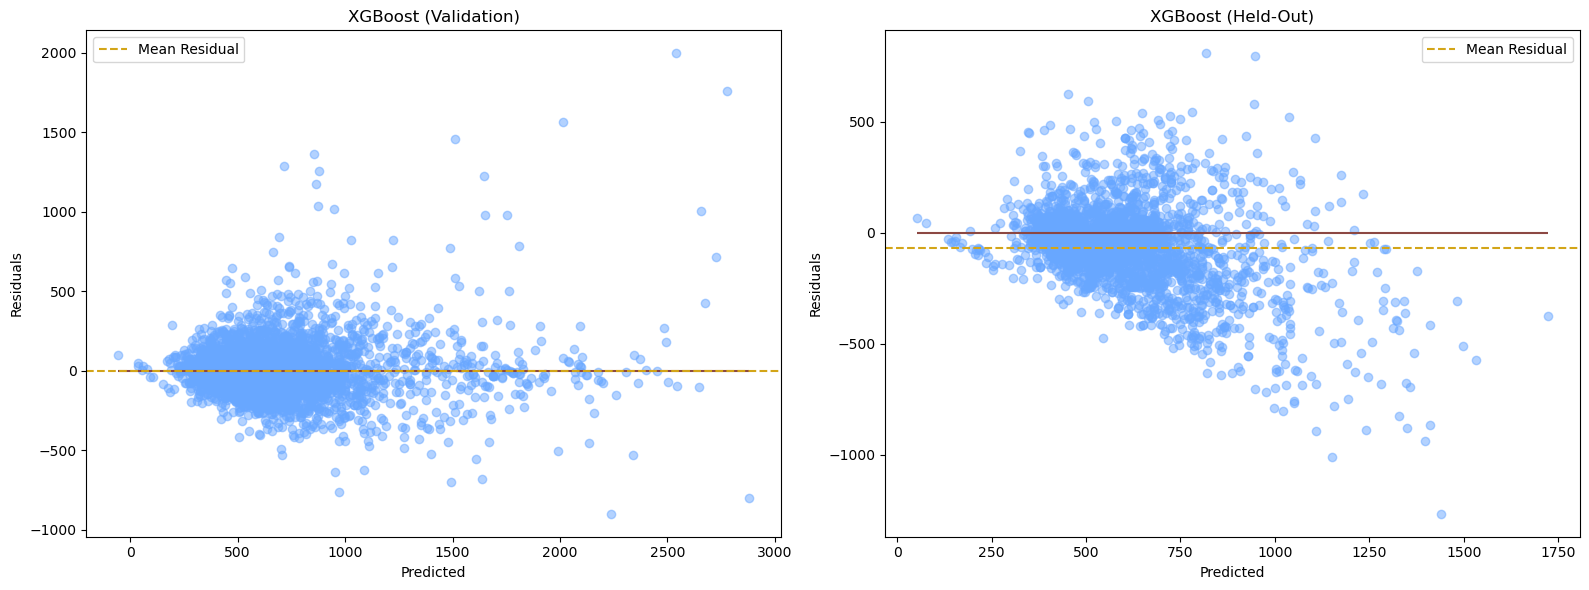

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Calculating residuals for XGBoost on held-out test
residuals_xgb_test = held_out_test2['duration_days'] - y_pred_test_text

# Calculating mean of residuals
mean_residuals_xgb_test = np.mean(residuals_xgb_test)

# XGBoost Validation Residuals (including Text)
axs[0].scatter(y_pred_val_text_xgb, residuals_xgb_text, alpha=0.5, color=colour_codes[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Residuals')
axs[0].hlines(0, min(y_pred_val_text_xgb), max(y_pred_val_text_xgb), color=colour_codes[3])  
axs[0].axhline(y=mean_residuals_xgb_text, color=colour_codes[1], linestyle='--', label='Mean Residual')  
axs[0].legend()
axs[0].set_title('XGBoost (Validation)')

# XGBoost Test Residuals
axs[1].scatter(y_pred_test_text, residuals_xgb_test, alpha=0.5, color=colour_codes[0])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Residuals')
axs[1].hlines(0, min(y_pred_test_text), max(y_pred_test_text), color=colour_codes[3])  
axs[1].axhline(y=mean_residuals_xgb_test, color=colour_codes[1], linestyle='--', label='Mean Residual')  
axs[1].legend()
axs[1].set_title('XGBoost (Held-Out)')

plt.tight_layout()
plt.savefig('combined_residuals_test.png', dpi=300)
plt.show()


# SHAP

Shap needs a lower version of numpy

In [ ]:
!pip install numpy==1.24

import numpy as np

In [1]:
import shap

In [14]:
X_val_encoded_text = xgb_pipeline_text.named_steps['preprocessor'].transform(X_val_text)

# Getting feature names after one-hot encoding
encoded_cat_columns = xgb_pipeline_text.named_steps['preprocessor'].named_transformers_['cat'] \
                          .get_feature_names_out(input_features=object_columns2)

feature_names_encoded = np.concatenate([numeric_columns2, encoded_cat_columns, held_out_test2.select_dtypes(include=['bool']).columns])

# Calculating SHAP values
explainer = shap.Explainer(xgb_pipeline_text.named_steps['model'], X_val_encoded_text, feature_names=feature_names_encoded)
shap_values = explainer.shap_values(X_val_encoded_text)

 98%|===================| 4061/4130 [00:32<00:00]        

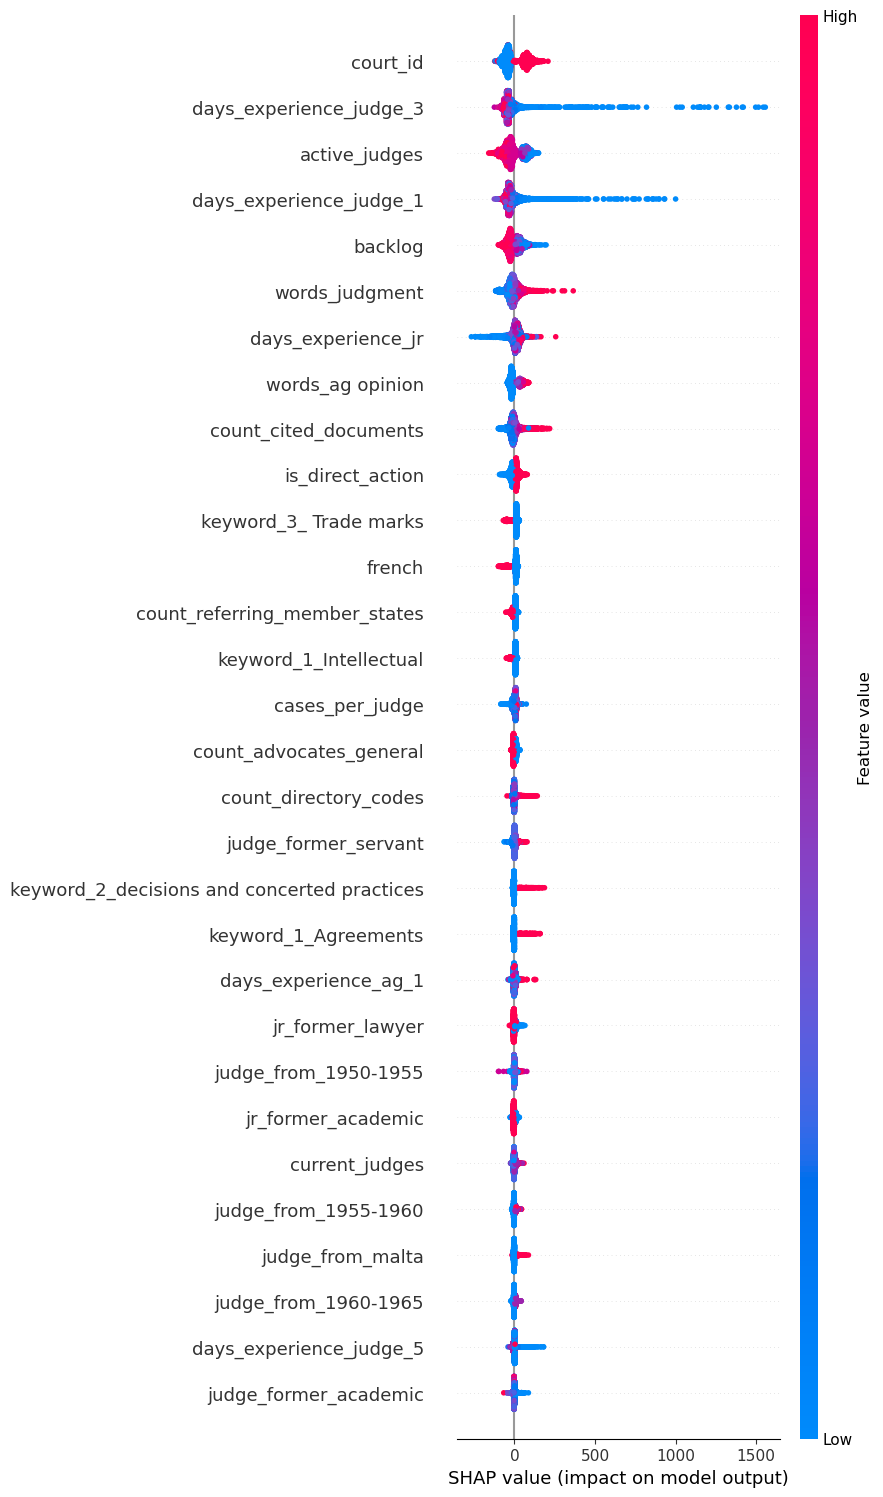

In [18]:
# Plot SHAP values
shap.summary_plot(shap_values, X_val_encoded_text, feature_names=feature_names_encoded, max_display=30, plot_size=(0.5), show=False)
fig = plt.gcf()
fig.set_size_inches(10, 15)

plt.savefig('shap_summary_plot.png', dpi = 300)  

In [121]:
# Calculating absolute SHAP values
abs_shap_values = np.abs(shap_values)

# Summing for each feature across all samples
overall_shap_values = np.sum(abs_shap_values, axis=0)

# Sorting features based on their absolute SHAP values
sorted_features_indices = np.argsort(overall_shap_values)[::-1]
sorted_features = [feature_names[i] for i in sorted_features_indices]

for feature, shap_value in zip(sorted_features, overall_shap_values[sorted_features_indices]):
    print(f"Feature: {feature}, Overall SHAP Value: {shap_value}")


Feature: court_id, Overall SHAP Value: 249659.75392396722
Feature: days_experience_judge_3, Overall SHAP Value: 223511.51536492404
Feature: active_judges, Overall SHAP Value: 204911.27679445207
Feature: days_experience_judge_1, Overall SHAP Value: 186759.84590915267
Feature: backlog, Overall SHAP Value: 146197.84362236704
Feature: words_judgment, Overall SHAP Value: 118194.95606628423
Feature: days_experience_jr, Overall SHAP Value: 109980.08224707935
Feature: words_ag opinion, Overall SHAP Value: 105802.95699794711
Feature: count_cited_documents, Overall SHAP Value: 99959.11953226068
Feature: is_direct_action, Overall SHAP Value: 83187.81469582922
Feature: keyword_3_ Trade marks, Overall SHAP Value: 77795.62231552122
Feature: french, Overall SHAP Value: 76108.58425862383
Feature: count_referring_member_states, Overall SHAP Value: 38091.55568991106
Feature: keyword_1_Intellectual, Overall SHAP Value: 37786.095178925
Feature: cases_per_judge, Overall SHAP Value: 37477.46709076034
Featur

In [122]:
total_features = len(sorted_features)

#Counting number of features with overall SHAP value of 0
zero_shap_count = np.count_nonzero(overall_shap_values == 0)

print(f"Total number of features: {total_features}")
print(f"Number of features with overall SHAP value of 0: {zero_shap_count}")

Total number of features: 902
Number of features with overall SHAP value of 0: 496
